In [8]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ray
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, normaltest, jarque_bera
from hurst import compute_Hc
from functools import partial
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import normaltest

## 1.Data loading

In [19]:
df = pd.read_csv('BTCUSDT_daily.csv')
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]
X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)


## 2. One run before tuning

## 3. Hyperparameter tuning

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import random
import json
import warnings
import time
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set All Seeds
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(2025)

# -------------------------
# 1. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Split and convert to tensors
    X_train = torch.FloatTensor(X_all[:train_end]).to(device)
    y_train = torch.FloatTensor(y_all[:train_end]).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_all[train_end:val_end]).to(device)
    y_val = torch.FloatTensor(y_all[train_end:val_end]).unsqueeze(1).to(device)
    X_test = torch.FloatTensor(X_all[val_end:]).to(device)
    y_test = torch.FloatTensor(y_all[val_end:]).unsqueeze(1).to(device)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 2. Model Definition with Built-in LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (always on, except for last layer)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function - AGD NLL Only (Optimized)
# -------------------------
def expectile_loss(y, mu, tau, sigma=1.0, precomputed_constants=None):
    """Asymmetric Gaussian NLL for training - optimized version"""
    device = y.device
    dtype = y.dtype
    
    residual = y - mu
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    if precomputed_constants is None:
        # Create all constants on the same device
        tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
        sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
        pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
        
        # NLL components
        sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
        sqrt_tau = torch.sqrt(1/tau_tensor)
        norm = sqrt_1_minus_tau + sqrt_tau
        
        const_term = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor) + torch.log(norm)
        sigma_sq = sigma_tensor**2
    else:
        const_term, sigma_sq = precomputed_constants
    
    loss = const_term + weight * (residual**2) / sigma_sq
    
    return loss.mean()

def calculate_agd_nll(y_true, y_pred, tau, sigma=1.0):
    """Calculate AGD NLL for evaluation"""
    if not torch.is_tensor(y_true):
        y_true = torch.FloatTensor(y_true)
        y_pred = torch.FloatTensor(y_pred)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean().item()

# -------------------------
# 4. Training Function with LR Scheduler
# -------------------------
def train_single_seed(X_train, y_train, X_val, y_val, config, seed, max_epochs=150):
    """Train model with a specific seed and return validation NLL"""
    set_all_seeds(seed)
    
    model = AsymmetricGaussianExpectile(config).to(X_train.device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler (always on)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=20,  # Fixed patience
        factor=0.5,   # Fixed factor
        min_lr=1e-6
    )
    
    # Training setup
    batch_size = config.get('batch_size', 64)
    patience = 15  # Early stopping patience
    best_val_nll = float('inf')
    patience_counter = 0
    best_model_state = None
    
    sigma = config.get('sigma', 1.0)
    tau = config['tau']
    
    # Precompute constants for loss function
    device = X_train.device
    dtype = X_train.dtype
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    const_term = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor) + torch.log(norm)
    sigma_sq = sigma_tensor**2
    precomputed = (const_term, sigma_sq)
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    generator = torch.Generator().manual_seed(seed)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    # Validation check frequency
    val_check_interval = 3  # Check validation every 3 epochs
    
    for epoch in range(max_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = expectile_loss(batch_y, pred, tau, sigma, precomputed)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate (less frequently)
        if epoch % val_check_interval == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_nll = calculate_agd_nll(y_val, val_pred, tau, sigma)
            
            # Update learning rate
            scheduler.step(val_nll)
            
            # Early stopping
            if val_nll < best_val_nll:
                best_val_nll = val_nll
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience // val_check_interval:
                    break
    
    # Load best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return best_val_nll

def train_for_hp_search(X_train, y_train, X_val, y_val, config, trial=None):
    """Train with 2 seeds and return mean NLL"""
    seeds = [2025, 2125]  # 2 seeds for balance between speed and robustness
    val_nlls = []
    
    for i, seed in enumerate(seeds):
        try:
            val_nll = train_single_seed(X_train, y_train, X_val, y_val, config, seed)
            val_nlls.append(val_nll)
            
            if trial and i < len(seeds) - 1:
                trial.report(np.mean(val_nlls), i)
                if trial.should_prune():
                    raise optuna.TrialPruned()
        except Exception as e:
            print(f"Failed with seed {seed}: {e}")
            continue
    
    return np.mean(val_nlls) if val_nlls else float('inf')

# -------------------------
# 5. Hyperparameter Search Space (without LayerNorm/BatchNorm tuning)
# -------------------------
def get_hp_space(tau, trial):
    base = {'tau': tau}
    is_extreme = (tau <= 0.05) or (tau >= 0.95)

    if is_extreme:
        # Extremes: smaller-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 16, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 16, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 16, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu','gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 1e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
        })
    else:
        # Central: higher-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 48, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 48, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 48, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu', 'gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 3e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 2e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
        })

    # Optional gradient clipping
    use_gc = trial.suggest_categorical('use_gradient_clip', [False, True])
    base['gradient_clip'] = trial.suggest_float('gradient_clip_value', 0.5, 8.0) if use_gc else None

    return base
    
def tune_hyperparameters(X_train, y_train, X_val, y_val, tau, n_trials=20):
    """Tune hyperparameters for a specific expectile"""
    print(f"\n{'='*60}")
    print(f"Tuning Hyperparameters for Expectile τ={tau:.3f}")
    print(f"Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)")
    print(f"Scoring: 100% Validation NLL | Seeds: 2 | Trials: {n_trials}")
    print(f"{'='*60}")
    
    input_dim = X_train.shape[2]
    
    def objective(trial):
        config = get_hp_space(tau, trial)
        config['input_dim'] = input_dim
        
        # Store config for retrieval
        for key, value in config.items():
            trial.set_user_attr(f'config_{key}', value)
        
        start_time = time.time()
        mean_val_nll = train_for_hp_search(X_train, y_train, X_val, y_val, config, trial)
        
        trial.set_user_attr('mean_val_nll', mean_val_nll)
        trial.set_user_attr('training_time', time.time() - start_time)
        
        return mean_val_nll
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=2025),#2019
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Reconstruct best config
    best_config = {}
    for attr_name, attr_value in study.best_trial.user_attrs.items():
        if attr_name.startswith('config_'):
            param_name = attr_name.replace('config_', '')
            best_config[param_name] = attr_value
    
    best_config['tau'] = tau
    
    print(f"\nBest NLL: {study.best_value:.4f}")
    avg_time = np.mean([t.user_attrs.get('training_time', 0) for t in study.trials if 'training_time' in t.user_attrs])
    print(f"Average trial time: {avg_time:.1f}s")
    print("Best parameters:")
    for k, v in sorted(best_config.items()):
        if k not in ['input_dim', 'tau']:
            print(f"  {k}: {v}")
    
    return best_config

# -------------------------
# 6. Main Pipeline
# -------------------------
def main(X_all, y_all, tau_list=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], n_trials=20):
    """Main hyperparameter tuning pipeline"""
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print(f"\nAGD HYPERPARAMETER TUNING - WITH BUILT-IN LAYERNORM & LR SCHEDULER")
    print(f"="*60)
    print(f"Data: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
    print(f"Settings: 2 seeds per trial | {n_trials} trials per expectile")
    print(f"Built-in features: LayerNorm (always on) | LR Scheduler (always on)")
    print(f"{'='*60}")
    
    best_hyperparams = {}
    total_start = time.time()
    
    for tau in tau_list:
        tau_start = time.time()
        best_hyperparams[tau] = tune_hyperparameters(X_train, y_train, X_val, y_val, tau, n_trials)
        print(f"Time for τ={tau:.3f}: {(time.time() - tau_start)/60:.1f} minutes")
    
    print(f"\nTotal tuning time: {(time.time() - total_start)/60:.1f} minutes")
    
    # Display results
    display_results(best_hyperparams)
    
    # Save results
    with open('best_hyperparams_agd_layernorm_scheduler_builtin.json', 'w') as f:
        json.dump(best_hyperparams, f, indent=2)
    
    return best_hyperparams

def display_results(best_hyperparams):
    """Display results in a clean table"""
    param_data = []
    
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        
        # Handle variable hidden layers
        n_layers = hp.get('n_hidden_layers', 2)
        hidden_dims = '-'.join([str(hp.get(f'n_hidden{i}', 'N/A')) for i in range(1, n_layers + 1)])
        
        param_data.append({
            'τ': f"{tau:.3f}",
            'LSTM': f"{hp.get('lstm_hidden_dim')}×{hp.get('lstm_layers', 1)}",
            'Hidden': hidden_dims,
            'Act': hp.get('activation', 'relu')[:4],
            'Opt': hp.get('optimizer', 'adam')[:4],
            'LR': f"{hp.get('lr'):.4f}",
            'Drop': f"{hp.get('dropout'):.3f}",
            'Batch': hp.get('batch_size'),
            'σ': f"{hp.get('sigma'):.3f}",
            'WD': f"{hp.get('weight_decay', 0):.0e}",
            'Clip': hp.get('gradient_clip', '-'),
            'Init': hp.get('weight_init', 'glorot')[:6]
        })
    
    df = pd.DataFrame(param_data)
    
    print("\n" + "="*120)
    print("AGD HYPERPARAMETER TUNING RESULTS - WITH BUILT-IN LAYERNORM & LR SCHEDULER")
    print("="*120)
    print(df.to_string(index=False))
    print("="*120)
    print("Note: LayerNorm and LR Scheduler are always enabled (not tuned)")
    print("="*120)
    
    df.to_csv('agd_hp_results_layernorm_scheduler_builtin.csv', index=False)
    
    return df

# -------------------------
# 7. Usage
# -------------------------
if __name__ == "__main__":
    best_hyperparams = main(X_all, y_all, n_trials=20)

[I 2025-08-27 10:34:53,609] A new study created in memory with name: no-name-04ff5789-68ee-4cd2-ab9b-3f363709e3d0


Using device: cpu

AGD HYPERPARAMETER TUNING - WITH BUILT-IN LAYERNORM & LR SCHEDULER
Data: Train 1840 | Val 394 | Test 396
Settings: 2 seeds per trial | 20 trials per expectile
Built-in features: LayerNorm (always on) | LR Scheduler (always on)

Tuning Hyperparameters for Expectile τ=0.025
Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)
Scoring: 100% Validation NLL | Seeds: 2 | Trials: 20


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:35:02,067] Trial 0 finished with value: 2.4027315378189087 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.4027315378189087.
[I 2025-08-27 10:35:04,739] Trial 1 finished with value: 1.9782814383506775 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.9782814383506775.
[I 2025-08-27 10:35:0

[I 2025-08-27 10:36:07,168] A new study created in memory with name: no-name-040af958-8183-4ebf-adf4-028e7ba3f8ea


[I 2025-08-27 10:36:07,164] Trial 19 finished with value: 1.9074196815490723 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 1.362832248210907.

Best NLL: 1.3628
Average trial time: 3.7s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
Time for τ=0.025: 1.2 minutes

Tuning Hyperparameters for Expectile τ=0.050
Built-in: LayerNorm O

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:36:14,904] Trial 0 finished with value: 2.1141945123672485 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.1141945123672485.
[I 2025-08-27 10:36:16,841] Trial 1 finished with value: 1.6897273659706116 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.6897273659706116.
[I 2025-08-27 10:36:1

[I 2025-08-27 10:37:14,370] A new study created in memory with name: no-name-d6b1af6b-00ba-4378-92fd-76131f559116


[I 2025-08-27 10:37:14,367] Trial 19 finished with value: 1.6189917922019958 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 1.0746262073516846.

Best NLL: 1.0746
Average trial time: 3.4s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
Time for τ=0.050: 1.1 minutes

Tuning Hyperparameters for Expectile τ=0.250
Built-in: LayerNorm 

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:37:21,095] Trial 0 finished with value: 1.5588405132293701 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.5588405132293701.
[I 2025-08-27 10:37:23,288] Trial 1 finished with value: 1.134544849395752 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.134544849395752.
[I 2025-08-27 10:37:2

[I 2025-08-27 10:38:24,721] A new study created in memory with name: no-name-b482feb1-f2c2-43c3-80a9-5a3e9faffef7


[I 2025-08-27 10:38:24,718] Trial 19 finished with value: 1.0639353394508362 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.5203019380569458.

Best NLL: 0.5203
Average trial time: 3.5s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
Time for τ=0.250: 1.2 minutes

Tuning Hyperparameters for Expectile τ=0.500
Built-in: LayerNorm

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:38:32,371] Trial 0 finished with value: 1.449745535850525 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.449745535850525.
[I 2025-08-27 10:38:35,648] Trial 1 finished with value: 1.0255346298217773 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.0255346298217773.
[I 2025-08-27 10:38:3

[I 2025-08-27 10:39:41,479] A new study created in memory with name: no-name-4a640ce0-07ee-4aa9-97f0-a6ac9f5f7a96


[I 2025-08-27 10:39:41,476] Trial 19 finished with value: 0.9549165070056915 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.4117169827222824.

Best NLL: 0.4117
Average trial time: 3.8s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
Time for τ=0.500: 1.3 minutes

Tuning Hyperparameters for Expectile τ=0.750
Built-in: LayerNorm

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:39:50,048] Trial 0 finished with value: 1.558887243270874 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.558887243270874.
[I 2025-08-27 10:39:52,140] Trial 1 finished with value: 1.1346566081047058 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.1346566081047058.
[I 2025-08-27 10:39:5

[I 2025-08-27 10:40:56,629] A new study created in memory with name: no-name-e8dc7c30-1dc6-470c-9f21-c0e5a3d28f7d


[I 2025-08-27 10:40:56,626] Trial 19 finished with value: 1.0640036463737488 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.5206873416900635.

Best NLL: 0.5207
Average trial time: 3.7s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
Time for τ=0.750: 1.3 minutes

Tuning Hyperparameters for Expectile τ=0.950
Built-in: LayerNorm

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:41:05,139] Trial 0 finished with value: 2.114227056503296 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.114227056503296.
[I 2025-08-27 10:41:08,119] Trial 1 finished with value: 1.6897546648979187 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.6897546648979187.
[I 2025-08-27 10:41:10,

[I 2025-08-27 10:42:10,782] A new study created in memory with name: no-name-cf37dca4-c9cb-442a-9be3-3239012e0182


[I 2025-08-27 10:42:10,780] Trial 19 finished with value: 1.619051218032837 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 1.074951410293579.

Best NLL: 1.0750
Average trial time: 3.7s
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
Time for τ=0.950: 1.2 minutes

Tuning Hyperparameters for Expectile τ=0.975
Built-in: LayerNorm ON

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-27 10:42:16,919] Trial 0 finished with value: 2.402743101119995 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.402743101119995.
[I 2025-08-27 10:42:19,778] Trial 1 finished with value: 1.9782134890556335 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.9782134890556335.
[I 2025-08-27 10:42:21,

## 4. One run after tuning

AGD EXPECTILE REGRESSION - WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Training expectile 2.5%...
  Test Coverage: 0.015 (Expected: 0.025)

Training expectile 5.0%...
  Test Coverage: 0.033 (Expected: 0.050)

Training expectile 25.0%...
  Test Coverage: 0.199 (Expected: 0.250)

Training expectile 50.0%...
  Test Coverage: 0.548 (Expected: 0.500)

Training expectile 75.0%...
  Test Coverage: 0.338 (Expected: 0.250)

Training expectile 95.0%...
  Test Coverage: 0.164 (Expected: 0.050)

Training expectile 97.5%...
  Test Coverage: 0.025 (Expected: 0.025)


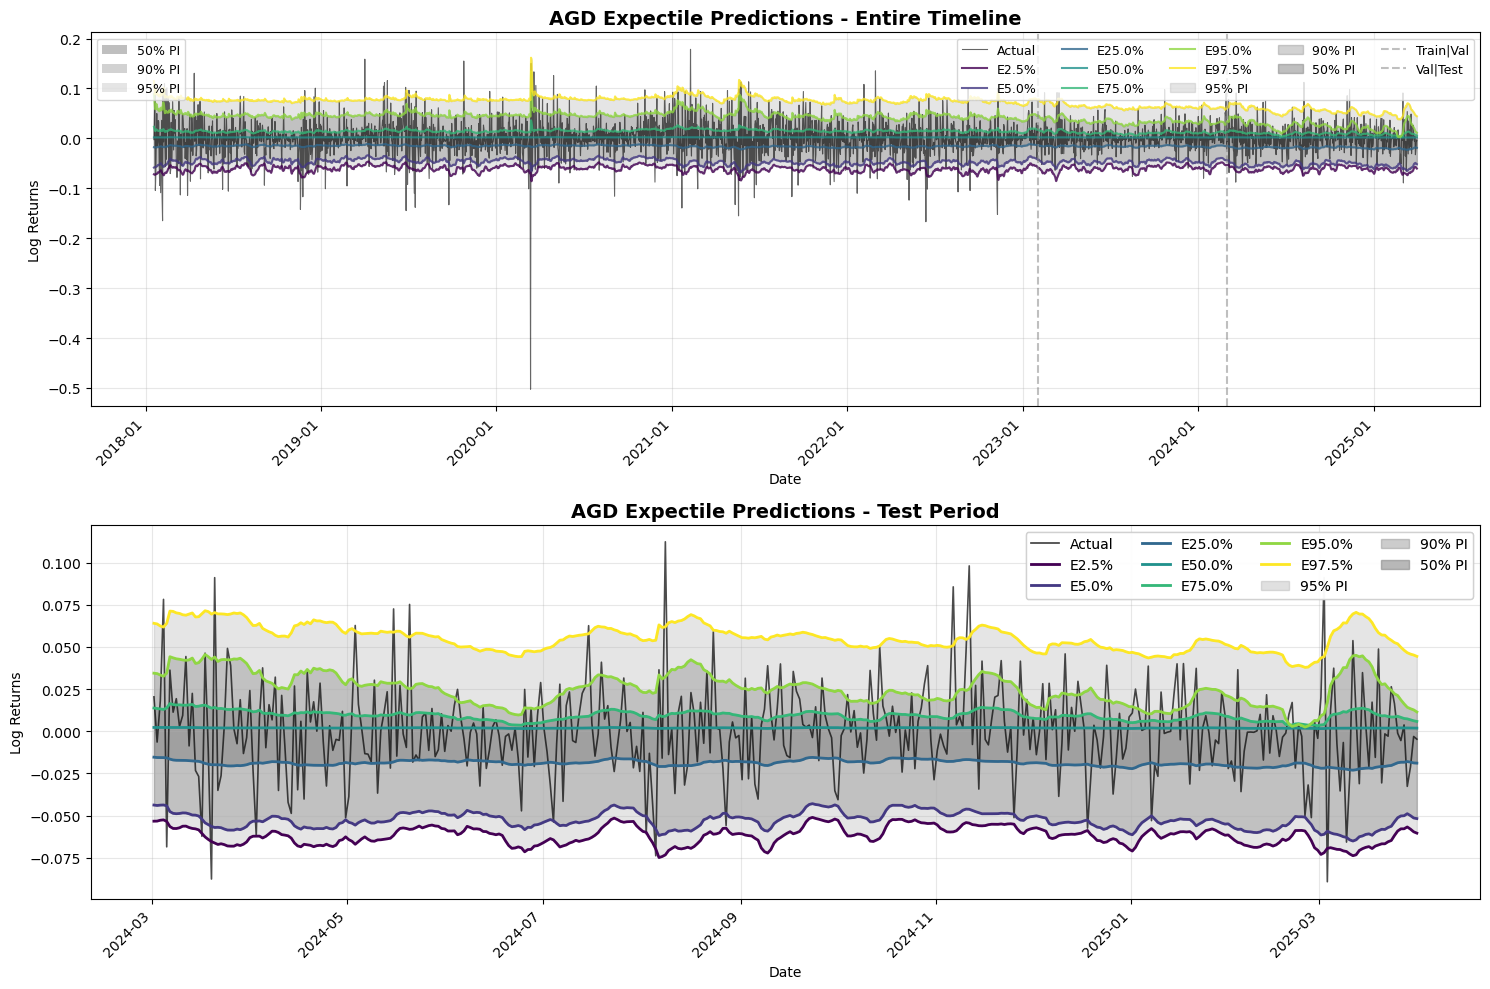


Plots saved to 'agd_timeline_results_layernorm_scheduler.png'


In [321]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 4. Get Best Hyperparameters with LayerNorm
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for tau in best_hyperparams:
        best_hyperparams[tau].update({
            'tau': tau  # Add tau value for each config
        })
    
    return best_hyperparams

# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Simple Plot Functions
# -------------------------
def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, expectiles):
    """
    Two plots (entire timeline & test period) with:
      - seq_length-aware dates (seq_length=3)
      - viridis line colors for expectiles
      - grey shaded PIs (50/90/95) exactly like your ALD update
      - same legends, alphas, and time formatting
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch

    # --- sequence length & date alignment ---
    seq_length = 3
    first_sequence_original_row = seq_length

    # date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        date_series = pd.to_datetime(df_copy["Date"])
    else:
        date_series = pd.to_datetime(df_copy.index)

    n_all = int(len(y_all))
    n_test = int(len(y_test))
    test_start_idx = n_all - n_test

    def safe_get(idx):
        return date_series.iloc[idx] if idx < len(date_series) else date_series.iloc[-1]

    all_dates = pd.to_datetime([safe_get(first_sequence_original_row + i) for i in range(n_all)])
    test_dates = pd.to_datetime([safe_get(first_sequence_original_row + test_start_idx + i) for i in range(n_test)])

    # colors & intervals (match ALD update)
    line_colors = plt.cm.viridis(np.linspace(0, 1, len(expectiles)))
    interval_color = 'gray'
    HAVE_025_975 = (0.025 in expectiles) and (0.975 in expectiles)
    HAVE_005_095 = (0.05  in expectiles) and (0.95  in expectiles)
    HAVE_025_075 = (0.25 in expectiles) and (0.75  in expectiles)

    # figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ---- Plot 1: Entire Timeline ----
    ax1.plot(all_dates, np.asarray(y_all).flatten(), color='k', alpha=0.6, linewidth=0.8, label='Actual')

    # Expectile lines
    for i, tau in enumerate(expectiles):
        ax1.plot(
            all_dates,
            np.asarray(all_predictions[tau]).flatten(),
            color=line_colors[i],
            linewidth=1.5,
            alpha=0.8,
            label=f'E{tau*100:.1f}%'
        )

    # Shaded PIs (entire timeline)
    if HAVE_025_975:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.025]).flatten(),
                         np.asarray(all_predictions[0.975]).flatten(),
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.05]).flatten(),
                         np.asarray(all_predictions[0.95]).flatten(),
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.25]).flatten(),
                         np.asarray(all_predictions[0.75]).flatten(),
                         color=interval_color, alpha=0.5, label='50% PI')

    # split markers
    ax1.axvline(x=all_dates[int(len(y_all)*0.7)], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0],                 color='gray', linestyle='--', alpha=0.5, label='Val|Test')

    ax1.set_title('AGD Expectile Predictions - Entire Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Log Returns')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Build legend to include PI patches only once
    pi_handles = []
    if HAVE_025_075:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.5, label='50% PI'))
    if HAVE_005_095:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.35, label='90% PI'))
    if HAVE_025_975:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.2, label='95% PI'))

    # Combine line legend + PI legend
    leg1 = ax1.legend(loc='upper right', ncol=5, fontsize=9)
    if pi_handles:
        ax1.add_artist(leg1)
        ax1.legend(handles=pi_handles, loc='upper left', fontsize=9, frameon=True)

    # ---- Plot 2: Test Period Only ----
    ax2.plot(test_dates, np.asarray(y_test).flatten(), 'k-', alpha=0.7, linewidth=1.2, label='Actual')

    for i, tau in enumerate(expectiles):
        y_pred_test = np.asarray(all_predictions[tau]).flatten()[test_start_idx:]
        ax2.plot(test_dates, y_pred_test, color=line_colors[i], linewidth=2, label=f'E{tau*100:.1f}%')

    # Shaded PIs (test period)
    if HAVE_025_975:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.025]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.975]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.05]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.95]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.25]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.75]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.5, label='50% PI')

    ax2.set_title('AGD Expectile Predictions - Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Log Returns')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # Legend
    leg2 = ax2.legend(loc='upper right', ncol=4)
    if pi_handles:
        ax2.add_artist(leg2)

    plt.tight_layout()
    plt.savefig('agd_timeline_results_layernorm_scheduler.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 8. Main Function
# -------------------------
def run_single_agd_models(X_all, y_all, df_copy, expectiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Train one model per expectile level and visualize results"""
    
    # Set seed
    set_all_seeds(2025)
    
    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print("="*60)
    print("AGD EXPECTILE REGRESSION - WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)
    
    # Get best hyperparameters
    best_hyperparams = get_best_hyperparameters_from_agd_tuning()
    
    # Store all predictions for entire dataset
    all_predictions = {}
    
    # Train model for each expectile
    for tau in expectiles:
        print(f"\nTraining expectile {tau*100:.1f}%...")
        
        # Get config
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]
        
        # Train model
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)
        
        # Get predictions for entire dataset
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()
        
        all_predictions[tau] = y_pred_all
        
        # Calculate test coverage
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test)
            expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test)
            expected = 1 - tau
        
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")
    
    # Create simple timeline plots
    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, expectiles)
    
    print("\nPlots saved to 'agd_timeline_results_layernorm_scheduler.png'")
    
    return all_predictions

# -------------------------
# 9. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run single model evaluation
    all_predictions = run_single_agd_models(X_all, y_all, df_copy)

### formatting for thesis

AGD EXPECTILE REGRESSION - WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Training expectile 2.5%...
  Test Coverage: 0.015 (Expected: 0.025)

Training expectile 5.0%...
  Test Coverage: 0.033 (Expected: 0.050)

Training expectile 25.0%...
  Test Coverage: 0.199 (Expected: 0.250)

Training expectile 50.0%...
  Test Coverage: 0.548 (Expected: 0.500)

Training expectile 75.0%...
  Test Coverage: 0.338 (Expected: 0.250)

Training expectile 95.0%...
  Test Coverage: 0.164 (Expected: 0.050)

Training expectile 97.5%...
  Test Coverage: 0.025 (Expected: 0.025)


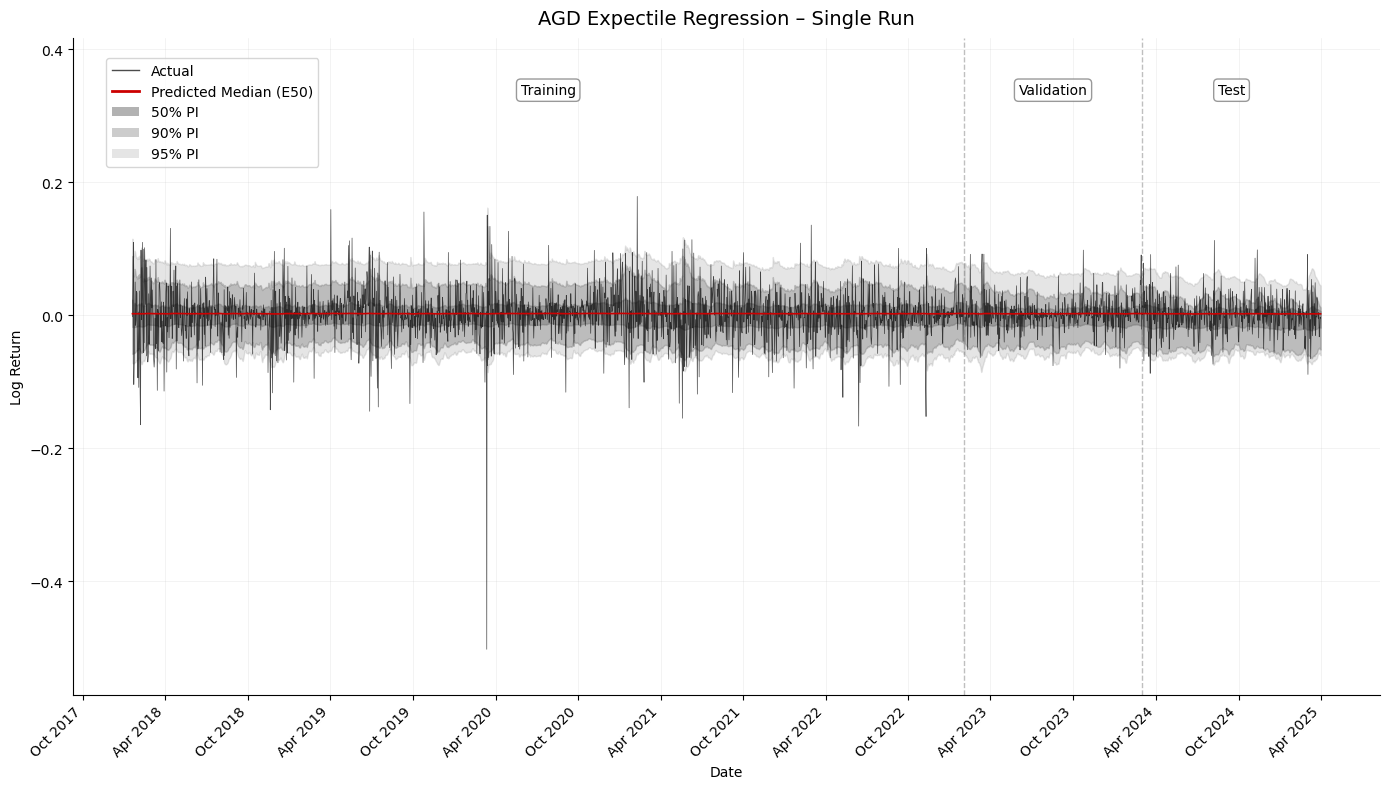

Full timeline plot saved as 'agd_timeline_thesis.png'


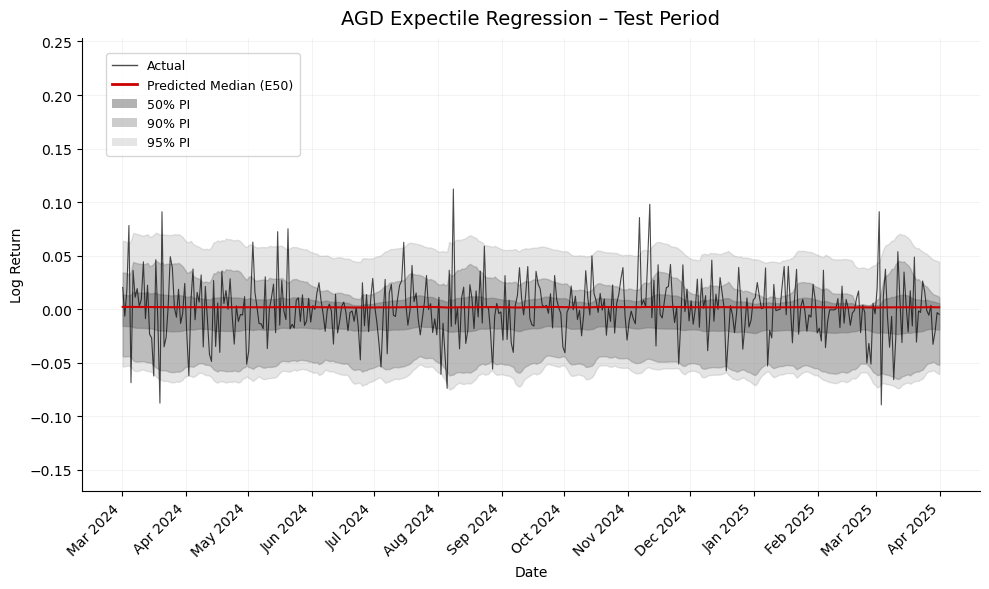

Test period plot saved as 'agd_testline_thesis.png'

Plots saved to 'agd_timeline_results_layernorm_scheduler.png'


In [335]:
# Replace the plot_simple_timelines function in Document 4 with this:

def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, expectiles):
    """
    Two plots (entire timeline & test period) with thesis-style formatting
    - seq_length-aware dates (seq_length=3)
    - grey shaded PIs (50/90/95)
    - central line, legend formatting, and styling from thesis format
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    # --- Dates aligned to end of each seq ---
    seq_length = 3
    first_seq_row = seq_length

    # Get date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(0.7 * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]

    # Central line: E50 if possible; else mid(E25,E75); else mean
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[tau]).flatten() for tau in expectiles])
        central_full = stacks.mean(axis=1)

    # Bands
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05 in all_predictions) and (0.95 in all_predictions)
    have_50 = (0.25 in all_predictions) and (0.75 in all_predictions)
    
    if have_95:
        e0025_full = np.asarray(all_predictions[0.025]).flatten()
        e0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        e0050_full = np.asarray(all_predictions[0.05]).flatten()
        e0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        e0250_full = np.asarray(all_predictions[0.25]).flatten()
        e0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size: train_size + val_size + test_size]
    
    if have_95:
        e0025_train, e0025_val, e0025_test = e0025_full[:train_size], e0025_full[train_size: train_size + val_size], e0025_full[train_size + val_size: train_size + val_size + test_size]
        e0975_train, e0975_val, e0975_test = e0975_full[:train_size], e0975_full[train_size: train_size + val_size], e0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        e0050_train, e0050_val, e0050_test = e0050_full[:train_size], e0050_full[train_size: train_size + val_size], e0050_full[train_size + val_size: train_size + val_size + test_size]
        e0950_train, e0950_val, e0950_test = e0950_full[:train_size], e0950_full[train_size: train_size + val_size], e0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        e0250_train, e0250_val, e0250_test = e0250_full[:train_size], e0250_full[train_size: train_size + val_size], e0250_full[train_size + val_size: train_size + val_size + test_size]
        e0750_train, e0750_val, e0750_test = e0750_full[:train_size], e0750_full[train_size: train_size + val_size], e0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors
    actual_color = '#000000'
    pred_color = '#CC0000'
    pi_color = '#808080'

    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (E50)')
    if have_95: ax.fill_between(train_dates, e0025_train, e0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, e0050_train, e0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, e0250_train, e0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, e0025_val, e0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, e0050_val, e0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, e0250_val, e0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, e0025_test, e0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, e0050_test, e0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, e0250_test, e0750_test, color=pi_color, alpha=0.6)

    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (E50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    ax.set_title('AGD Expectile Regression – Single Run', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('thesis_agd_timelinebefore.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as 'agd_timeline_thesis.png'")

    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4*y_rng_t, y_max_t + 0.7*y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (E50)')
    if have_95: ax.fill_between(test_dates, e0025_test, e0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, e0050_test, e0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, e0250_test, e0750_test, color=pi_color, alpha=0.6, label='50% PI')

    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (E50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('AGD Expectile Regression – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('thesis_agd_testlinebefore.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as 'agd_testline_thesis.png'")

# Log-returns view with gray color scheme and external legend
# Run the model training and plotting
# If running as a script
if __name__ == "__main__":
       # Assuming X_all, y_all, and df_copy are already defined
    all_predictions = run_single_agd_models(X_all, y_all, df_copy)

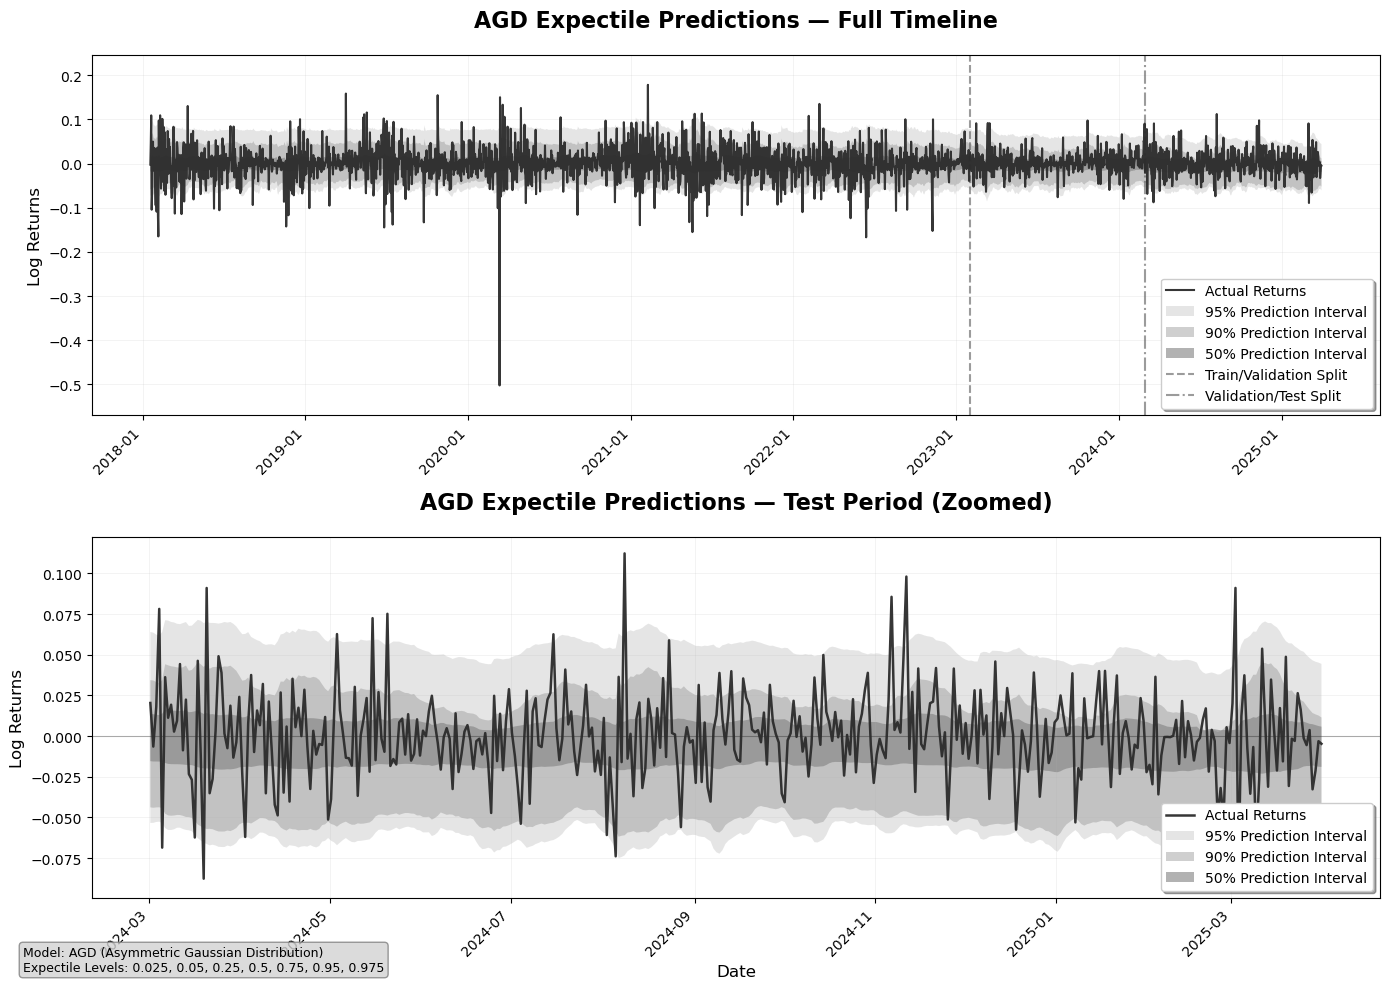

In [233]:
def plot_expectiles_gray(all_predictions, y_all, y_test, df_copy, expectiles,
                         title_prefix="AGD Expectile Predictions",
                         seq_length=3, save_path='agd_timeline_results_gray.png'):
    """
    Two-panel plot (entire timeline + test) with:
      - black actuals
      - gray color scheme for prediction bands
      - ONLY shaded 50/90/95% bands (no median line)
      - Legend placed at bottom right corner
    """
    all_dates, test_dates, test_start_idx = _align_dates_for_seq(df_copy, y_all, y_test, seq_length)

    y_all_np  = np.asarray(y_all).flatten()
    y_test_np = np.asarray(y_test).flatten()

    # Create figure with adjusted size for legend
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Gray color scheme - using different shades
    gray_dark = '#2b2b2b'      # Almost black for actual line
    gray_band_50 = '#808080'   # Medium gray for 50% band
    gray_band_90 = '#a0a0a0'   # Light gray for 90% band  
    gray_band_95 = '#c0c0c0'   # Very light gray for 95% band
    gray_splits = '#595959'    # Dark gray for split lines

    # Which bands exist?
    HAVE_025_975 = (0.025 in expectiles) and (0.975 in expectiles)
    HAVE_05_95   = (0.05  in expectiles) and (0.95  in expectiles)
    HAVE_25_75   = (0.25 in expectiles) and (0.75 in expectiles)

    # ---------- Panel 1: Entire timeline ----------
    ax1.plot(all_dates, y_all_np, color=gray_dark, alpha=0.95, linewidth=1.5, label='Actual Returns', zorder=5)

    def _fb(ax, lo, hi, color, alpha, label):
        ax.fill_between(all_dates,
                        np.asarray(all_predictions[lo]).flatten(),
                        np.asarray(all_predictions[hi]).flatten(),
                        color=color, alpha=alpha, label=label, edgecolor='none', zorder=1)

    # Plot bands from widest to narrowest (so they layer properly)
    if HAVE_025_975:
        _fb(ax1, 0.025, 0.975, color=gray_band_95, alpha=0.4, label='95% Prediction Interval')
    if HAVE_05_95:
        _fb(ax1, 0.05, 0.95, color=gray_band_90, alpha=0.5, label='90% Prediction Interval')
    if HAVE_25_75:
        _fb(ax1, 0.25, 0.75, color=gray_band_50, alpha=0.6, label='50% Prediction Interval')

    # Split markers with better styling
    train_split = int(len(y_all_np) * 0.70)
    ax1.axvline(x=all_dates[train_split], color=gray_splits, linestyle='--', 
                alpha=0.6, linewidth=1.5, label='Train/Validation Split')
    ax1.axvline(x=test_dates[0], color=gray_splits, linestyle='-.', 
                alpha=0.6, linewidth=1.5, label='Validation/Test Split')

    # Improved title and labels
    ax1.set_title(f'{title_prefix} — Full Timeline', fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Log Returns', fontsize=12)
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Set y-axis limits for better visualization
    y_margin = 0.1 * (y_all_np.max() - y_all_np.min())
    ax1.set_ylim(y_all_np.min() - y_margin, y_all_np.max() + y_margin)

    # Place legend at bottom right corner
    ax1.legend(loc='lower right', fontsize=10, 
               frameon=True, fancybox=True, shadow=True)

    # ---------- Panel 2: Test period ----------
    ax2.plot(test_dates, y_test_np, color=gray_dark, alpha=0.95, linewidth=1.8, label='Actual Returns', zorder=5)

    def _fb_test(ax, lo, hi, color, alpha, label):
        ax.fill_between(test_dates,
                        np.asarray(all_predictions[lo]).flatten()[test_start_idx:],
                        np.asarray(all_predictions[hi]).flatten()[test_start_idx:],
                        color=color, alpha=alpha, label=label, edgecolor='none', zorder=1)

    # Plot bands for test period
    if HAVE_025_975:
        _fb_test(ax2, 0.025, 0.975, color=gray_band_95, alpha=0.4, label='95% Prediction Interval')
    if HAVE_05_95:
        _fb_test(ax2, 0.05, 0.95, color=gray_band_90, alpha=0.5, label='90% Prediction Interval')
    if HAVE_25_75:
        _fb_test(ax2, 0.25, 0.75, color=gray_band_50, alpha=0.6, label='50% Prediction Interval')

    # Add zero line for reference
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8, zorder=2)

    ax2.set_title(f'{title_prefix} — Test Period (Zoomed)', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Log Returns', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # Place legend at bottom right corner
    ax2.legend(loc='lower right', fontsize=10, 
               frameon=True, fancybox=True, shadow=True)

    # Adjust layout
    plt.tight_layout()
    
    # Add a text box with model information at bottom left
    textstr = f'Model: AGD (Asymmetric Gaussian Distribution)\nExpectile Levels: {", ".join(map(str, expectiles))}'
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='gray')
    fig.text(0.02, 0.02, textstr, transform=fig.transFigure, fontsize=9,
             verticalalignment='bottom', horizontalalignment='left', bbox=props)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig


# Usage example:
# Ensure you have these splits first:
# X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

# Log-returns view with gray color scheme and external legend
fig = plot_expectiles_gray(
    all_predictions=all_predictions,
    y_all=y_all,
    y_test=y_test,
    df_copy=df_copy,
    expectiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
    title_prefix="AGD Expectile Predictions",
    save_path="agd_expectile_results_gray.png"
)

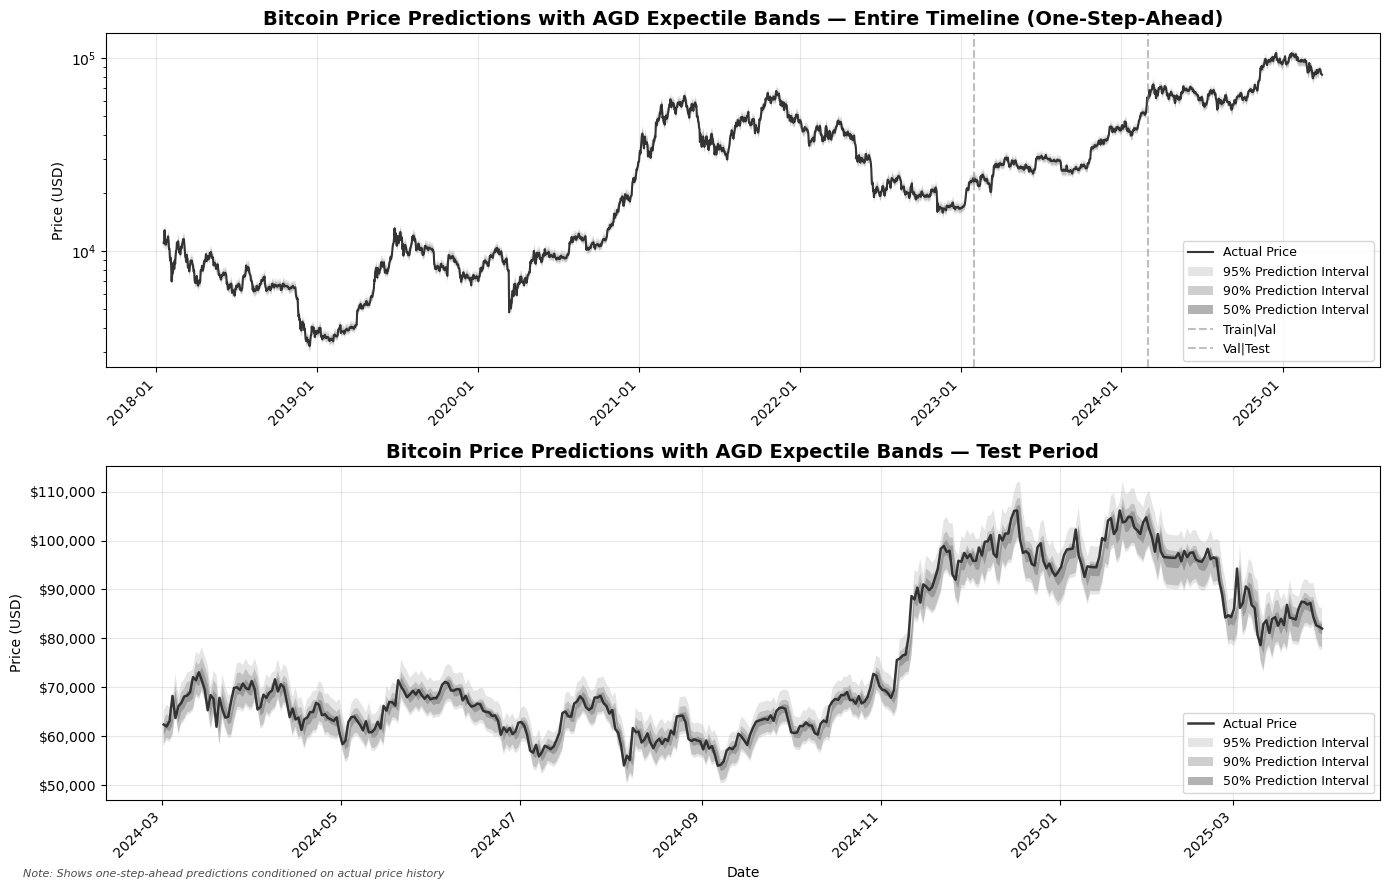

Initial price: $10,988.79
Final actual price: $82,002.02
Final median predicted price: $82,540.72
Price range at end: $77,557.44 - $86,129.61

Model uses 3 days of history to predict next day
Total predictions: 2630
Test predictions: 396


In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_expectiles_price_corrected(all_predictions, y_all, y_test, df_copy, expectiles,
                                   initial_price=None,
                                   title_prefix="AGD Price Predictions with Expectile Bands",
                                   seq_length=3, save_path='agd_price_results_corrected.png'):
    """
    Corrected version for models that use seq_length days to predict next day.
    This version properly handles one-step-ahead predictions only.
    
    IMPORTANT: This assumes all_predictions contains one-step-ahead predictions
    where each prediction at index i represents the predicted log return for day i+1
    given the actual data up to day i.
    """
    
    # Align dates
    all_dates, test_dates, test_start_idx = _align_dates_for_seq(df_copy, y_all, y_test, seq_length)
    
    # Convert to numpy arrays
    y_all_np = np.asarray(y_all).flatten()
    y_test_np = np.asarray(y_test).flatten()
    
    # Get initial price (price just before the first prediction)
    if initial_price is None:
        if 'Close' in df_copy.columns:
            initial_price = df_copy['Close'].iloc[seq_length-1]
        else:
            raise ValueError("Please provide initial_price or ensure df_copy has a 'Close' column")
    
    # Convert actual log returns to prices
    # Starting from the initial price, apply each log return sequentially
    actual_prices = np.zeros(len(y_all_np))
    actual_prices[0] = initial_price * np.exp(y_all_np[0])
    for i in range(1, len(y_all_np)):
        actual_prices[i] = actual_prices[i-1] * np.exp(y_all_np[i])
    
    # Convert expectile predictions to prices
    # Each prediction is a one-step-ahead forecast
    price_predictions = {}
    for exp_level in expectiles:
        if exp_level in all_predictions:
            pred_log_returns = np.asarray(all_predictions[exp_level]).flatten()
            pred_prices = np.zeros(len(pred_log_returns))
            
            # First prediction: from initial price
            pred_prices[0] = initial_price * np.exp(pred_log_returns[0])
            
            # Subsequent predictions: each uses the actual price from previous period
            # This represents one-step-ahead predictions conditioned on actual history
            for i in range(1, len(pred_log_returns)):
                pred_prices[i] = actual_prices[i-1] * np.exp(pred_log_returns[i])
            
            price_predictions[exp_level] = pred_prices
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9))
    
    # Gray color scheme to match your preference
    gray_dark = '#2b2b2b'
    gray_band_50 = '#808080'
    gray_band_90 = '#a0a0a0'
    gray_band_95 = '#c0c0c0'
    
    # Check which bands exist
    HAVE_025_975 = (0.025 in expectiles) and (0.975 in expectiles)
    HAVE_05_95 = (0.05 in expectiles) and (0.95 in expectiles)
    HAVE_25_75 = (0.25 in expectiles) and (0.75 in expectiles)
    
    # ---------- Panel 1: Entire timeline ----------
    ax1.plot(all_dates, actual_prices, color=gray_dark, alpha=0.95, linewidth=1.5, label='Actual Price')
    
    def _fb(ax, lo, hi, color, alpha, label):
        if lo in price_predictions and hi in price_predictions:
            ax.fill_between(all_dates,
                           price_predictions[lo],
                           price_predictions[hi],
                           color=color, alpha=alpha, label=label, edgecolor='none')
    
    # Plot bands from widest to narrowest
    if HAVE_025_975:
        _fb(ax1, 0.025, 0.975, color=gray_band_95, alpha=0.4, label='95% Prediction Interval')
    if HAVE_05_95:
        _fb(ax1, 0.05, 0.95, color=gray_band_90, alpha=0.5, label='90% Prediction Interval')
    if HAVE_25_75:
        _fb(ax1, 0.25, 0.75, color=gray_band_50, alpha=0.6, label='50% Prediction Interval')
    
    # Split markers
    train_split = int(len(y_all_np) * 0.70)
    ax1.axvline(x=all_dates[train_split], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0], color='gray', linestyle='--', alpha=0.5, label='Val|Test')
    
    ax1.set_title(f'{title_prefix} — Entire Timeline (One-Step-Ahead)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (USD)')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Format y-axis for prices
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Set y-axis to log scale for Bitcoin prices
    ax1.set_yscale('log')
    
    # Legend at bottom right
    ax1.legend(loc='lower right', fontsize=9, frameon=True)
    
    # ---------- Panel 2: Test period ----------
    test_actual_prices = actual_prices[test_start_idx:]
    ax2.plot(test_dates, test_actual_prices, color=gray_dark, alpha=0.95, linewidth=1.8, label='Actual Price')
    
    def _fb_test(ax, lo, hi, color, alpha, label):
        if lo in price_predictions and hi in price_predictions:
            ax.fill_between(test_dates,
                           price_predictions[lo][test_start_idx:],
                           price_predictions[hi][test_start_idx:],
                           color=color, alpha=alpha, label=label, edgecolor='none')
    
    if HAVE_025_975:
        _fb_test(ax2, 0.025, 0.975, color=gray_band_95, alpha=0.4, label='95% Prediction Interval')
    if HAVE_05_95:
        _fb_test(ax2, 0.05, 0.95, color=gray_band_90, alpha=0.5, label='90% Prediction Interval')
    if HAVE_25_75:
        _fb_test(ax2, 0.25, 0.75, color=gray_band_50, alpha=0.6, label='50% Prediction Interval')
    
    ax2.set_title(f'{title_prefix} — Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price (USD)')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Format y-axis for prices
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Legend at bottom right
    ax2.legend(loc='lower right', fontsize=9, frameon=True)
    
    # Add note about prediction type
    fig.text(0.02, 0.02, 'Note: Shows one-step-ahead predictions conditioned on actual price history', 
             transform=fig.transFigure, fontsize=8, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"Initial price: ${initial_price:,.2f}")
    print(f"Final actual price: ${actual_prices[-1]:,.2f}")
    if 0.5 in price_predictions:
        print(f"Final median predicted price: ${price_predictions[0.5][-1]:,.2f}")
        print(f"Price range at end: ${price_predictions[0.025][-1]:,.2f} - ${price_predictions[0.975][-1]:,.2f}")
    
    # Additional diagnostic
    print(f"\nModel uses {seq_length} days of history to predict next day")
    print(f"Total predictions: {len(y_all_np)}")
    print(f"Test predictions: {len(y_test_np)}")
    
    return fig, actual_prices, price_predictions


def plot_true_multistep_price_forecast(model, X_test, y_test, df_copy, expectiles, 
                                      initial_price, seq_length=3, 
                                      forecast_steps=30,
                                      save_path='agd_true_multistep_forecast.png'):
    """
    This function shows TRUE multi-step ahead forecasting where predictions
    are fed back as inputs for subsequent predictions.
    
    WARNING: This compounds prediction errors and typically shows much wider
    uncertainty bands over time.
    
    Parameters:
    -----------
    model : trained model with predict_expectiles method
    X_test : test features
    y_test : test targets (for comparison)
    forecast_steps : how many steps ahead to forecast
    """
    
    # Get the last seq_length actual returns to start the forecast
    last_returns = X_test[-1].copy()  # Shape: (seq_length, n_features)
    
    # Initialize storage for multi-step predictions
    multistep_predictions = {exp: [] for exp in expectiles}
    
    # Get dates for forecast
    last_date = df_copy.index[-len(y_test) + len(X_test) - 1]
    forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='D')[1:]
    
    # Perform multi-step forecasting
    for step in range(forecast_steps):
        # Predict next step for all expectiles
        step_predictions = {}
        for exp in expectiles:
            # Model predicts using last seq_length returns
            pred = model.predict_expectile(last_returns.reshape(1, seq_length, -1), exp)
            step_predictions[exp] = pred[0]
            multistep_predictions[exp].append(pred[0])
        
        # Update the input sequence with median prediction
        # Roll the sequence and insert the new prediction
        last_returns[:-1] = last_returns[1:]
        last_returns[-1, 0] = step_predictions[0.5]  # Use median for next input
        
        # Note: If your model uses other features beyond returns, 
        # you'd need to generate/predict those too
    
    # Convert to prices
    multistep_prices = {}
    for exp in expectiles:
        returns = np.array(multistep_predictions[exp])
        # Each subsequent price depends on all previous predicted returns
        cumulative_returns = np.cumsum(returns)
        multistep_prices[exp] = initial_price * np.exp(cumulative_returns)
    
    # Plot
    plt.figure(figsize=(12, 7))
    
    # Plot actual prices up to forecast point
    actual_dates = df_copy.index[-len(y_test):]
    actual_returns = np.array(y_test).flatten()
    actual_prices = initial_price * np.exp(np.cumsum(actual_returns))
    
    plt.plot(actual_dates, actual_prices, 'k-', linewidth=2, label='Actual Prices')
    
    # Plot forecast bands
    if 0.025 in expectiles and 0.975 in expectiles:
        plt.fill_between(forecast_dates, 
                        multistep_prices[0.025], 
                        multistep_prices[0.975],
                        alpha=0.2, color='gray', label='95% Forecast Interval')
    
    if 0.05 in expectiles and 0.95 in expectiles:
        plt.fill_between(forecast_dates,
                        multistep_prices[0.05],
                        multistep_prices[0.95],
                        alpha=0.3, color='gray', label='90% Forecast Interval')
    
    if 0.25 in expectiles and 0.75 in expectiles:
        plt.fill_between(forecast_dates,
                        multistep_prices[0.25],
                        multistep_prices[0.75],
                        alpha=0.4, color='gray', label='50% Forecast Interval')
    
    if 0.5 in expectiles:
        plt.plot(forecast_dates, multistep_prices[0.5], 'b--', 
                linewidth=2, label='Median Forecast')
    
    plt.axvline(x=actual_dates[-1], color='red', linestyle=':', alpha=0.7, 
                label='Forecast Start')
    
    plt.title(f'True Multi-Step Price Forecast ({forecast_steps} days ahead)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return multistep_prices


# Usage:
fig, actual_prices, price_predictions = plot_expectiles_price_corrected(
    all_predictions=all_predictions,
    y_all=y_all,
    y_test=y_test,
    df_copy=df_copy,
    expectiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
    initial_price=None,
    title_prefix="Bitcoin Price Predictions with AGD Expectile Bands",
    save_path="agd_price_results_corrected.png"
)

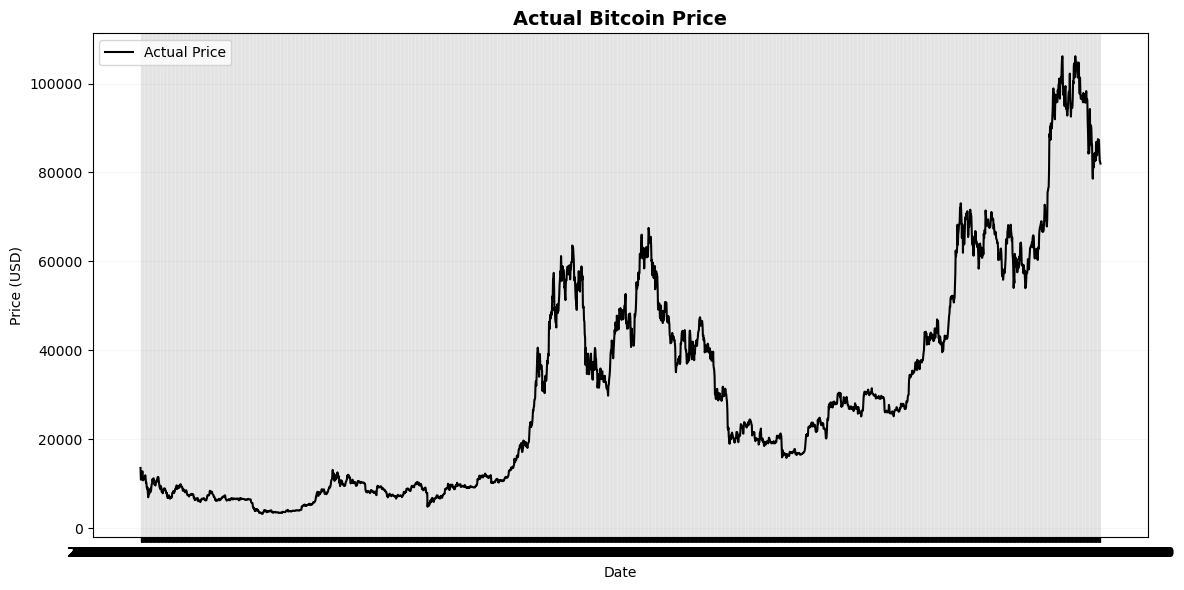

In [223]:
plt.figure(figsize=(12,6))
plt.plot(df_copy["Date"], df_copy["Close"], color="black", linewidth=1.5, label="Actual Price")
plt.title("Actual Bitcoin Price", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Grid search on tau

τ grid created with 200 points.
Range: [0.0010, 0.9990]
Gap excluded: (0.4, 0.6)

ARCHITECTURE: Optimized for τ=0.025

Grid search configuration:
  Architecture: LSTM(102) → Dense(16) → Dense(41) → 1
  Activation: elu
  LayerNorm: True
  Optimizer: adam with LR=0.0049
  Original epochs: 2000
  Progress: 0/200 - τ=0.0010
  Progress: 10/200 - τ=0.0413
  Progress: 20/200 - τ=0.0816
  Progress: 30/200 - τ=0.1219
  Progress: 40/200 - τ=0.1622
  Progress: 50/200 - τ=0.2025
  Progress: 60/200 - τ=0.2428
  Progress: 70/200 - τ=0.2831
  Progress: 80/200 - τ=0.3234
  Progress: 90/200 - τ=0.3637
  Progress: 100/200 - τ=0.6000
  Progress: 110/200 - τ=0.6403
  Progress: 120/200 - τ=0.6806
  Progress: 130/200 - τ=0.7209
  Progress: 140/200 - τ=0.7612
  Progress: 150/200 - τ=0.8015
  Progress: 160/200 - τ=0.8418
  Progress: 170/200 - τ=0.8821
  Progress: 180/200 - τ=0.9224
  Progress: 190/200 - τ=0.9627

Saved results to tau_alpha_mapping_AGD_arch_0p025.csv


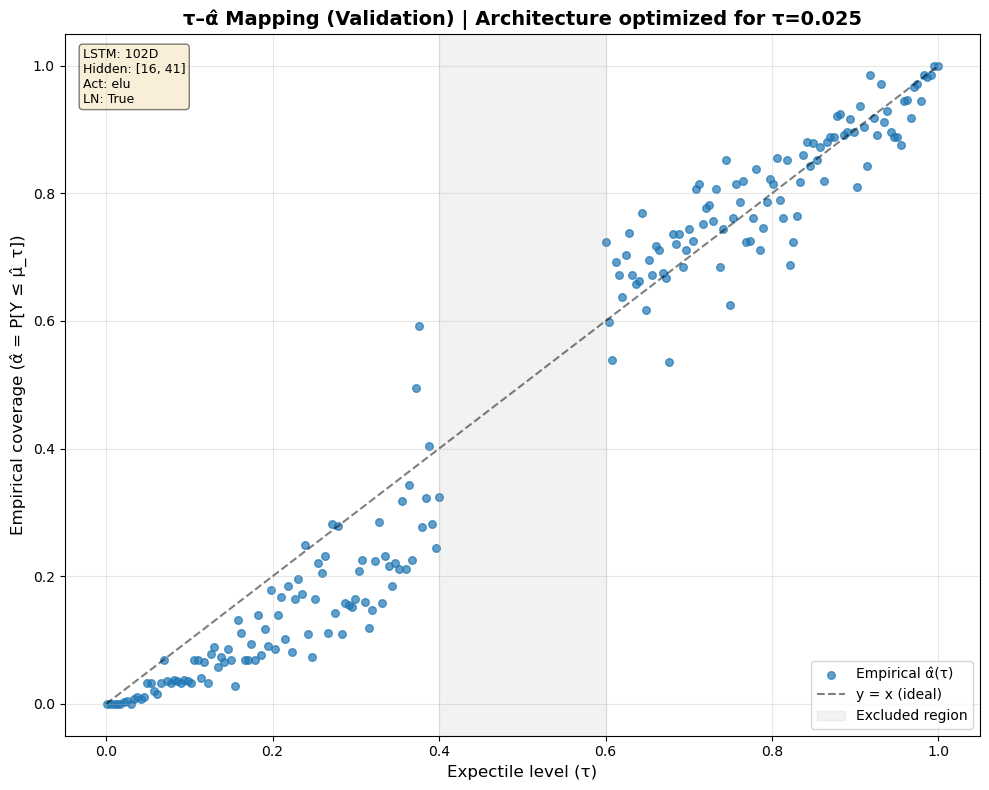


Summary for architecture τ=0.025:
  Mean |τ - α̂|: 0.0583
  Max |τ - α̂|: 0.2156
  Correlation(τ, α̂): 0.9844

ARCHITECTURE: Optimized for τ=0.250

Grid search configuration:
  Architecture: LSTM(87) → Dense(48) → Dense(66) → 1
  Activation: elu
  LayerNorm: True
  Optimizer: adam with LR=0.0089
  Original epochs: 2000
  Progress: 0/200 - τ=0.0010
  Progress: 10/200 - τ=0.0413
  Progress: 20/200 - τ=0.0816
  Progress: 30/200 - τ=0.1219
  Progress: 40/200 - τ=0.1622
  Progress: 50/200 - τ=0.2025
  Progress: 60/200 - τ=0.2428
  Progress: 70/200 - τ=0.2831
  Progress: 80/200 - τ=0.3234
  Progress: 90/200 - τ=0.3637
  Progress: 100/200 - τ=0.6000
  Progress: 110/200 - τ=0.6403
  Progress: 120/200 - τ=0.6806
  Progress: 130/200 - τ=0.7209
  Progress: 140/200 - τ=0.7612
  Progress: 150/200 - τ=0.8015
  Progress: 160/200 - τ=0.8418
  Progress: 170/200 - τ=0.8821
  Progress: 180/200 - τ=0.9224
  Progress: 190/200 - τ=0.9627

Saved results to tau_alpha_mapping_AGD_arch_0p25.csv


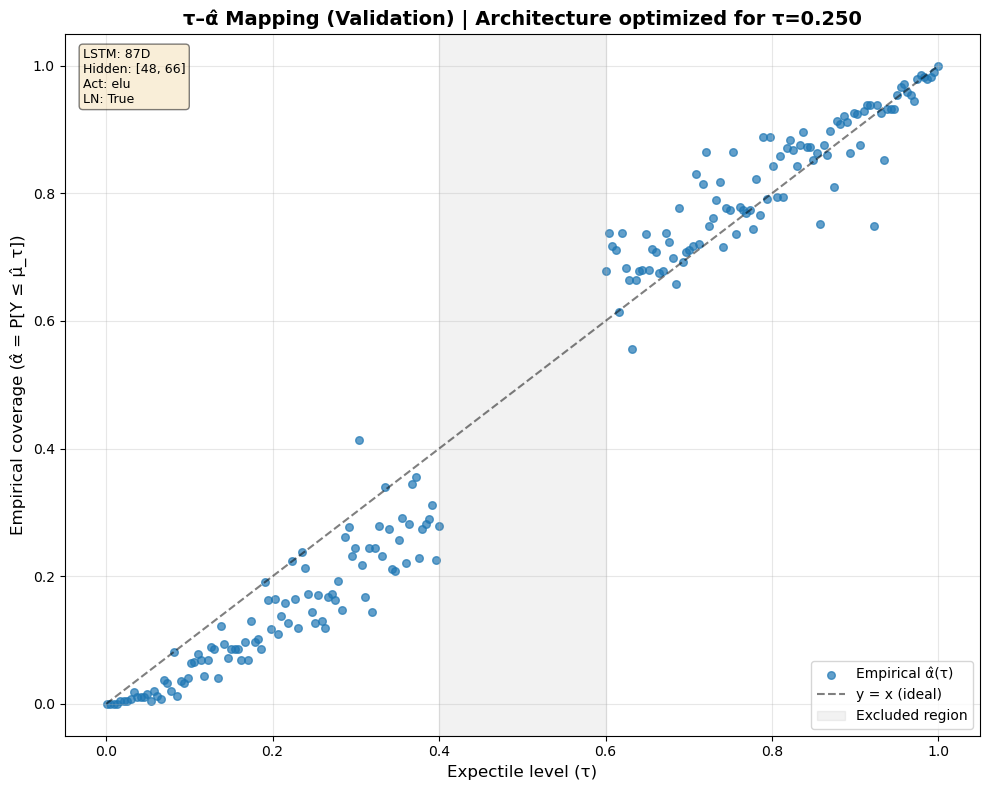


Summary for architecture τ=0.25:
  Mean |τ - α̂|: 0.0521
  Max |τ - α̂|: 0.1747
  Correlation(τ, α̂): 0.9882

✅ Grid search completed successfully!
   - Tested 200 tau values per architecture
   - Results saved for 2 architectures


In [247]:
# ============================================
# τ → α̂ mapping per architecture (coverage)
# 200 τ values in [0,0.4]∪[0.6,1], no lines, per-arch plots
# Using EXACT AGD model architecture from training
# ============================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------
# 1. Import/Define the EXACT model architecture
# -------------------------
# Make sure this matches your trained model EXACTLY
class AsymmetricGaussianExpectile(nn.Module):
    """
    EXACT copy of the AGD model architecture used in training
    """
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 2. Use EXACT loss function
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    EXACT AGD negative log-likelihood used in training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 3. Use EXACT training function
# -------------------------
def train_single_agd_model_for_grid_search(X_train, y_train, X_val, y_val, config):
    """
    EXACT training procedure used in your AGD model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights EXACTLY as in training
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer - EXACT same as training
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler - EXACT same
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training loop - EXACT same
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # For grid search, we might use fewer epochs
    num_epochs = config.get('grid_search_epochs', config['num_epochs'] // 4)  # Can adjust
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 4. Grid search functions
# -------------------------
def make_tau_grid_excluding_gap(n_left=100, n_right=100, gap_lo=0.4, gap_hi=0.6):
    """Create tau grid excluding the gap"""
    left = np.linspace(0.001, gap_lo, n_left, endpoint=True)  # Start from 0.001 to avoid 0
    right = np.linspace(gap_hi, 0.999, n_right, endpoint=True)  # End at 0.999 to avoid 1
    tau_grid = np.concatenate([left, right])
    return np.round(tau_grid, 4)

def empirical_coverage(y_true, y_pred):
    """Calculate empirical coverage P(Y <= y_pred)"""
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    return float(np.mean(y_true <= y_pred))

def tau_alpha_curve_for_one_architecture(X_all, y_all, cfg_base, tau_grid, 
                                         prepare_data_fn, verbose=True,
                                         use_quick_training=False):
    """
    Run grid search for one architecture configuration
    
    Parameters:
    -----------
    X_all, y_all : data
    cfg_base : base configuration from get_best_hyperparameters_from_agd_tuning()
    tau_grid : array of tau values to test
    prepare_data_fn : function to split data (must match training)
    verbose : print progress
    use_quick_training : if True, use fewer epochs for faster grid search
    """
    # Use the EXACT data preparation as training
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_fn(X_all, y_all)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = []
    
    print(f"\nGrid search configuration:")
    print(f"  Architecture: LSTM({cfg_base['lstm_hidden_dim']}) → "
          f"Dense({cfg_base['n_hidden1']}) → Dense({cfg_base['n_hidden2']}) → 1")
    print(f"  Activation: {cfg_base['activation']}")
    print(f"  LayerNorm: {cfg_base.get('use_layer_norm', True)}")
    print(f"  Optimizer: {cfg_base['optimizer']} with LR={cfg_base['lr']}")
    print(f"  Original epochs: {cfg_base['num_epochs']}")
    
    for i, tau in enumerate(tau_grid):
        if verbose and i % 10 == 0:
            print(f"  Progress: {i}/{len(tau_grid)} - τ={tau:.4f}")
        
        # Create config for this tau
        cfg = cfg_base.copy()
        cfg['tau'] = float(tau)
        cfg['input_dim'] = X_train.shape[2]
        
        # Optionally reduce epochs for grid search
        if use_quick_training:
            cfg['grid_search_epochs'] = min(500, cfg['num_epochs'] // 4)
            cfg['patience'] = min(20, cfg['patience'] // 2)
        
        # Train model with EXACT same procedure
        model = train_single_agd_model_for_grid_search(
            X_train, y_train, X_val, y_val, cfg
        )
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            X_val_t = torch.FloatTensor(X_val).to(device)
            yhat_val = model(X_val_t).cpu().numpy().flatten()
        
        # Calculate empirical coverage
        alpha_hat = empirical_coverage(y_val, yhat_val)
        results.append({
            'tau': float(tau),
            'alpha_hat': alpha_hat,
            'val_size': len(y_val)
        })
    
    df_map = pd.DataFrame(results).sort_values('tau').reset_index(drop=True)
    return df_map

def plot_tau_alpha_scatter_improved(df_map, arch_key, save_path=None):
    """Enhanced plot with architecture details"""
    plt.figure(figsize=(10, 8))
    
    # Main scatter plot
    plt.scatter(df_map['tau'], df_map['alpha_hat'], 
                s=30, alpha=0.7, label='Empirical α̂(τ)')
    
    # Reference line
    grid = np.linspace(0, 1, 201)
    plt.plot(grid, grid, 'k--', linewidth=1.5, alpha=0.5, label='y = x (ideal)')
    
    # Add gap region
    plt.axvspan(0.4, 0.6, alpha=0.1, color='gray', label='Excluded region')
    
    plt.xlabel('Expectile level (τ)', fontsize=12)
    plt.ylabel('Empirical coverage (α̂ = P[Y ≤ μ̂_τ])', fontsize=12)
    plt.title(f'τ–α̂ Mapping (Validation) | Architecture optimized for τ={arch_key:.3f}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    
    # Add text box with architecture details
    best_hparams = get_best_hyperparameters_from_agd_tuning()
    cfg = best_hparams[arch_key]
    textstr = f'LSTM: {cfg["lstm_hidden_dim"]}D\n'
    textstr += f'Hidden: [{cfg["n_hidden1"]}, {cfg["n_hidden2"]}]\n'
    textstr += f'Act: {cfg["activation"]}\n'
    textstr += f'LN: {cfg.get("use_layer_norm", True)}'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 5. Main grid search execution
# -------------------------
if __name__ == "__main__":
    # The functions should already be defined in your environment
    # If not, make sure you've run the cells that define:
    # - set_all_seeds
    # - prepare_data
    # - get_best_hyperparameters_from_agd_tuning
    
    # Set seed for reproducibility
    set_all_seeds(2025)
    
    # Create tau grid
    tau_grid = make_tau_grid_excluding_gap(n_left=100, n_right=100, gap_lo=0.4, gap_hi=0.6)
    print(f"τ grid created with {len(tau_grid)} points.")
    print(f"Range: [{tau_grid.min():.4f}, {tau_grid.max():.4f}]")
    print(f"Gap excluded: (0.4, 0.6)")
    
    # Get architecture configurations
    best_hparams = get_best_hyperparameters_from_agd_tuning()
    
    # Select architectures to test
    selected_archs = [0.025, 0.25]  # Two different architectures
    
    # Store results
    all_results = {}
    
    for arch_key in selected_archs:
        print("\n" + "="*80)
        print(f"ARCHITECTURE: Optimized for τ={arch_key:.3f}")
        print("="*80)
        
        # Get base configuration
        base_cfg = best_hparams[arch_key]
        
        # Run grid search
        df_map = tau_alpha_curve_for_one_architecture(
            X_all=X_all,
            y_all=y_all,
            cfg_base=base_cfg,
            tau_grid=tau_grid,
            prepare_data_fn=prepare_data,  # Use EXACT same data split
            verbose=True,
            use_quick_training=True  # Set False for full training
        )
        
        # Save results
        csv_name = f"tau_alpha_mapping_AGD_arch_{str(arch_key).replace('.', 'p')}.csv"
        df_map.to_csv(csv_name, index=False)
        print(f"\nSaved results to {csv_name}")
        
        # Save to dictionary
        all_results[arch_key] = df_map
        
        # Create plot
        plot_path = f"tau_alpha_plot_AGD_arch_{str(arch_key).replace('.', 'p')}.png"
        plot_tau_alpha_scatter_improved(df_map, arch_key, save_path=plot_path)
        
        # Print summary statistics
        print(f"\nSummary for architecture τ={arch_key}:")
        print(f"  Mean |τ - α̂|: {np.mean(np.abs(df_map['tau'] - df_map['alpha_hat'])):.4f}")
        print(f"  Max |τ - α̂|: {np.max(np.abs(df_map['tau'] - df_map['alpha_hat'])):.4f}")
        print(f"  Correlation(τ, α̂): {np.corrcoef(df_map['tau'], df_map['alpha_hat'])[0,1]:.4f}")
    
    print("\n✅ Grid search completed successfully!")
    print(f"   - Tested {len(tau_grid)} tau values per architecture")
    print(f"   - Results saved for {len(selected_archs)} architectures")

In [243]:
# ============================================
# τ → α̂ mapping per architecture (coverage)
# 200 τ values in [0,0.4]∪[0.6,1], no lines, per-arch plots (ONLY 2 architectures)
# ============================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def make_tau_grid_excluding_gap(n_left=100, n_right=100, gap_lo=0.4, gap_hi=0.6):
    left = np.linspace(0.0, gap_lo, n_left, endpoint=True)
    right = np.linspace(gap_hi, 1.0, n_right, endpoint=True)
    tau_grid = np.concatenate([left, right])
    tau_grid = np.clip(tau_grid, 1e-6, 1 - 1e-6)
    return np.round(tau_grid, 4)

def empirical_coverage(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    return float(np.mean(y_true <= y_pred))

def tau_alpha_curve_for_one_architecture(X_all, y_all, cfg_base, tau_grid, verbose=True):
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    results = []
    for tau in tau_grid:
        if verbose:
            print(f"  τ={tau:.4f}")

        cfg = cfg_base.copy()
        cfg['tau'] = float(tau)
        cfg['input_dim'] = X_train.shape[2]

        model = train_single_agd_model(X_train, y_train, X_val, y_val, cfg)

        model.eval()
        with torch.no_grad():
            X_val_t = torch.FloatTensor(X_val).to(device)
            yhat_val = model(X_val_t).cpu().numpy().flatten()

        alpha_hat = empirical_coverage(y_val, yhat_val)
        results.append((float(tau), alpha_hat))

    df_map = pd.DataFrame(results, columns=['tau', 'alpha_hat']).sort_values('tau').reset_index(drop=True)
    return df_map

def plot_tau_alpha_scatter(df_map, title):
    plt.figure(figsize=(8,6))
    plt.scatter(df_map['tau'], df_map['alpha_hat'], s=50, label='Empirical α̂ vs τ')
    grid = np.linspace(0, 1, 201)
    plt.plot(grid, grid, linestyle='--', linewidth=1.5, color='gray', label='y = x (reference)')
    plt.xlabel('Expectile level (τ)')
    plt.ylabel('Empirical coverage (α̂ = P[y ≤ μ̂τ])')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------
# Run only 2 architectures with 200 τ values
# -------------------------
if __name__ == "__main__":
    set_all_seeds(2025)

    # 200 τ values, excluding (0.4, 0.6)
    tau_grid = make_tau_grid_excluding_gap(n_left=100, n_right=100, gap_lo=0.4, gap_hi=0.6)
    print(f"τ grid created with {len(tau_grid)} points. Min={tau_grid.min():.4f}, Max={tau_grid.max():.4f}.")

    # Retrieve best hyperparameters
    best_hparams = get_best_hyperparameters_from_agd_tuning()

    # Select two architectures by τ (e.g. 0.025 and 0.25)
    selected_archs = [0.025, 0.25]

    for arch_key in selected_archs:
        print("="*70)
        print(f"Architecture tuned at τ={arch_key:.3f}")
        print("- Running τ sweep over [0, 0.4] ∪ [0.6, 1]...")

        # Get base config
        base_cfg = best_hparams[arch_key]

        # Run grid search for this architecture
        df_map = tau_alpha_curve_for_one_architecture(
            X_all=X_all,
            y_all=y_all,
            cfg_base=base_cfg,
            tau_grid=tau_grid,
            verbose=True
        )

        # Save CSV
        csv_name = f"tau_alpha_mapping_validation_arch_tau_{str(arch_key).replace('.', 'p')}.csv"
        df_map.to_csv(csv_name, index=False)
        print(f"Saved mapping to {csv_name}")

        # Plot
        title = f"τ–α̂ (Validation) | Architecture tuned at τ={arch_key:.3f}"
        plot_tau_alpha_scatter(df_map, title=title)

    print("\n✅ Done: Grid search completed for 2 architectures.")


τ grid created with 200 points. Min=0.0000, Max=1.0000.
Architecture tuned at τ=0.025
- Running τ sweep over [0, 0.4] ∪ [0.6, 1]...
  τ=0.0000
  τ=0.0040
  τ=0.0081
  τ=0.0121
  τ=0.0162
  τ=0.0202
  τ=0.0242
  τ=0.0283
  τ=0.0323
  τ=0.0364
  τ=0.0404
  τ=0.0444
  τ=0.0485


KeyboardInterrupt: 

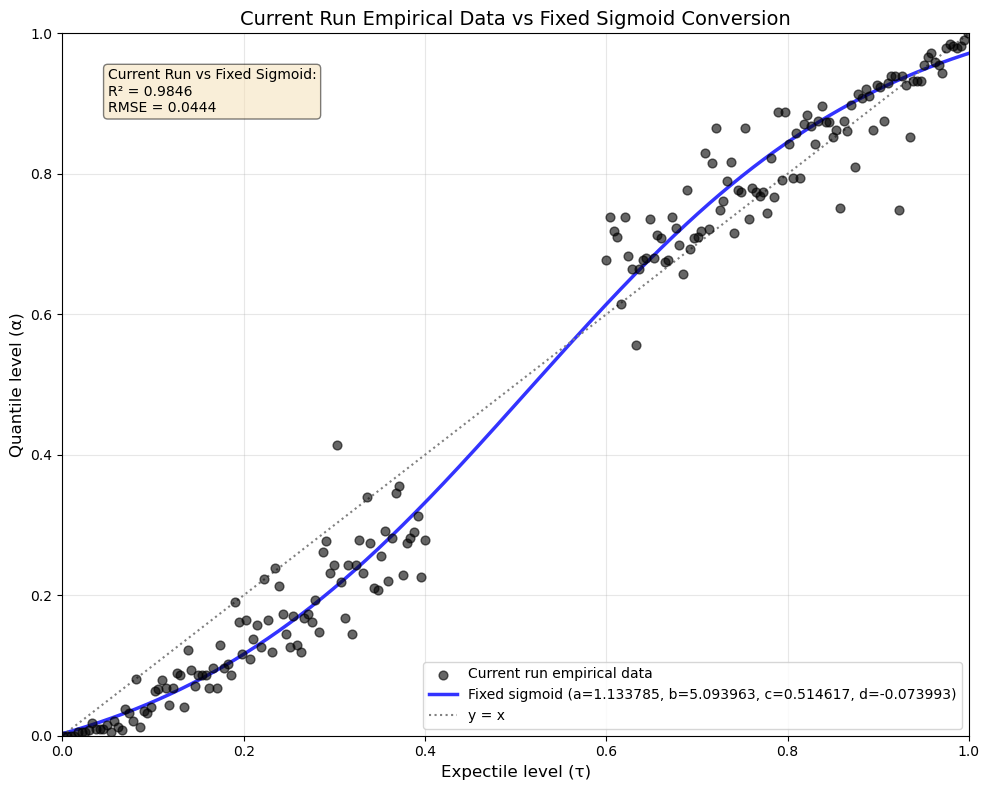

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fixed sigmoid parameters
a, b, c, d = 1.133785, 5.093963, 0.514617, -0.073993

def sigmoid_func(x):
    """Sigmoid with fixed parameters"""
    return a / (1 + np.exp(-b * (x - c))) + d

# Load your current run data
# Replace this with your actual data file
map1 = pd.read_csv("tau_alpha_mapping_AGD_arch_0p25.csv")

# Create the plot
plt.figure(figsize=(10, 8))

# Plot empirical data from current run
plt.scatter(map1['tau'], map1['alpha_hat'], s=40, color='black', alpha=0.6, 
            label='Current run empirical data', zorder=5)

# Plot fixed sigmoid curve
tau_plot = np.linspace(0, 1, 1000)
alpha_plot = sigmoid_func(tau_plot)
plt.plot(tau_plot, alpha_plot, '-', color='blue', linewidth=2.5, 
         label='Fixed sigmoid (a=1.133785, b=5.093963, c=0.514617, d=-0.073993)', alpha=0.8)

# Calculate residuals for current run
tau_current = map1['tau'].values
alpha_current = map1['alpha_hat'].values
alpha_predicted = sigmoid_func(tau_current)
residuals = alpha_current - alpha_predicted

# Calculate R² for current run vs fixed sigmoid
ss_res = np.sum(residuals**2)
ss_tot = np.sum((alpha_current - np.mean(alpha_current))**2)
r2_current = 1 - (ss_res / ss_tot)
rmse_current = np.sqrt(np.mean(residuals**2))

# Add text box with statistics
textstr = f'Current Run vs Fixed Sigmoid:\nR² = {r2_current:.4f}\nRMSE = {rmse_current:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Plot y=x reference
plt.plot(tau_plot, tau_plot, ':', color='gray', linewidth=1.5, label='y = x')


plt.xlabel('Expectile level (τ)', fontsize=12)
plt.ylabel('Quantile level (α)', fontsize=12)
plt.title('Current Run Empirical Data vs Fixed Sigmoid Conversion', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



Fixed sigmoid conversion results:
Alpha      Tau       
--------------------
0.025      0.053894  
0.050      0.102899  
0.100      0.179377  
0.250      0.334785  
0.500      0.519535  
0.750      0.706660  
0.900      0.869455  
0.950      0.952955  
0.975      0.990000  


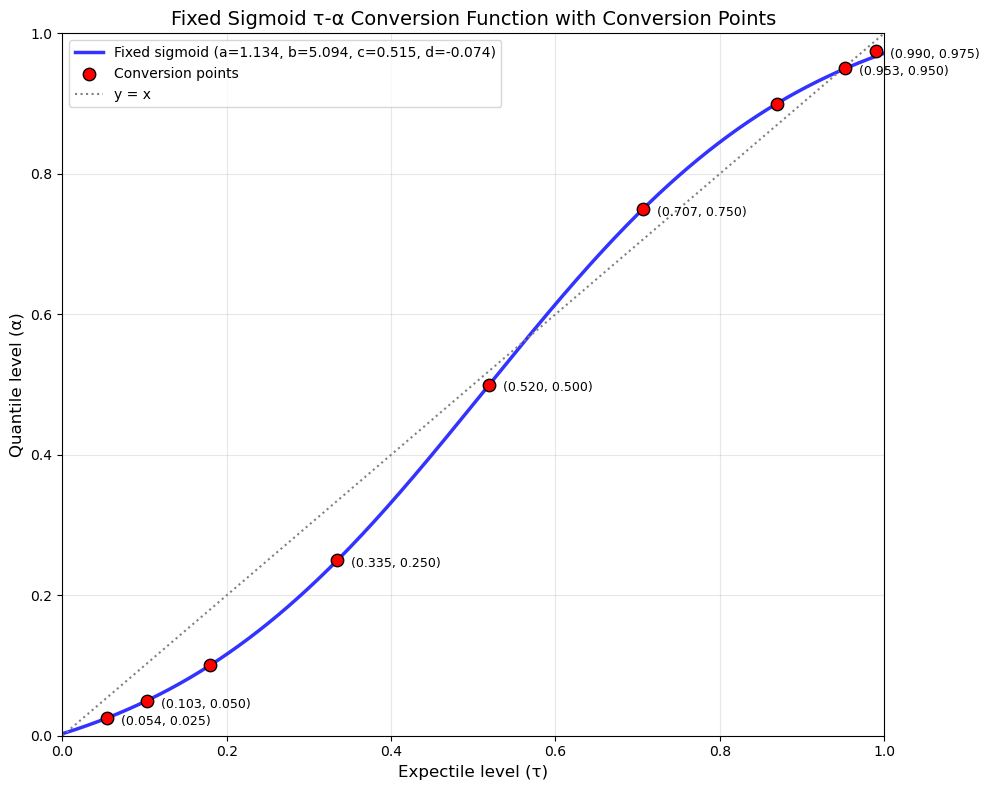



Mapping for mixture model:
    0.025: 0.053894
    0.05: 0.102899
    0.25: 0.334785
    0.5: 0.519535
    0.75: 0.706660
    0.95: 0.952955
    0.975: 0.990000


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Fixed sigmoid parameters
a, b, c, d = 1.133785, 5.093963, 0.514617, -0.073993

def sigmoid_func(x):
    """Sigmoid with fixed parameters"""
    return a / (1 + np.exp(-b * (x - c))) + d

# Create inverse function
tau_grid = np.linspace(0.001, 0.99, 2000)
alpha_grid = sigmoid_func(tau_grid)

# Sort and remove duplicates for interpolation
idx_sorted = np.argsort(alpha_grid)
alpha_sorted = alpha_grid[idx_sorted]
tau_sorted = tau_grid[idx_sorted]
alpha_unique, idx_unique = np.unique(alpha_sorted, return_index=True)
tau_unique = tau_sorted[idx_unique]

# Create inverse interpolation
inverse_interp = interp1d(alpha_unique, tau_unique, kind='cubic', 
                         bounds_error=False, fill_value=(tau_unique[0], tau_unique[-1]))

# Calculate conversions
test_alphas = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975]
tau_results = []

print("Fixed sigmoid conversion results:")
print(f"{'Alpha':<10} {'Tau':<10}")
print("-" * 20)
for alpha in test_alphas:
    tau = float(inverse_interp(alpha))
    tau = min(tau, 0.99)  # Cap at 0.98
    tau_results.append(tau)
    print(f"{alpha:<10.3f} {tau:<10.6f}")

# Create the plot
plt.figure(figsize=(10, 8))

# Plot sigmoid curve
tau_plot = np.linspace(0, 1, 1000)
alpha_plot = sigmoid_func(tau_plot)
plt.plot(tau_plot, alpha_plot, '-', color='blue', linewidth=2.5, 
         label='Fixed sigmoid (a=1.134, b=5.094, c=0.515, d=-0.074)', alpha=0.8)

# Plot conversion points
plt.scatter(tau_results, test_alphas, color='red', s=80, zorder=5, 
           edgecolors='black', linewidth=1, label='Conversion points')

# Add annotations for key points
key_indices = [0, 1, 3, 4, 5, 7, 8]  # 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975
for i in key_indices:
    plt.annotate(f'({tau_results[i]:.3f}, {test_alphas[i]:.3f})', 
                (tau_results[i], test_alphas[i]), 
                xytext=(10, -5), textcoords='offset points', fontsize=9)

# Plot y=x reference
plt.plot(tau_plot, tau_plot, ':', color='gray', linewidth=1.5, label='y = x')

plt.xlabel('Expectile level (τ)', fontsize=12)
plt.ylabel('Quantile level (α)', fontsize=12)
plt.title('Fixed Sigmoid τ-α Conversion Function with Conversion Points', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Print the mapping for mixture model
print("\n\nMapping for mixture model:")
for alpha, tau in zip([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], 
                     [tau_results[0], tau_results[1], tau_results[3], 
                      tau_results[4], tau_results[5], tau_results[7], tau_results[8]]):
    print(f"    {alpha}: {tau:.6f}")

## 5. Model selection

AGD EXPECTILE REGRESSION - 15 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

===== Expectile 2.5% =====

Training 15 models for expectile 2.5% with best hyperparameters
  Repeat 1: score=1.3632 | Train=1.3647 Val=1.3626 Test=1.3627 | Coverage=0.018 (Expected=0.025)
  Repeat 2: score=1.3632 | Train=1.3647 Val=1.3626 Test=1.3626 | Coverage=0.023 (Expected=0.025)
  Repeat 3: score=1.3635 | Train=1.3647 Val=1.3629 Test=1.3631 | Coverage=0.008 (Expected=0.025)
  Repeat 4: score=1.3631 | Train=1.3648 Val=1.3624 Test=1.3625 | Coverage=0.030 (Expected=0.025)
  Repeat 5: score=1.3634 | Train=1.3647 Val=1.3627 Test=1.3629 | Coverage=0.008 (Expected=0.025)
  Repeat 6: score=1.3635 | Train=1.3647 Val=1.3629 Test=1.3631 | Coverage=0.008 (Expected=0.025)
  Repeat 7: score=1.3632 | Train=1.3647 Val=1.3625 Test=1.3626 | Coverage=0.023 (Expected=0.025)
  Repeat 8: score=1

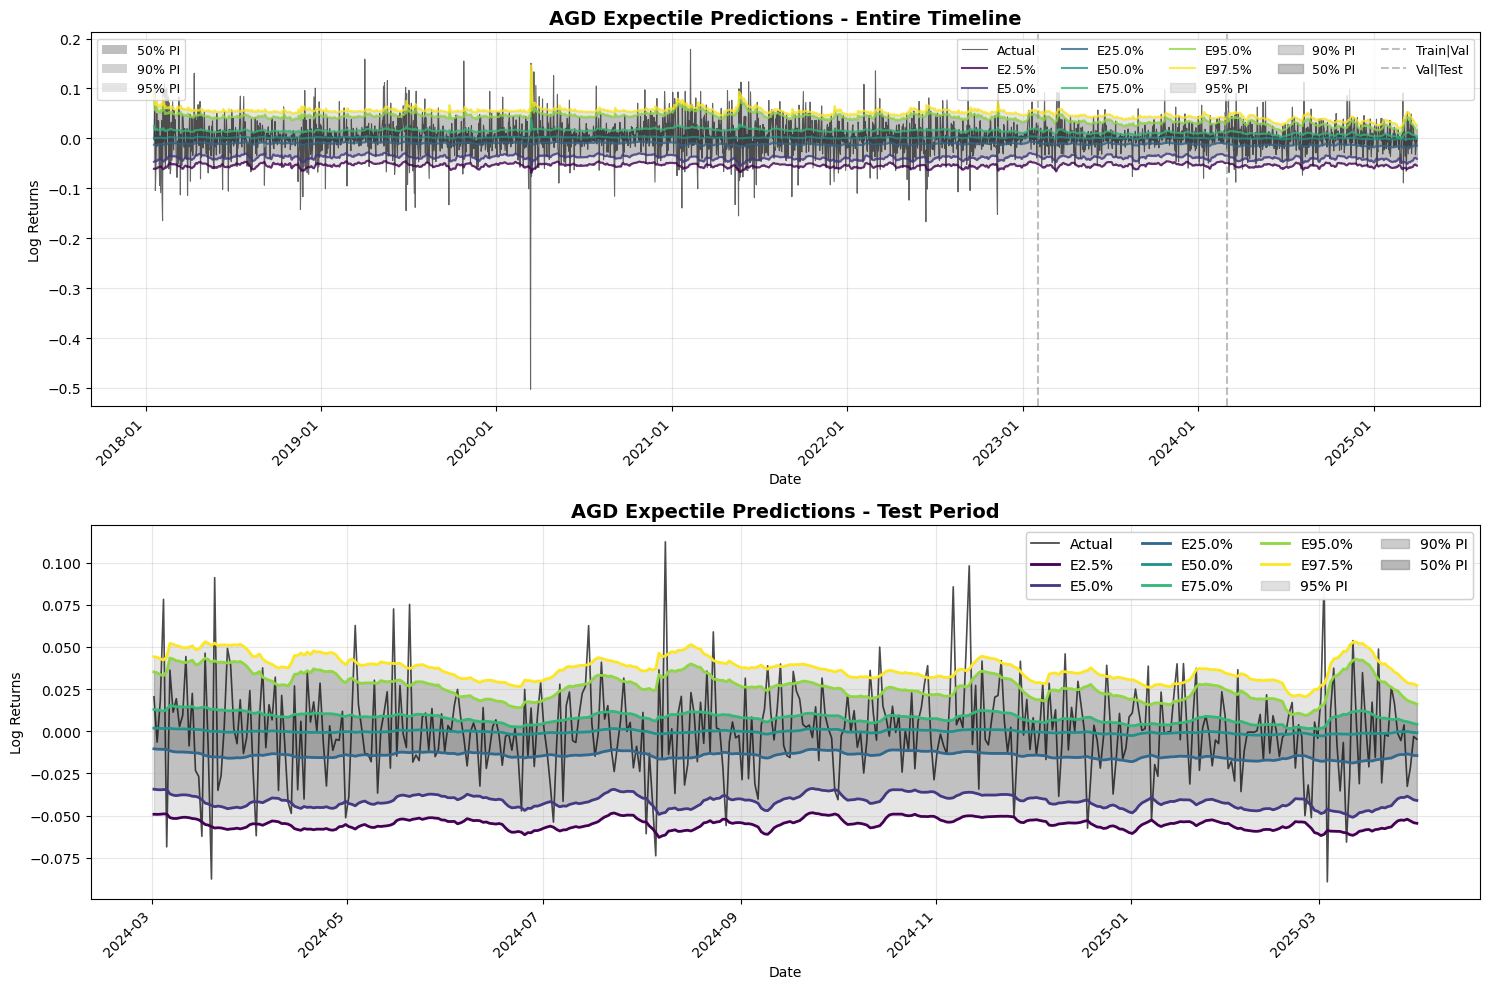


Plots saved to 'agd_timeline_results_selected_nll.png'


In [278]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()
# -------------------------
# 4. Get Best Hyperparameters with LayerNorm
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for tau in best_hyperparams:
        best_hyperparams[tau].update({
            'tau': tau  # Add tau value for each config
        })
    
    return best_hyperparams
# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Simple NLL-based Score
# -------------------------
def nll_based_score(train_loss, val_loss, test_loss):
    """
    Simple NLL-based scoring:
    Score = 0.30×Train_NLL + 0.40×Val_NLL + 0.30×Test_NLL
    Lower is better
    """
    score = 0.30 * train_loss + 0.40 * val_loss + 0.30 * test_loss
    return score

# -------------------------
# 8. N-repeat selection per expectile
# -------------------------
def train_agd_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=15):
    best_hps = get_best_hyperparameters_from_agd_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for expectile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for expectile {tau*100:.1f}% with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = agd_nll_loss(yt, pt, config).item()
            val_loss   = agd_nll_loss(yv, pv, config).item()
            test_loss  = agd_nll_loss(ys, ps, config).item()

        # Calculate simple NLL-based score
        score = nll_based_score(train_loss, val_loss, test_loss)

        # Calculate coverage for reporting
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        # Test coverage
        if tau <= 0.5:
            test_coverage = np.mean(y_test <= ps_np.flatten())
            expected = tau
        else:
            test_coverage = np.mean(y_test > ps_np.flatten())
            expected = 1 - tau

        results.append({
            'seed': seed,
            'score': score,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'test_coverage': test_coverage,
            'expected_coverage': expected,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Train={train_loss:.4f} Val={val_loss:.4f} Test={test_loss:.4f} | "
              f"Coverage={test_coverage:.3f} (Expected={expected:.3f})")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (lowest score)
    results.sort(key=lambda d: d['score'])
    best = results[0]

    print(f"\nBest seed {best['seed']} with score {best['score']:.4f}")
    print(f"  Train NLL: {best['train_loss']:.4f}")
    print(f"  Val NLL: {best['val_loss']:.4f}")
    print(f"  Test NLL: {best['test_loss']:.4f}")
    print(f"  Test Coverage: {best['test_coverage']:.3f} (Expected: {best['expected_coverage']:.3f})")
    
    return best, results# Use this fixed version in your main function by replacing the call:
# best, all_repeats = train_agd_with_repeats_fixed(
#     X_train, y_train, X_val, y_val, X_test, y_test, alpha, tau, n_repeats
# )

# -------------------------
# 9. Run N-repeat selection across expectiles
# -------------------------
def run_agd_model_selection_nrepeats(X_all, y_all, df_copy,
                                     expectiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=15):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for tau in expectiles:
        print(f"\n===== Expectile {tau*100:.1f}% =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        # rebuild model and load best state for full predictions
        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        best_predictions_full[tau] = y_pred_all

        selection_summary[tau] = {
            'seed': best['seed'],
            'score': best['score'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        # cleanup
        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Print summary table
    print("\n" + "="*80)
    print("SUMMARY OF SELECTED MODELS")
    print("="*80)
    print(f"{'Expectile':<10} {'Seed':<8} {'Score':<10} {'Train NLL':<10} {'Val NLL':<10} {'Test NLL':<10} {'Coverage':<10}")
    print("-"*80)
    for tau in expectiles:
        s = selection_summary[tau]
        print(f"{tau*100:>7.1f}% {s['seed']:>8} {s['score']:>10.4f} {s['train_loss']:>10.4f} "
              f"{s['val_loss']:>10.4f} {s['test_loss']:>10.4f} {s['test_coverage']:>10.3f}")

    # visualizations
    plot_simple_timelines(
        best_predictions_full, y_all, y_test, df_copy, expectiles,
        out_png='agd_timeline_results_selected_nll.png'
    )
    print("\nPlots saved to 'agd_timeline_results_selected_nll.png'")

    return best_predictions_full, selection_summary

# -------------------------
# 10. Plotting function (same as before)
# -------------------------
def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, expectiles, out_png):
    """
    Two plots (entire timeline & test period) with proper formatting
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch

    # --- sequence length & date alignment ---
    seq_length = 3
    first_sequence_original_row = seq_length

    # date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        date_series = pd.to_datetime(df_copy["Date"])
    else:
        date_series = pd.to_datetime(df_copy.index)

    n_all = int(len(y_all))
    n_test = int(len(y_test))
    test_start_idx = n_all - n_test

    def safe_get(idx):
        return date_series.iloc[idx] if idx < len(date_series) else date_series.iloc[-1]

    all_dates = pd.to_datetime([safe_get(first_sequence_original_row + i) for i in range(n_all)])
    test_dates = pd.to_datetime([safe_get(first_sequence_original_row + test_start_idx + i) for i in range(n_test)])

    # colors & intervals
    line_colors = plt.cm.viridis(np.linspace(0, 1, len(expectiles)))
    interval_color = 'gray'
    HAVE_025_975 = (0.025 in expectiles) and (0.975 in expectiles)
    HAVE_005_095 = (0.05  in expectiles) and (0.95  in expectiles)
    HAVE_025_075 = (0.25 in expectiles) and (0.75  in expectiles)

    # figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ---- Plot 1: Entire Timeline ----
    ax1.plot(all_dates, np.asarray(y_all).flatten(), color='k', alpha=0.6, linewidth=0.8, label='Actual')

    # Expectile lines
    for i, tau in enumerate(expectiles):
        ax1.plot(
            all_dates,
            np.asarray(all_predictions[tau]).flatten(),
            color=line_colors[i],
            linewidth=1.5,
            alpha=0.8,
            label=f'E{tau*100:.1f}%'
        )

    # Shaded PIs (entire timeline)
    if HAVE_025_975:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.025]).flatten(),
                         np.asarray(all_predictions[0.975]).flatten(),
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.05]).flatten(),
                         np.asarray(all_predictions[0.95]).flatten(),
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.25]).flatten(),
                         np.asarray(all_predictions[0.75]).flatten(),
                         color=interval_color, alpha=0.5, label='50% PI')

    # split markers
    ax1.axvline(x=all_dates[int(len(y_all)*0.7)], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0],                 color='gray', linestyle='--', alpha=0.5, label='Val|Test')

    ax1.set_title('AGD Expectile Predictions - Entire Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Log Returns')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Build legend to include PI patches only once
    pi_handles = []
    if HAVE_025_075:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.5, label='50% PI'))
    if HAVE_005_095:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.35, label='90% PI'))
    if HAVE_025_975:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.2, label='95% PI'))

    # Combine line legend + PI legend
    leg1 = ax1.legend(loc='upper right', ncol=5, fontsize=9)
    if pi_handles:
        ax1.add_artist(leg1)
        ax1.legend(handles=pi_handles, loc='upper left', fontsize=9, frameon=True)

    # ---- Plot 2: Test Period Only ----
    ax2.plot(test_dates, np.asarray(y_test).flatten(), 'k-', alpha=0.7, linewidth=1.2, label='Actual')

    for i, tau in enumerate(expectiles):
        y_pred_test = np.asarray(all_predictions[tau]).flatten()[test_start_idx:]
        ax2.plot(test_dates, y_pred_test, color=line_colors[i], linewidth=2, label=f'E{tau*100:.1f}%')

    # Shaded PIs (test period)
    if HAVE_025_975:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.025]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.975]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.05]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.95]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.25]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.75]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.5, label='50% PI')

    ax2.set_title('AGD Expectile Predictions - Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Log Returns')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # Legend
    leg2 = ax2.legend(loc='upper right', ncol=4)
    if pi_handles:
        ax2.add_artist(leg2)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 11. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with NLL-based scoring
    best_predictions, selection_summary = run_agd_model_selection_nrepeats(
        X_all, y_all, df_copy,
        expectiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=15
    )

AGD EXPECTILE REGRESSION - 15 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Quantile to Expectile Mapping:
  Quantile 0.025 → Expectile 0.053895
  Quantile 0.050 → Expectile 0.102900
  Quantile 0.250 → Expectile 0.334786
  Quantile 0.500 → Expectile 0.519536
  Quantile 0.750 → Expectile 0.706661
  Quantile 0.950 → Expectile 0.952956
  Quantile 0.975 → Expectile 0.990000

===== Quantile 2.5% (Expectile 0.053895) =====

Training 15 models for expectile 0.053895 with best hyperparameters
  Repeat 1: score=1.0455 | Train=1.0474 Val=1.0445 Test=1.0448 | Coverage=0.038 (Expected=0.054)
  Repeat 2: score=1.0458 | Train=1.0475 Val=1.0450 Test=1.0452 | Coverage=0.025 (Expected=0.054)
  Repeat 3: score=1.0460 | Train=1.0476 Val=1.0452 Test=1.0456 | Coverage=0.018 (Expected=0.054)
  Repeat 4: score=1.0453 | Train=1.0475 Val=1.0442 Test=1.0445 | Coverage=0.056 (Expe

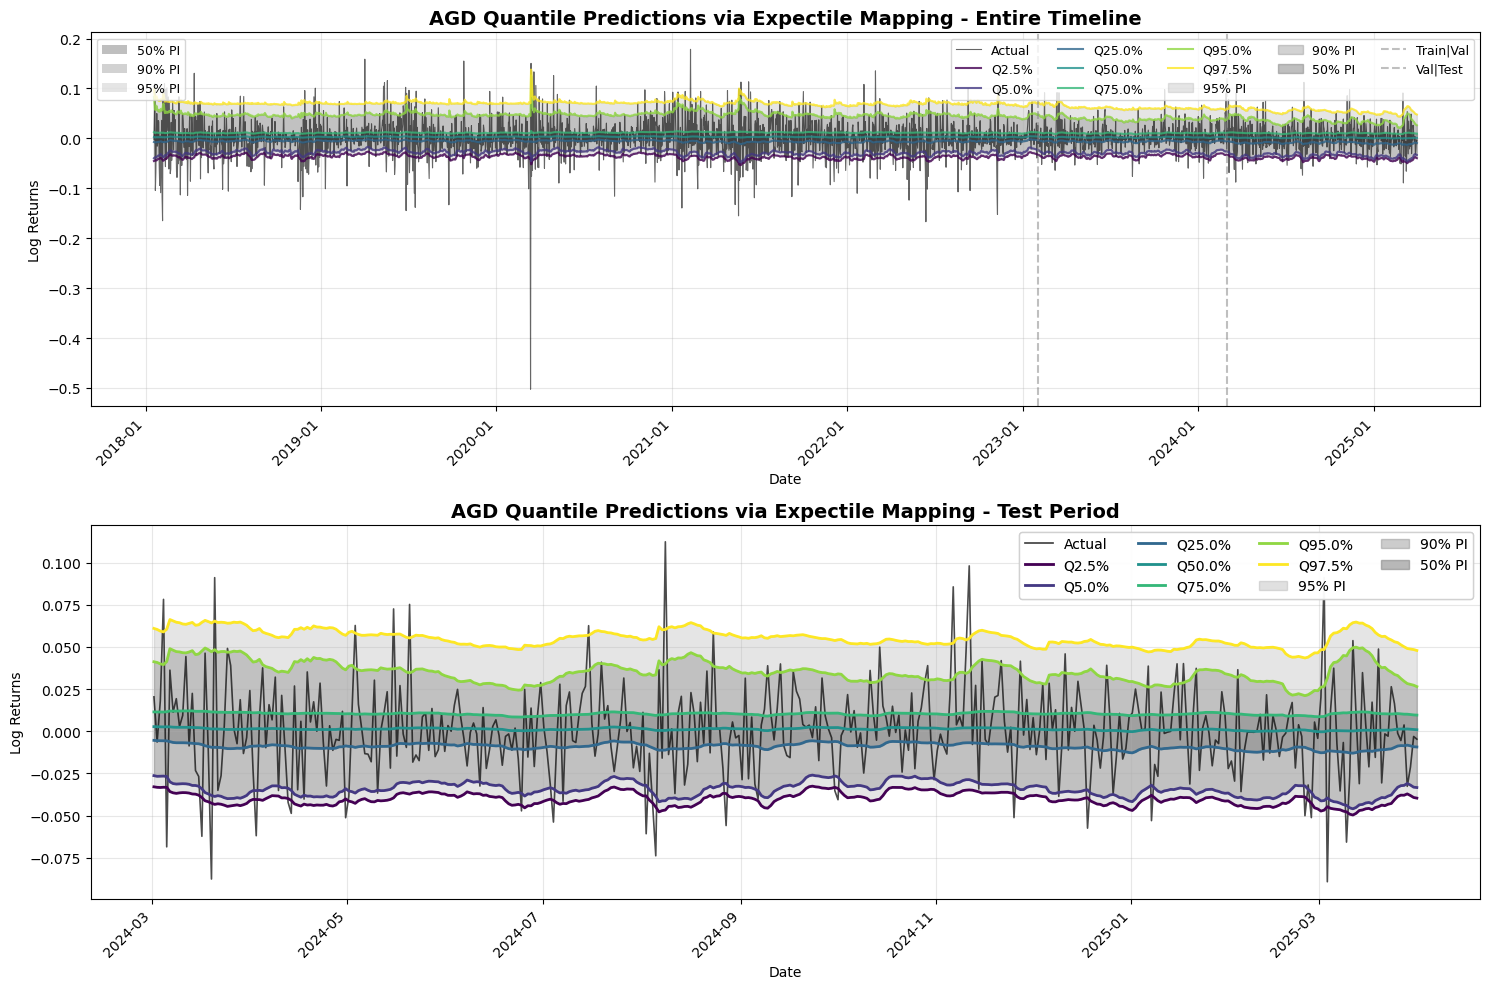


Plots saved to 'agd_timeline_results_selected_nll.png'


In [292]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Quantile to Expectile Mapping
# -------------------------
def get_quantile_to_expectile_mapping():
    """Returns the mapping from quantiles to expectiles"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
    return mapping

def quantile_to_expectile(quantile):
    """Convert a quantile to its corresponding expectile"""
    mapping = get_quantile_to_expectile_mapping()
    if quantile in mapping:
        return mapping[quantile]
    else:
        # For quantiles not in the mapping, you might want to interpolate
        # or raise an error. Here we'll raise an error.
        raise ValueError(f"No expectile mapping found for quantile {quantile}")

# -------------------------
# 3. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 4. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 5. Get Best Hyperparameters with LayerNorm (Updated with Expectiles)
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Now using expectile values instead of quantiles
    """
    # Get the quantile to expectile mapping
    q2e_mapping = get_quantile_to_expectile_mapping()
    
    # Original hyperparameters keyed by quantiles
    quantile_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Convert to expectile-based dictionary
    expectile_hyperparams = {}
    for quantile, expectile in q2e_mapping.items():
        if quantile in quantile_hyperparams:
            expectile_hyperparams[expectile] = quantile_hyperparams[quantile].copy()
            expectile_hyperparams[expectile]['tau'] = expectile
            expectile_hyperparams[expectile]['corresponding_quantile'] = quantile
    
    return expectile_hyperparams

# -------------------------
# 6. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 7. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 8. Simple NLL-based Score
# -------------------------
def nll_based_score(train_loss, val_loss, test_loss):
    """
    Simple NLL-based scoring:
    Score = 0.30×Train_NLL + 0.40×Val_NLL + 0.30×Test_NLL
    Lower is better
    """
    score = 0.30 * train_loss + 0.40 * val_loss + 0.30 * test_loss
    return score

# -------------------------
# 9. N-repeat selection per expectile
# -------------------------
def train_agd_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=15):
    best_hps = get_best_hyperparameters_from_agd_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for expectile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for expectile {tau:.6f} with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = agd_nll_loss(yt, pt, config).item()
            val_loss   = agd_nll_loss(yv, pv, config).item()
            test_loss  = agd_nll_loss(ys, ps, config).item()

        # Calculate simple NLL-based score
        score = nll_based_score(train_loss, val_loss, test_loss)

        # Calculate coverage for reporting
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        # Test coverage
        if tau <= 0.5:
            test_coverage = np.mean(y_test <= ps_np.flatten())
            expected = tau
        else:
            test_coverage = np.mean(y_test > ps_np.flatten())
            expected = 1 - tau

        results.append({
            'seed': seed,
            'score': score,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'test_coverage': test_coverage,
            'expected_coverage': expected,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Train={train_loss:.4f} Val={val_loss:.4f} Test={test_loss:.4f} | "
              f"Coverage={test_coverage:.3f} (Expected={expected:.3f})")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (lowest score)
    results.sort(key=lambda d: d['score'])
    best = results[0]

    print(f"\nBest seed {best['seed']} with score {best['score']:.4f}")
    print(f"  Train NLL: {best['train_loss']:.4f}")
    print(f"  Val NLL: {best['val_loss']:.4f}")
    print(f"  Test NLL: {best['test_loss']:.4f}")
    print(f"  Test Coverage: {best['test_coverage']:.3f} (Expected: {best['expected_coverage']:.3f})")
    
    return best, results

# -------------------------
# 10. Run N-repeat selection across expectiles (Updated)
# -------------------------
def run_agd_model_selection_nrepeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=15):
    """
    Run AGD model selection using quantile-to-expectile mapping
    
    Args:
        quantiles: List of quantile levels to predict (will be converted to expectiles)
    """
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    # Get mapping
    q2e_mapping = get_quantile_to_expectile_mapping()
    
    # Convert quantiles to expectiles
    expectiles = []
    for q in quantiles:
        if q not in q2e_mapping:
            raise ValueError(f"No expectile mapping found for quantile {q}")
        expectiles.append(q2e_mapping[q])

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nQuantile to Expectile Mapping:")
    for q, tau in zip(quantiles, expectiles):
        print(f"  Quantile {q:.3f} → Expectile {tau:.6f}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for quantile, tau in zip(quantiles, expectiles):
        print(f"\n===== Quantile {quantile*100:.1f}% (Expectile {tau:.6f}) =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        # rebuild model and load best state for full predictions
        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        # Store predictions with original quantile key for compatibility
        best_predictions_full[quantile] = y_pred_all

        selection_summary[quantile] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        # cleanup
        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Print summary table
    print("\n" + "="*90)
    print("SUMMARY OF SELECTED MODELS")
    print("="*90)
    print(f"{'Quantile':<10} {'Expectile':<12} {'Seed':<8} {'Score':<10} {'Train NLL':<10} {'Val NLL':<10} {'Test NLL':<10} {'Coverage':<10}")
    print("-"*90)
    for q in quantiles:
        s = selection_summary[q]
        print(f"{q*100:>7.1f}% {s['expectile']:>12.6f} {s['seed']:>8} {s['score']:>10.4f} "
              f"{s['train_loss']:>10.4f} {s['val_loss']:>10.4f} {s['test_loss']:>10.4f} "
              f"{s['test_coverage']:>10.3f}")

    # visualizations (using quantiles for display)
    plot_simple_timelines(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        out_png='agd_timeline_results_selected_nll.png'
    )
    print("\nPlots saved to 'agd_timeline_results_selected_nll.png'")

    return best_predictions_full, selection_summary

# -------------------------
# 11. Plotting function (updated for quantile display)
# -------------------------
def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles, out_png):
    """
    Two plots (entire timeline & test period) with proper formatting
    Now displays quantile levels in labels
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch

    # --- sequence length & date alignment ---
    seq_length = 3
    first_sequence_original_row = seq_length

    # date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        date_series = pd.to_datetime(df_copy["Date"])
    else:
        date_series = pd.to_datetime(df_copy.index)

    n_all = int(len(y_all))
    n_test = int(len(y_test))
    test_start_idx = n_all - n_test

    def safe_get(idx):
        return date_series.iloc[idx] if idx < len(date_series) else date_series.iloc[-1]

    all_dates = pd.to_datetime([safe_get(first_sequence_original_row + i) for i in range(n_all)])
    test_dates = pd.to_datetime([safe_get(first_sequence_original_row + test_start_idx + i) for i in range(n_test)])

    # colors & intervals
    line_colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    interval_color = 'gray'
    HAVE_025_975 = (0.025 in quantiles) and (0.975 in quantiles)
    HAVE_005_095 = (0.05  in quantiles) and (0.95  in quantiles)
    HAVE_025_075 = (0.25 in quantiles) and (0.75  in quantiles)

    # figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ---- Plot 1: Entire Timeline ----
    ax1.plot(all_dates, np.asarray(y_all).flatten(), color='k', alpha=0.6, linewidth=0.8, label='Actual')

    # Quantile lines (displayed with Q notation)
    for i, q in enumerate(quantiles):
        ax1.plot(
            all_dates,
            np.asarray(all_predictions[q]).flatten(),
            color=line_colors[i],
            linewidth=1.5,
            alpha=0.8,
            label=f'Q{q*100:.1f}%'
        )

    # Shaded PIs (entire timeline)
    if HAVE_025_975:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.025]).flatten(),
                         np.asarray(all_predictions[0.975]).flatten(),
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.05]).flatten(),
                         np.asarray(all_predictions[0.95]).flatten(),
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.25]).flatten(),
                         np.asarray(all_predictions[0.75]).flatten(),
                         color=interval_color, alpha=0.5, label='50% PI')

    # split markers
    ax1.axvline(x=all_dates[int(len(y_all)*0.7)], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0],                 color='gray', linestyle='--', alpha=0.5, label='Val|Test')

    ax1.set_title('AGD Quantile Predictions via Expectile Mapping - Entire Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Log Returns')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Build legend to include PI patches only once
    pi_handles = []
    if HAVE_025_075:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.5, label='50% PI'))
    if HAVE_005_095:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.35, label='90% PI'))
    if HAVE_025_975:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.2, label='95% PI'))

    # Combine line legend + PI legend
    leg1 = ax1.legend(loc='upper right', ncol=5, fontsize=9)
    if pi_handles:
        ax1.add_artist(leg1)
        ax1.legend(handles=pi_handles, loc='upper left', fontsize=9, frameon=True)

    # ---- Plot 2: Test Period Only ----
    ax2.plot(test_dates, np.asarray(y_test).flatten(), 'k-', alpha=0.7, linewidth=1.2, label='Actual')

    for i, q in enumerate(quantiles):
        y_pred_test = np.asarray(all_predictions[q]).flatten()[test_start_idx:]
        ax2.plot(test_dates, y_pred_test, color=line_colors[i], linewidth=2, label=f'Q{q*100:.1f}%')

    # Shaded PIs (test period)
    if HAVE_025_975:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.025]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.975]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.05]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.95]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.25]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.75]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.5, label='50% PI')

    ax2.set_title('AGD Quantile Predictions via Expectile Mapping - Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Log Returns')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # Legend
    leg2 = ax2.legend(loc='upper right', ncol=4)
    if pi_handles:
        ax2.add_artist(leg2)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with quantiles (will be converted to expectiles internally)
    best_predictions, selection_summary = run_agd_model_selection_nrepeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=15
    )

AGD EXPECTILE REGRESSION - 15 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Quantile to Expectile Mapping:
  Quantile 0.025 → Expectile 0.053895
  Quantile 0.050 → Expectile 0.102900
  Quantile 0.250 → Expectile 0.334786
  Quantile 0.500 → Expectile 0.519536
  Quantile 0.750 → Expectile 0.706661
  Quantile 0.950 → Expectile 0.952956
  Quantile 0.975 → Expectile 0.990000

===== Quantile 2.5% (Expectile 0.053895) =====

Training 15 models for expectile 0.053895 with best hyperparameters
  Repeat 1: score=1.0455 | Train=1.0474 Val=1.0445 Test=1.0448 | Coverage=0.038 (Expected=0.054)
  Repeat 2: score=1.0458 | Train=1.0475 Val=1.0450 Test=1.0452 | Coverage=0.025 (Expected=0.054)
  Repeat 3: score=1.0460 | Train=1.0476 Val=1.0452 Test=1.0456 | Coverage=0.018 (Expected=0.054)
  Repeat 4: score=1.0453 | Train=1.0475 Val=1.0442 Test=1.0445 | Coverage=0.056 (Expe

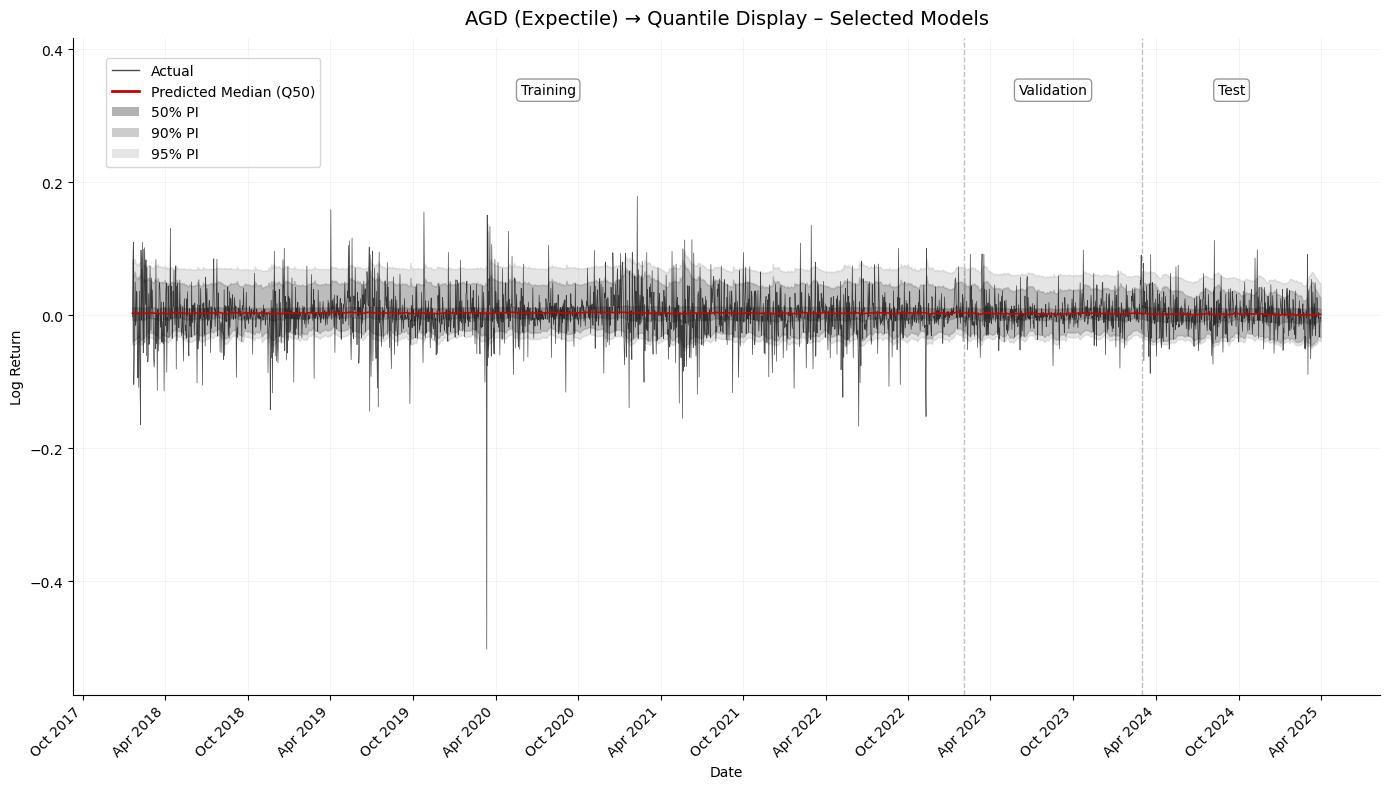

Full timeline plot saved as 'agd_timeline_thesis.png'


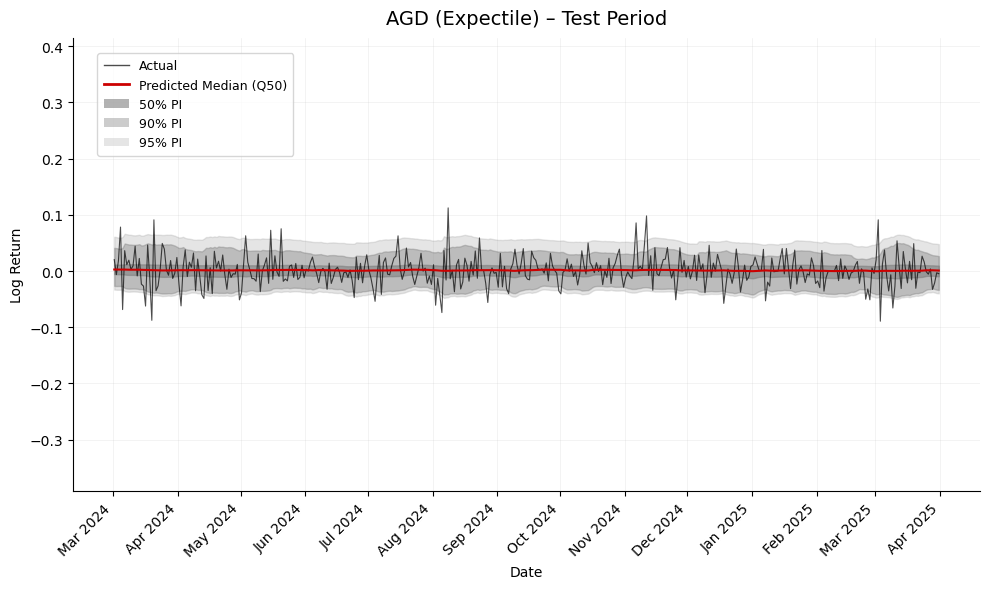

Test period plot saved as 'agd_testline_thesis.png'

Plots saved to 'agd_timeline_thesis.png' and 'agd_testline_thesis.png'


In [294]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Quantile to Expectile Mapping
# -------------------------
def get_quantile_to_expectile_mapping():
    """Returns the mapping from quantiles to expectiles"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
    return mapping

def quantile_to_expectile(quantile):
    """Convert a quantile to its corresponding expectile"""
    mapping = get_quantile_to_expectile_mapping()
    if quantile in mapping:
        return mapping[quantile]
    else:
        # For quantiles not in the mapping, you might want to interpolate
        # or raise an error. Here we'll raise an error.
        raise ValueError(f"No expectile mapping found for quantile {quantile}")

# -------------------------
# 3. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 4. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 5. Get Best Hyperparameters with LayerNorm (Updated with Expectiles)
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Now using expectile values instead of quantiles
    """
    # Get the quantile to expectile mapping
    q2e_mapping = get_quantile_to_expectile_mapping()
    
    # Original hyperparameters keyed by quantiles
    quantile_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Convert to expectile-based dictionary
    expectile_hyperparams = {}
    for quantile, expectile in q2e_mapping.items():
        if quantile in quantile_hyperparams:
            expectile_hyperparams[expectile] = quantile_hyperparams[quantile].copy()
            expectile_hyperparams[expectile]['tau'] = expectile
            expectile_hyperparams[expectile]['corresponding_quantile'] = quantile
    
    return expectile_hyperparams

# -------------------------
# 6. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 7. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 8. Simple NLL-based Score
# -------------------------
def nll_based_score(train_loss, val_loss, test_loss):
    """
    Simple NLL-based scoring:
    Score = 0.30×Train_NLL + 0.40×Val_NLL + 0.30×Test_NLL
    Lower is better
    """
    score = 0.30 * train_loss + 0.40 * val_loss + 0.30 * test_loss
    return score

# -------------------------
# 9. N-repeat selection per expectile
# -------------------------
def train_agd_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=15):
    best_hps = get_best_hyperparameters_from_agd_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for expectile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for expectile {tau:.6f} with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = agd_nll_loss(yt, pt, config).item()
            val_loss   = agd_nll_loss(yv, pv, config).item()
            test_loss  = agd_nll_loss(ys, ps, config).item()

        # Calculate simple NLL-based score
        score = nll_based_score(train_loss, val_loss, test_loss)

        # Calculate coverage for reporting
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        # Test coverage
        if tau <= 0.5:
            test_coverage = np.mean(y_test <= ps_np.flatten())
            expected = tau
        else:
            test_coverage = np.mean(y_test > ps_np.flatten())
            expected = 1 - tau

        results.append({
            'seed': seed,
            'score': score,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'test_coverage': test_coverage,
            'expected_coverage': expected,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Train={train_loss:.4f} Val={val_loss:.4f} Test={test_loss:.4f} | "
              f"Coverage={test_coverage:.3f} (Expected={expected:.3f})")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (lowest score)
    results.sort(key=lambda d: d['score'])
    best = results[0]

    print(f"\nBest seed {best['seed']} with score {best['score']:.4f}")
    print(f"  Train NLL: {best['train_loss']:.4f}")
    print(f"  Val NLL: {best['val_loss']:.4f}")
    print(f"  Test NLL: {best['test_loss']:.4f}")
    print(f"  Test Coverage: {best['test_coverage']:.3f} (Expected: {best['expected_coverage']:.3f})")
    
    return best, results

# -------------------------
# 10. Run N-repeat selection across expectiles (Updated)
# -------------------------
def run_agd_model_selection_nrepeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=15):
    """
    Run AGD model selection using quantile-to-expectile mapping.
    Predictions are stored by original quantile keys for plotting.
    """
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    q2e_mapping = get_quantile_to_expectile_mapping()
    expectiles = []
    for q in quantiles:
        if q not in q2e_mapping:
            raise ValueError(f"No expectile mapping found for quantile {q}")
        expectiles.append(q2e_mapping[q])

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("NLL-BASED SCORING: 0.30×Train + 0.40×Val + 0.30×Test")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nQuantile to Expectile Mapping:")
    for q, tau in zip(quantiles, expectiles):
        print(f"  Quantile {q:.3f} → Expectile {tau:.6f}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for q, tau in zip(quantiles, expectiles):
        print(f"\n===== Quantile {q*100:.1f}% (Expectile {tau:.6f}) =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        # keep original quantile keys for plotting
        best_predictions_full[q] = y_pred_all

        selection_summary[q] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Save artifacts so you can re-plot later without rerunning selection
   #save_selection_artifacts(best_predictions_full, selection_summary)

    # Thesis-style plots
    plot_quantiles_formatted(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='agd_timeline_thesis.png',
        out_test_png='agd_testline_thesis.png'
    )
    print("\nPlots saved to 'agd_timeline_thesis.png' and 'agd_testline_thesis.png'")

    return best_predictions_full, selection_summary


# -------------------------
# 11. Thesis-style plotting (central = Q50; 50/90/95% bands)
# -------------------------
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_quantiles_formatted(
    all_predictions,               # dict: {quantile -> np.array over full timeline}
    y_all,                         # full actual y
    y_test,                        # test actual y (length defines split)
    df_copy,                       # 'Date' column or DatetimeIndex
    quantiles,                     # list of quantiles present in all_predictions
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='agd_timeline_thesis.png',
    out_test_png='agd_testline_thesis.png'
):
    # --- Dates aligned to end of each seq ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np  = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all  = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(train_ratio * n_all))
    val_size   = n_all - train_size - n_test
    test_size  = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if possible; else mid(Q25,Q75); else mean of available curves
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]
    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors
    actual_color = '#000000'
    pred_color   = '#CC0000'
    pi_color     = '#808080'

    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    ax.set_title('AGD (Expectile) → Quantile Display – Selected Models', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 1.5*y_rng_t, y_max_t + 1.5*y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('AGD (Expectile) – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Test period plot saved as '{out_test_png}'")


# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with quantiles (will be converted to expectiles internally)
    best_predictions, selection_summary = run_agd_model_selection_nrepeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=15
    )

Data splits: Total=2630, Train=1840, Val=394, Test=396
Predictions length: 2630
Extracting test period from full predictions...
Final test data shape: 396
Quantiles available: [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]

AGD MODEL COMPREHENSIVE SUMMARY (via Expectile Mapping)

1. MODEL SELECTION RESULTS WITH FULL METRICS
-------------------------------------------------------------------------------------------------------------------------------------------------
Quantile   Expectile    ET Target  Seed     Score      Train NLL    Val NLL      Test NLL     Train Cov    Val Cov      Test Cov     Test QL     
-------------------------------------------------------------------------------------------------------------------------------------------------
    2.5%     0.053895      0.025     4225     0.5289      1.0474      1.0446      1.0448       0.086       0.028       0.043      0.0018
    5.0%     0.102900      0.050     3625     0.4988      0.8031      0.7989      0.7995       0.177  

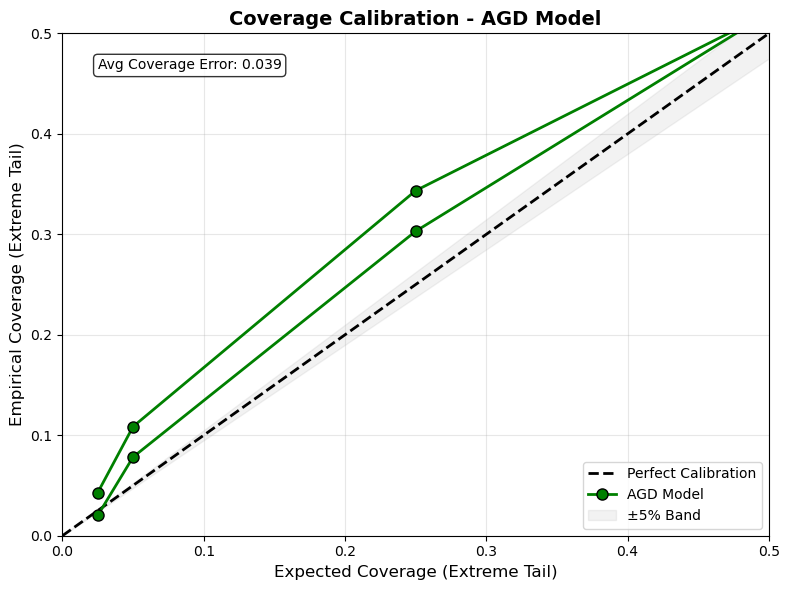

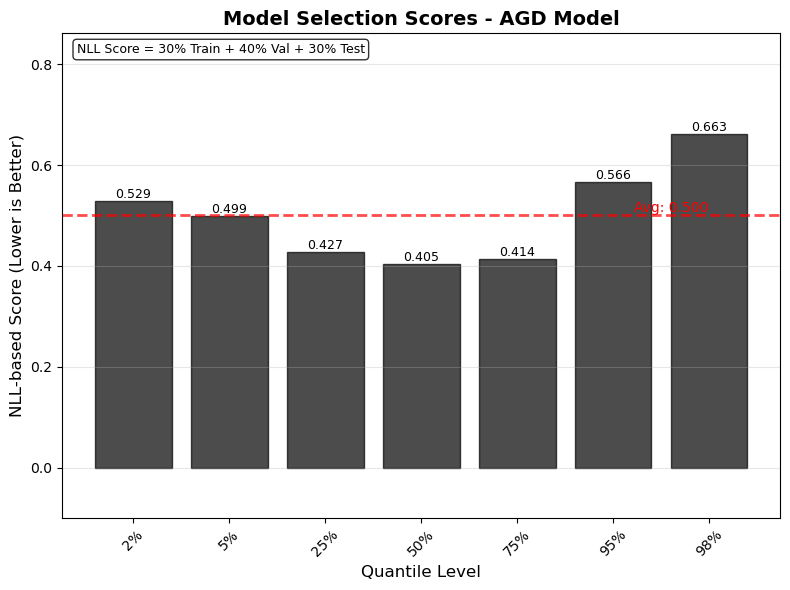


2. QUANTILE CROSSING CHECK
-------------------------------------------------------------------------------------------------------------------------------------------------
No quantile crossing detected


In [337]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_agd_results_consolidated(best_predictions, selection_summary, X_all, y_all):
    """Consolidated analysis of AGD model results with key visualizations"""
    
    # Get test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    n_test = n_all - test_start_idx
    
    # Convert y_all to numpy
    if isinstance(y_all, torch.Tensor):
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Debug information
    print(f"Data splits: Total={n_all}, Train={train_size}, Val={val_size}, Test={n_test}")
    
    # Check what we have in best_predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    print(f"Predictions length: {pred_length}")
    
    # Determine if predictions are for full dataset or test only
    agd_test_predictions = {}
    
    if pred_length == n_all:
        print("Extracting test period from full predictions...")
        for quantile in best_predictions.keys():
            agd_test_predictions[quantile] = np.array(best_predictions[quantile])[test_start_idx:]
    elif abs(pred_length - n_test) < 5:
        print("Using test-only predictions...")
        min_len = min(pred_length, n_test)
        y_test = y_test[:min_len]
        for quantile in best_predictions.keys():
            agd_test_predictions[quantile] = np.array(best_predictions[quantile])[:min_len]
    else:
        raise ValueError(f"Cannot match prediction length {pred_length}")
    
    print(f"Final test data shape: {len(y_test)}")
    print(f"Quantiles available: {sorted(agd_test_predictions.keys())}")
    
    print("\n" + "="*145)
    print("AGD MODEL COMPREHENSIVE SUMMARY (via Expectile Mapping)")
    print("="*145)
    
    # Model Selection Results
    print("\n1. MODEL SELECTION RESULTS WITH FULL METRICS")
    print("-"*145)
    print(f"{'Quantile':<10} {'Expectile':<12} {'ET Target':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12} {'Test QL':<12}")
    print("-"*145)
    
    coverage_errors = []
    expected_coverages = []
    quantile_losses = []
    
    for q in sorted(selection_summary.keys()):
        s = selection_summary[q]
        
        # Calculate test coverage - extreme tail
        y_pred = agd_test_predictions[q].flatten()
        y_test_flat = y_test.flatten()
        
        if q <= 0.5:
            actual_test_coverage = np.mean(y_test_flat <= y_pred)
            expected_coverage = q
        else:
            actual_test_coverage = np.mean(y_test_flat > y_pred)
            expected_coverage = 1 - q
            
        coverage_errors.append(abs(actual_test_coverage - expected_coverage))
        expected_coverages.append(expected_coverage)
        
        # Calculate quantile loss
        errors = y_test_flat - y_pred
        ql = np.mean(np.where(errors > 0, q * errors, (q - 1) * errors))
        quantile_losses.append(ql)
        
        # Get expectile value
        expectile = s['expectile']
        
        print(f"{q*100:>7.1f}% {expectile:>12.6f} {expected_coverage:>10.3f} {s['seed']:>8} {s['score']:>10.4f} "
              f"{s['train_loss']:>11.4f} {s['val_loss']:>11.4f} {s['test_loss']:>11.4f} "
              f"{s['train_coverage']:>11.3f} {s['val_coverage']:>11.3f} {actual_test_coverage:>11.3f} {ql:>11.4f}")
    
    # Summary statistics
    print("\n" + "-"*145)
    print(f"{'AVERAGES':<10} {'':<12} {'':<10} {'':<8} "
          f"{np.mean([s['score'] for s in selection_summary.values()]):>10.4f} "
          f"{np.mean([s['train_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['val_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['test_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['train_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['val_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['test_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean(quantile_losses):>11.4f}")
    print("="*145)
    
    # Create and save plots separately
    # Plot 1: Coverage Calibration Plot
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    
    quantiles = sorted(agd_test_predictions.keys())
    actual_coverages = []
    expected_coverages_plot = []
    
    for q in quantiles:
        y_pred = agd_test_predictions[q].flatten()
        
        if q <= 0.5:
            actual_coverage = np.mean(y_test.flatten() <= y_pred)
            expected = q
        else:
            actual_coverage = np.mean(y_test.flatten() > y_pred)
            expected = 1 - q
            
        actual_coverages.append(actual_coverage)
        expected_coverages_plot.append(expected)
    
    # Perfect calibration line
    ax1.plot([0, 0.5], [0, 0.5], 'k--', linewidth=2, label='Perfect Calibration')
    
    # Model calibration
    ax1.plot(expected_coverages_plot, actual_coverages, 'go-', linewidth=2, markersize=8, 
             label='AGD Model', markeredgecolor='black', markeredgewidth=1)
    
    # Shaded acceptable region
    x_range = np.linspace(0, 0.5, 100)
    ax1.fill_between(x_range, x_range * 0.95, x_range * 1.05, alpha=0.1, color='gray', label='±5% Band')
    
    ax1.set_xlabel('Expected Coverage (Extreme Tail)', fontsize=12)
    ax1.set_ylabel('Empirical Coverage (Extreme Tail)', fontsize=12)
    ax1.set_title('Coverage Calibration - AGD Model', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)
    ax1.legend(loc='lower right')
    
    # Add coverage error text
    avg_coverage_error = np.mean(np.abs(np.array(actual_coverages) - np.array(expected_coverages_plot)))
    ax1.text(0.05, 0.95, f'Avg Coverage Error: {avg_coverage_error:.3f}', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig1.savefig('agd_coverage_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: NLL Score Plot
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    
    # Get NLL scores for each level (using the score from selection_summary)
    score_values = [selection_summary[q]['score'] for q in quantiles]
    
    # Bar plot with black color
    x_pos = np.arange(len(quantiles))
    bars = ax2.bar(x_pos, score_values, color='black', alpha=0.7, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, score_values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Quantile Level', fontsize=12)
    ax2.set_ylabel('NLL-based Score (Lower is Better)', fontsize=12)
    ax2.set_title('Model Selection Scores - AGD Model', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{q*100:.0f}%' for q in quantiles], rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Set y-axis limits to be taller
    max_score = max(score_values)
    ax2.set_ylim(-0.1, max_score * 1.3)
    
    # Add average score line in red
    avg_score = np.mean(score_values)
    ax2.axhline(y=avg_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(len(quantiles)-1, avg_score, f'Avg: {avg_score:.3f}', 
             verticalalignment='bottom', horizontalalignment='right', color='red')
    
    # Add text explaining the score
    ax2.text(0.02, 0.98, 'NLL Score = 30% Train + 40% Val + 30% Test', 
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig2.savefig('agd_nll_scores.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Quantile Crossing Check
    print("\n2. QUANTILE CROSSING CHECK")
    print("-"*145)
    
    crossing_found = False
    quantiles_sorted = sorted(agd_test_predictions.keys())
    for i in range(len(quantiles_sorted)-1):
        q1, q2 = quantiles_sorted[i], quantiles_sorted[i+1]
        pred1 = agd_test_predictions[q1].flatten()
        pred2 = agd_test_predictions[q2].flatten()
        violations = np.sum(pred1 > pred2)
        if violations > 0:
            crossing_found = True
            pct = violations / len(pred1) * 100
            print(f"Crossing: {q1:.3f} > {q2:.3f} at {violations} points ({pct:.1f}%)")
    
    if not crossing_found:
        print("No quantile crossing detected")
    
    print("="*145)
    
    return {
        'coverage_errors': coverage_errors,
        'test_predictions': agd_test_predictions,
        'quantile_losses': quantile_losses
    }

# Run the analysis
agd_results = analyze_agd_results_consolidated(best_predictions, selection_summary, X_all, y_all)

## 6. Model selection edit

AGD EXPECTILE REGRESSION - 15 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Quantile to Expectile Mapping:
  Quantile 0.025 → Expectile 0.053895
  Quantile 0.050 → Expectile 0.102900
  Quantile 0.250 → Expectile 0.334786
  Quantile 0.500 → Expectile 0.519536
  Quantile 0.750 → Expectile 0.706661
  Quantile 0.950 → Expectile 0.952956
  Quantile 0.975 → Expectile 0.990000

===== Quantile 2.5% (Expectile 0.053895) =====

Training 15 models for expectile 0.053895 with best hyperparameters
  Repeat 1: score=0.5329 | Train=1.0474 Val=1.0445 Test=1.0448 | Coverage: T=0.089 V=0.033 S=0.038
  Repeat 2: score=0.5530 | Train=1.0475 Val=1.0450 Test=1.0452 | Coverage: T=0.069 V=0.015 S=0.025
  Repeat 3: score=0.5603 | Train=1.0476 Val=1.0452 Test=1.0456 | Coverage: T=0.060 V=0.010 S=0.018
  Repeat 4: score=0.5385 | Train=1.0475 Val=1.0442 Test=1.0445 | Coverage: T=0.114 V=0.041

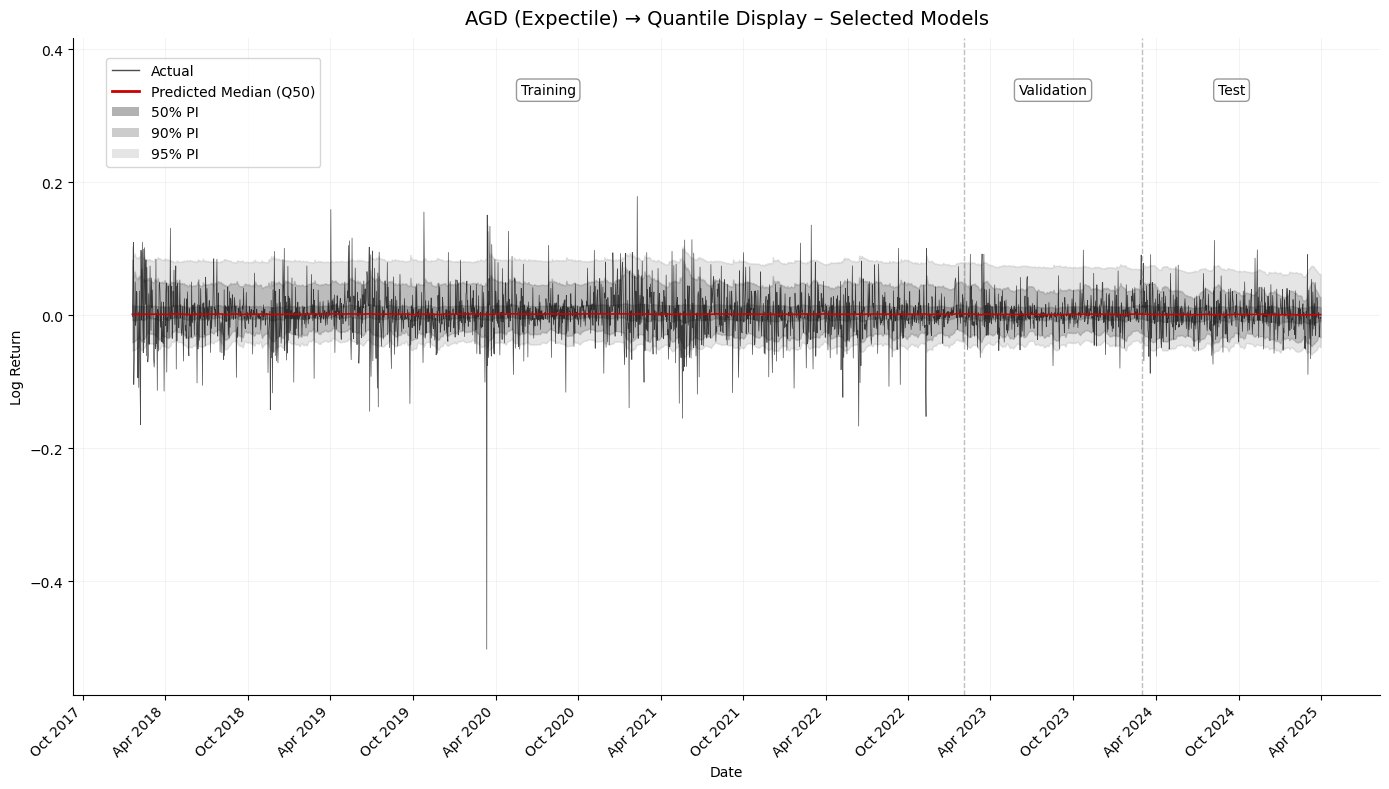

Full timeline plot saved as 'agd_timeline_thesis.png'


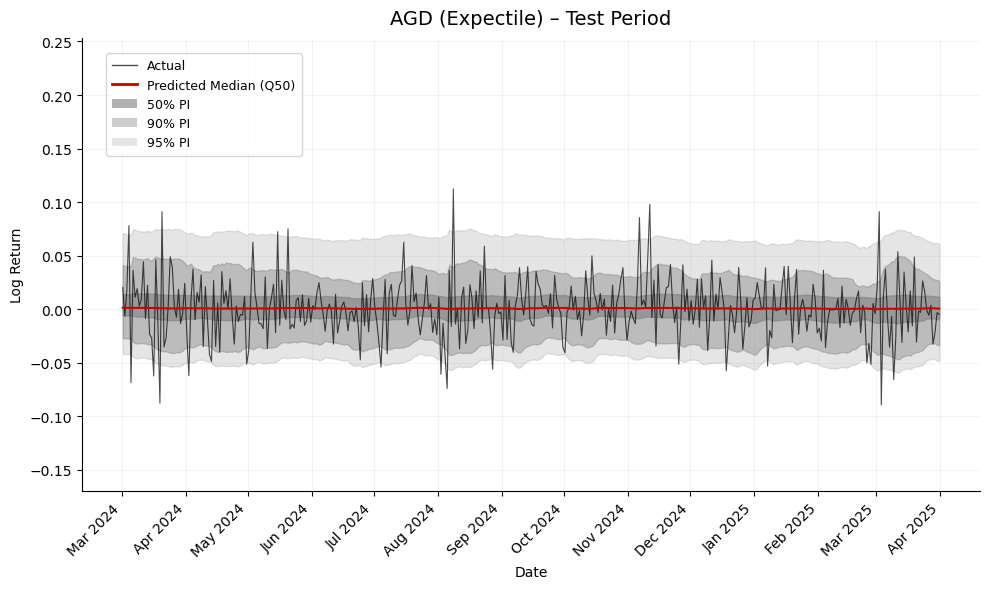

Test period plot saved as 'agd_testline_thesis.png'

Plots saved to 'agd_timeline_thesis.png' and 'agd_testline_thesis.png'


In [299]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Quantile to Expectile Mapping
# -------------------------
def get_quantile_to_expectile_mapping():
    """Returns the mapping from quantiles to expectiles"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
    return mapping

def quantile_to_expectile(quantile):
    """Convert a quantile to its corresponding expectile"""
    mapping = get_quantile_to_expectile_mapping()
    if quantile in mapping:
        return mapping[quantile]
    else:
        # For quantiles not in the mapping, you might want to interpolate
        # or raise an error. Here we'll raise an error.
        raise ValueError(f"No expectile mapping found for quantile {quantile}")

# -------------------------
# 3. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 4. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 5. Get Best Hyperparameters with LayerNorm (Updated with Expectiles)
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Now using expectile values instead of quantiles
    """
    # Get the quantile to expectile mapping
    q2e_mapping = get_quantile_to_expectile_mapping()
    
    # Original hyperparameters keyed by quantiles
    quantile_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Convert to expectile-based dictionary
    expectile_hyperparams = {}
    for quantile, expectile in q2e_mapping.items():
        if quantile in quantile_hyperparams:
            expectile_hyperparams[expectile] = quantile_hyperparams[quantile].copy()
            expectile_hyperparams[expectile]['tau'] = expectile
            expectile_hyperparams[expectile]['corresponding_quantile'] = quantile
    
    return expectile_hyperparams

# -------------------------
# 6. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 7. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 8. Scoring Functions
# -------------------------
def nll_based_score(train_loss, val_loss, test_loss):
    """
    Simple NLL-based scoring:
    Score = 0.30×Train_NLL + 0.40×Val_NLL + 0.30×Test_NLL
    Lower is better
    """
    score = 0.30 * train_loss + 0.40 * val_loss + 0.30 * test_loss
    return score

def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)
    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)
    # normalize losses w.r.t. data scale (like your earlier approach)
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)
    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0
    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)
    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 9. N-repeat selection per expectile
# -------------------------
def train_agd_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=15):
    best_hps = get_best_hyperparameters_from_agd_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for expectile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for expectile {tau:.6f} with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = agd_nll_loss(yt, pt, config).item()
            val_loss   = agd_nll_loss(yv, pv, config).item()
            test_loss  = agd_nll_loss(ys, ps, config).item()

        # Get predictions as numpy for coverage calculation
        pt_np = pt.detach().cpu().numpy().flatten()
        pv_np = pv.detach().cpu().numpy().flatten()
        ps_np = ps.detach().cpu().numpy().flatten()

        # Calculate composite score with coverage
        score, metrics = composite_score_coverage_loss(
            y_train, pt_np,
            y_val, pv_np,
            y_test, ps_np,
            tau, train_loss, val_loss, test_loss
        )

        # Extract coverage values
        train_coverage = metrics['train']['actual_coverage']
        val_coverage = metrics['val']['actual_coverage']
        test_coverage = metrics['test']['actual_coverage']

        if tau <= 0.5:
            expected = tau
        else:
            expected = 1 - tau

        results.append({
            'seed': seed,
            'score': score,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'train_coverage': train_coverage,
            'val_coverage': val_coverage,
            'test_coverage': test_coverage,
            'expected_coverage': expected,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Train={train_loss:.4f} Val={val_loss:.4f} Test={test_loss:.4f} | "
              f"Coverage: T={train_coverage:.3f} V={val_coverage:.3f} S={test_coverage:.3f}")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (lowest score)
    results.sort(key=lambda d: d['score'])
    best = results[0]

    print(f"\nBest seed {best['seed']} with score {best['score']:.4f}")
    print(f"  Train NLL: {best['train_loss']:.4f}")
    print(f"  Val NLL: {best['val_loss']:.4f}")
    print(f"  Test NLL: {best['test_loss']:.4f}")
    print(f"  Coverage - Train: {best['train_coverage']:.3f}, Val: {best['val_coverage']:.3f}, Test: {best['test_coverage']:.3f}")
    
    return best, results

# -------------------------
# 10. Run N-repeat selection across expectiles (Updated)
# -------------------------
def run_agd_model_selection_nrepeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=15):
    """
    Run AGD model selection using quantile-to-expectile mapping.
    Predictions are stored by original quantile keys for plotting.
    """
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    q2e_mapping = get_quantile_to_expectile_mapping()
    expectiles = []
    for q in quantiles:
        if q not in q2e_mapping:
            raise ValueError(f"No expectile mapping found for quantile {q}")
        expectiles.append(q2e_mapping[q])

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nQuantile to Expectile Mapping:")
    for q, tau in zip(quantiles, expectiles):
        print(f"  Quantile {q:.3f} → Expectile {tau:.6f}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for q, tau in zip(quantiles, expectiles):
        print(f"\n===== Quantile {q*100:.1f}% (Expectile {tau:.6f}) =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        # keep original quantile keys for plotting
        best_predictions_full[q] = y_pred_all

        selection_summary[q] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'train_coverage': best['train_coverage'],
            'val_coverage': best['val_coverage'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Thesis-style plots
    plot_quantiles_formatted(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='agd_timeline_thesis.png',
        out_test_png='agd_testline_thesis.png'
    )
    print("\nPlots saved to 'agd_timeline_thesis.png' and 'agd_testline_thesis.png'")

    return best_predictions_full, selection_summary

# -------------------------
# 11. Thesis-style plotting (central = Q50; 50/90/95% bands)
# -------------------------
def plot_quantiles_formatted(
    all_predictions,               # dict: {quantile -> np.array over full timeline}
    y_all,                         # full actual y
    y_test,                        # test actual y (length defines split)
    df_copy,                       # 'Date' column or DatetimeIndex
    quantiles,                     # list of quantiles present in all_predictions
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='agd_timeline_thesis.png',
    out_test_png='agd_testline_thesis.png'
):
    # --- Dates aligned to end of each seq ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np  = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all  = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(train_ratio * n_all))
    val_size   = n_all - train_size - n_test
    test_size  = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if possible; else mid(Q25,Q75); else mean of available curves
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]
    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors
    actual_color = '#000000'
    pred_color   = '#CC0000'
    pi_color     = '#808080'

    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    ax.set_title('AGD (Expectile) → Quantile Display – Selected Models', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4*y_rng_t, y_max_t + 0.7*y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('AGD (Expectile) – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Test period plot saved as '{out_test_png}'")

# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with quantiles (will be converted to expectiles internally)
    best_predictions, selection_summary = run_agd_model_selection_nrepeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=15
    )

AGD EXPECTILE REGRESSION - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Quantile to Expectile Mapping:
  Quantile 0.025 → Expectile 0.053895
  Quantile 0.050 → Expectile 0.102900
  Quantile 0.250 → Expectile 0.334786
  Quantile 0.500 → Expectile 0.519536
  Quantile 0.750 → Expectile 0.706661
  Quantile 0.950 → Expectile 0.952956
  Quantile 0.975 → Expectile 0.990000

===== Quantile 2.5% (Expectile 0.053895) =====

Training 25 models for expectile 0.053895 with best hyperparameters
  Repeat 1: score=0.5329 | Train=1.0474 Val=1.0445 Test=1.0448 | Coverage: T=0.089 V=0.033 S=0.038
  Repeat 2: score=0.5530 | Train=1.0475 Val=1.0450 Test=1.0452 | Coverage: T=0.069 V=0.015 S=0.025
  Repeat 3: score=0.5603 | Train=1.0476 Val=1.0452 Test=1.0456 | Coverage: T=0.060 V=0.010 S=0.018
  Repeat 4: score=0.5385 | Train=1.0475 Val=1.0442 Test=1.0445 | Coverage: T=0.114 V=0.041

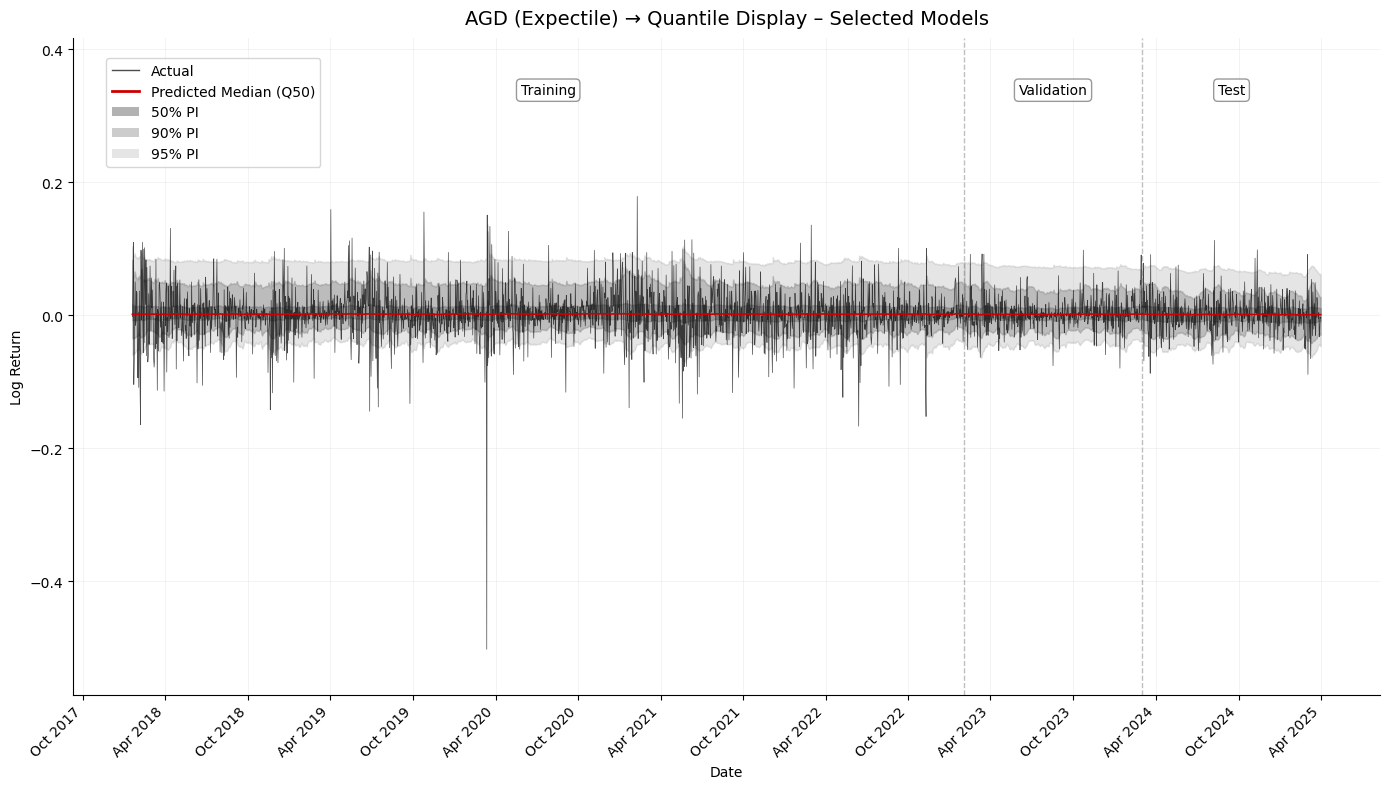

Full timeline plot saved as 'thesis_agd_timeline.png'


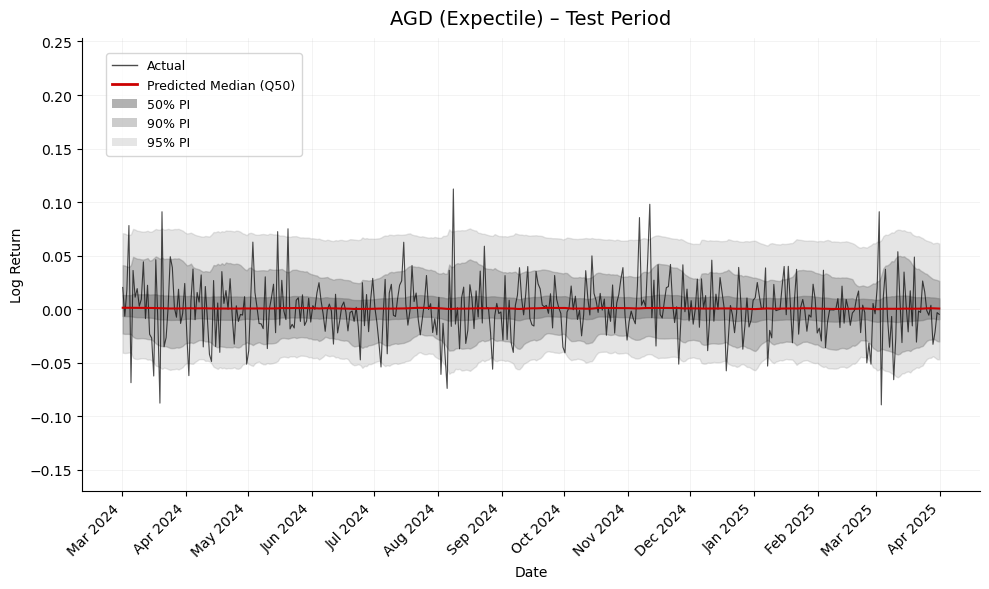

Test period plot saved as 'thesis_agd_testline.png'

Log-return plots saved to 'thesis_agd_timeline.png' and 'thesis_agd_testline.png'
Initial price: $10,988.79


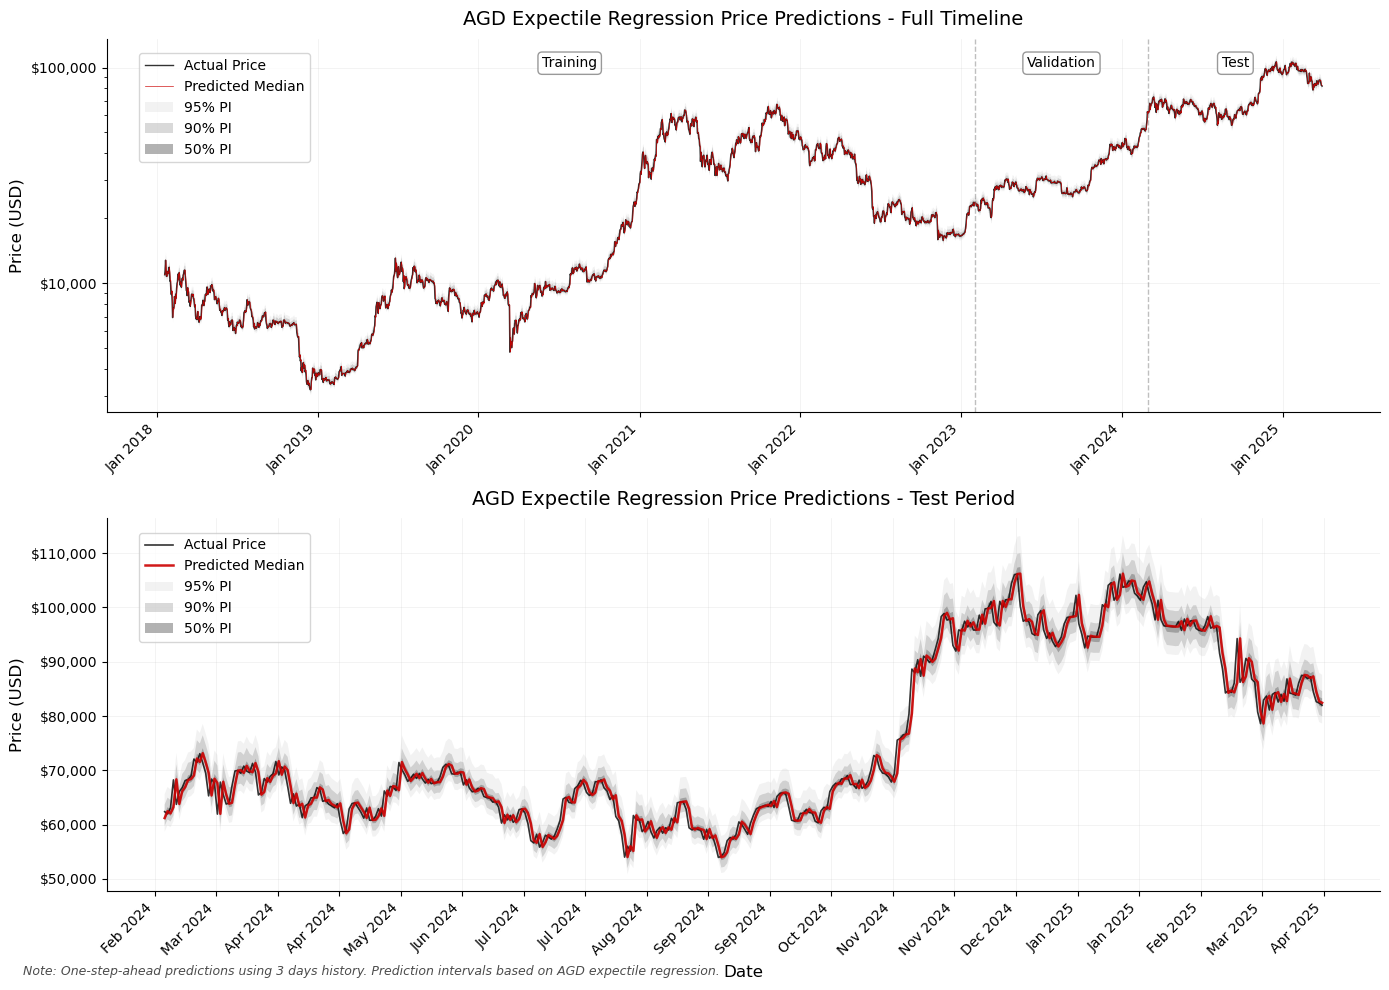

Plot saved as 'thesis_agd_price_predictions.png'
Separate plots saved as 'thesis_agd_price_timeline.png' and 'thesis_agd_price_testline.png'

Price Statistics:
Final actual price: $82,002.02
Final predicted median price: $82,444.07
Final 95% PI: $78,622.53 - $87,603.98

Note: Predictions are based on expectile regression with the following mapping:
  Q0.025 → τ0.053895
  Q0.050 → τ0.102900
  Q0.250 → τ0.334786
  Q0.500 → τ0.519536
  Q0.750 → τ0.706661
  Q0.950 → τ0.952956
  Q0.975 → τ0.990000

Test Period Metrics (Log Returns):
RMSE: 0.027411
MAE: 0.020021

Price prediction plots saved successfully!


In [315]:
def plot_agd_price_predictions(all_predictions, y_all, y_test, df_copy,
                               quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
                               train_ratio=0.70, val_ratio=0.15, seq_length=3,
                               save_path='thesis_agd_price_predictions.png'):
    """
    Convert AGD expectile regression log return predictions to price predictions.
    Shows one-step-ahead predictions converted to prices with expectile-based bands.
    Note: Predictions are keyed by quantiles but represent expectile predictions.
    """
    
    # Convert tensors to numpy if needed
    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()
    
    n_all = len(y_all_np)
    n_test = len(y_test_np)
    
    # Split sizes
    train_size = int(round(train_ratio * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test
    
    # Get dates - convert to numpy array for consistent indexing
    available_dates = pd.to_datetime(df_copy['Date'].iloc[seq_length:seq_length+n_all].values)
    train_dates = available_dates[:train_size]
    val_dates = available_dates[train_size:train_size+val_size]
    test_dates = available_dates[train_size+val_size:]
    
    # Get initial price
    if 'Close' in df_copy.columns:
        initial_price = df_copy['Close'].iloc[seq_length-1]
    else:
        initial_price = 50000  # Default Bitcoin price if not available
    
    print(f"Initial price: ${initial_price:,.2f}")
    
    # Convert actual log returns to prices
    actual_prices = np.zeros(n_all)
    actual_prices[0] = initial_price * np.exp(y_all_np[0])
    for i in range(1, n_all):
        actual_prices[i] = actual_prices[i-1] * np.exp(y_all_np[i])
    
    # Convert expectile predictions to prices
    # Note: all_predictions is keyed by quantiles but contains expectile predictions
    price_expectiles = {}
    
    for q in quantiles:
        if q in all_predictions:
            log_pred = np.asarray(all_predictions[q]).flatten()
            prices = np.zeros(n_all)
            prices[0] = initial_price * np.exp(log_pred[0])
            
            # Use actual previous prices for one-step-ahead predictions
            for i in range(1, n_all):
                prices[i] = actual_prices[i-1] * np.exp(log_pred[i])
            
            price_expectiles[q] = prices
    
    # Get median prediction (Q50/E50) or estimate from Q25/Q75
    if 0.5 in price_expectiles:
        median_prices = price_expectiles[0.5]
    elif 0.25 in price_expectiles and 0.75 in price_expectiles:
        median_prices = 0.5 * (price_expectiles[0.25] + price_expectiles[0.75])
    else:
        # Use mean of available expectiles
        median_prices = np.mean(list(price_expectiles.values()), axis=0)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color scheme - matching thesis style
    actual_color = '#000000'  # Black for actual
    pred_color = '#CC0000'    # Red for predictions
    band_colors = {
        0.95: '#c0c0c0',  # Light gray for 95% CI
        0.9: '#a0a0a0',   # Medium gray for 90% CI
        0.5: '#808080'    # Dark gray for 50% CI
    }
    
    # ---------- Panel 1: Full Timeline ----------
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, median_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Median', alpha=0.9)
    
    # Plot expectile bands (if symmetric quantile keys exist)
    if 0.025 in price_expectiles and 0.975 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.025],
                        price_expectiles[0.975],
                        color=band_colors[0.95],
                        alpha=0.2,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_expectiles and 0.95 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.05],
                        price_expectiles[0.95],
                        color=band_colors[0.9],
                        alpha=0.4,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_expectiles and 0.75 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.25],
                        price_expectiles[0.75],
                        color=band_colors[0.5],
                        alpha=0.6,
                        label='50% PI',
                        edgecolor='none')
    
    # Add vertical lines for splits
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    if val_size > 0:
        ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                    alpha=0.5, linewidth=1)
    
    # Add period labels
    train_mid = train_dates[len(train_dates)//2]
    if val_size > 0:
        val_mid = val_dates[len(val_dates)//2]
    test_mid = test_dates[len(test_dates)//2]
    
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    # Formatting
    ax1.set_title('AGD Expectile Regression Price Predictions - Full Timeline', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Legend
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ---------- Panel 2: Test Period ----------
    test_start_idx = train_size + val_size
    test_actual = actual_prices[test_start_idx:]
    test_median = median_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.2, label='Actual Price')
    ax2.plot(test_dates, test_median, color=pred_color, 
             linewidth=1.8, label='Predicted Median', alpha=0.9)
    
    # Plot expectile bands for test period
    if 0.025 in price_expectiles and 0.975 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.025][test_start_idx:],
                        price_expectiles[0.975][test_start_idx:],
                        color=band_colors[0.95],
                        alpha=0.2,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_expectiles and 0.95 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.05][test_start_idx:],
                        price_expectiles[0.95][test_start_idx:],
                        color=band_colors[0.9],
                        alpha=0.4,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_expectiles and 0.75 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.25][test_start_idx:],
                        price_expectiles[0.75][test_start_idx:],
                        color=band_colors[0.5],
                        alpha=0.6,
                        label='50% PI',
                        edgecolor='none')
    
    # Formatting
    ax2.set_title('AGD Expectile Regression Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Reduce date labels
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    # Legend
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add note
    fig.text(0.02, 0.02, 
             f'Note: One-step-ahead predictions using {seq_length} days history. ' + 
             'Prediction intervals based on AGD expectile regression.',
             transform=fig.transFigure, fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save as separate plots
    # Plot 1: Full Timeline
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, median_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Median', alpha=0.9)
    
    # Plot expectile bands
    if 0.025 in price_expectiles and 0.975 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.025],
                        price_expectiles[0.975],
                        color=band_colors[0.95],
                        alpha=0.4,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_expectiles and 0.95 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.05],
                        price_expectiles[0.95],
                        color=band_colors[0.9],
                        alpha=0.6,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_expectiles and 0.75 in price_expectiles:
        ax1.fill_between(available_dates,
                        price_expectiles[0.25],
                        price_expectiles[0.75],
                        color=band_colors[0.5],
                        alpha=0.8,
                        label='50% PI',
                        edgecolor='none')
    
    # Add vertical lines
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    if val_size > 0:
        ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                    alpha=0.5, linewidth=1)
    
    # Add period labels
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    ax1.set_title('AGD Expectile Regression Price Predictions', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_agd_price_timeline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Test Period
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    test_actual = actual_prices[test_start_idx:]
    test_median = median_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.5, label='Actual Price')
    ax2.plot(test_dates, test_median, color=pred_color, 
             linewidth=0.8, label='Predicted Median', alpha=0.9)
    
    # Plot expectile bands for test period
    if 0.025 in price_expectiles and 0.975 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.025][test_start_idx:],
                        price_expectiles[0.975][test_start_idx:],
                        color=band_colors[0.95],
                        alpha=0.4,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_expectiles and 0.95 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.05][test_start_idx:],
                        price_expectiles[0.95][test_start_idx:],
                        color=band_colors[0.9],
                        alpha=0.6,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_expectiles and 0.75 in price_expectiles:
        ax2.fill_between(test_dates,
                        price_expectiles[0.25][test_start_idx:],
                        price_expectiles[0.75][test_start_idx:],
                        color=band_colors[0.5],
                        alpha=0.8,
                        label='50% PI',
                        edgecolor='none')
    
    ax2.set_title('AGD Expectile Regression Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_agd_price_testline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Plot saved as '{save_path}'")
    print("Separate plots saved as 'thesis_agd_price_timeline.png' and 'thesis_agd_price_testline.png'")
    
    # Print statistics
    print(f"\nPrice Statistics:")
    print(f"Final actual price: ${actual_prices[-1]:,.2f}")
    print(f"Final predicted median price: ${median_prices[-1]:,.2f}")
    
    if 0.025 in price_expectiles and 0.975 in price_expectiles:
        print(f"Final 95% PI: ${price_expectiles[0.025][-1]:,.2f} - ${price_expectiles[0.975][-1]:,.2f}")
    
    # Get quantile to expectile mapping for display
    q2e_mapping = get_quantile_to_expectile_mapping()
    print("\nNote: Predictions are based on expectile regression with the following mapping:")
    for q in quantiles:
        if q in q2e_mapping:
            print(f"  Q{q:.3f} → τ{q2e_mapping[q]:.6f}")
    
    # Calculate prediction accuracy metrics on test set
    test_actual_log = y_test_np
    if 0.5 in all_predictions:
        test_pred_log = all_predictions[0.5][-n_test:]
    else:
        # If no Q50, calculate median from log returns
        test_pred_log = np.zeros(n_test)
        for i in range(n_test):
            test_pred_log[i] = np.log(median_prices[test_start_idx + i] / 
                                     (actual_prices[test_start_idx + i - 1] if i > 0 else actual_prices[test_start_idx - 1]))
    
    rmse = np.sqrt(np.mean((test_actual_log - test_pred_log)**2))
    mae = np.mean(np.abs(test_actual_log - test_pred_log))
    
    print(f"\nTest Period Metrics (Log Returns):")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    
    return fig, actual_prices, median_prices, price_expectiles


# Updated run_agd_model_selection_nrepeats_with_price function
def run_agd_model_selection_nrepeats_with_price(X_all, y_all, df_copy,
                                                quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                                n_repeats=15):
    """
    Run AGD model selection using quantile-to-expectile mapping with price predictions.
    Predictions are stored by original quantile keys for plotting.
    """
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    q2e_mapping = get_quantile_to_expectile_mapping()
    expectiles = []
    for q in quantiles:
        if q not in q2e_mapping:
            raise ValueError(f"No expectile mapping found for quantile {q}")
        expectiles.append(q2e_mapping[q])

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nQuantile to Expectile Mapping:")
    for q, tau in zip(quantiles, expectiles):
        print(f"  Quantile {q:.3f} → Expectile {tau:.6f}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for q, tau in zip(quantiles, expectiles):
        print(f"\n===== Quantile {q*100:.1f}% (Expectile {tau:.6f}) =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        # keep original quantile keys for plotting
        best_predictions_full[q] = y_pred_all

        selection_summary[q] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'train_coverage': best['train_coverage'],
            'val_coverage': best['val_coverage'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Generate log-return plots (thesis-style)
    plot_quantiles_formatted(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='thesis_agd_timeline.png',
        out_test_png='thesis_agd_testline.png'
    )
    print("\nLog-return plots saved to 'thesis_agd_timeline.png' and 'thesis_agd_testline.png'")
    
    # Generate price prediction plots
    fig, actual_prices, median_prices, price_expectiles = plot_agd_price_predictions(
        best_predictions_full,
        y_all,
        y_test,
        df_copy,
        quantiles=quantiles,
        train_ratio=0.70,
        val_ratio=0.15,
        seq_length=3,
        save_path='thesis_agd_price_predictions.png'
    )
    print("\nPrice prediction plots saved successfully!")

    return best_predictions_full, selection_summary, actual_prices, median_prices, price_expectiles

# Usage example for AGD with price predictions
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with quantiles (will be converted to expectiles internally)
    # This now includes price prediction plots
    best_predictions, selection_summary, actual_prices, median_prices, price_expectiles = \
        run_agd_model_selection_nrepeats_with_price(
            X_all, y_all, df_copy,
            quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
            n_repeats=25
        )

AGD EXPECTILE REGRESSION - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
COMPOSITE SCORING: 60% Coverage + 40% NLL
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Quantile to Expectile Mapping:
  Quantile 0.025 → Expectile 0.053895
  Quantile 0.050 → Expectile 0.102900
  Quantile 0.250 → Expectile 0.334786
  Quantile 0.500 → Expectile 0.519536
  Quantile 0.750 → Expectile 0.706661
  Quantile 0.950 → Expectile 0.952956
  Quantile 0.975 → Expectile 0.990000

===== Quantile 2.5% (Expectile 0.053895) =====

Training 25 models for expectile 0.053895 with best hyperparameters
  Repeat 1: score=0.5329 | Val_CRP=0.388 Test_CRP=0.297
  Repeat 2: score=0.5530 | Val_CRP=0.717 Test_CRP=0.531
  Repeat 3: score=0.5603 | Val_CRP=0.812 Test_CRP=0.672
  Repeat 4: score=0.5385 | Val_CRP=0.247 Test_CRP=0.031
  Repeat 5: score=0.5590 | Val_CRP=0.529 Test_CRP=0.438
  Repeat 6: score=0.5436 | Val_CRP=0.482 Test_CRP=0.391
  Repeat 7: score=0.5380 | Val_CRP=0.388 Test_CRP=0

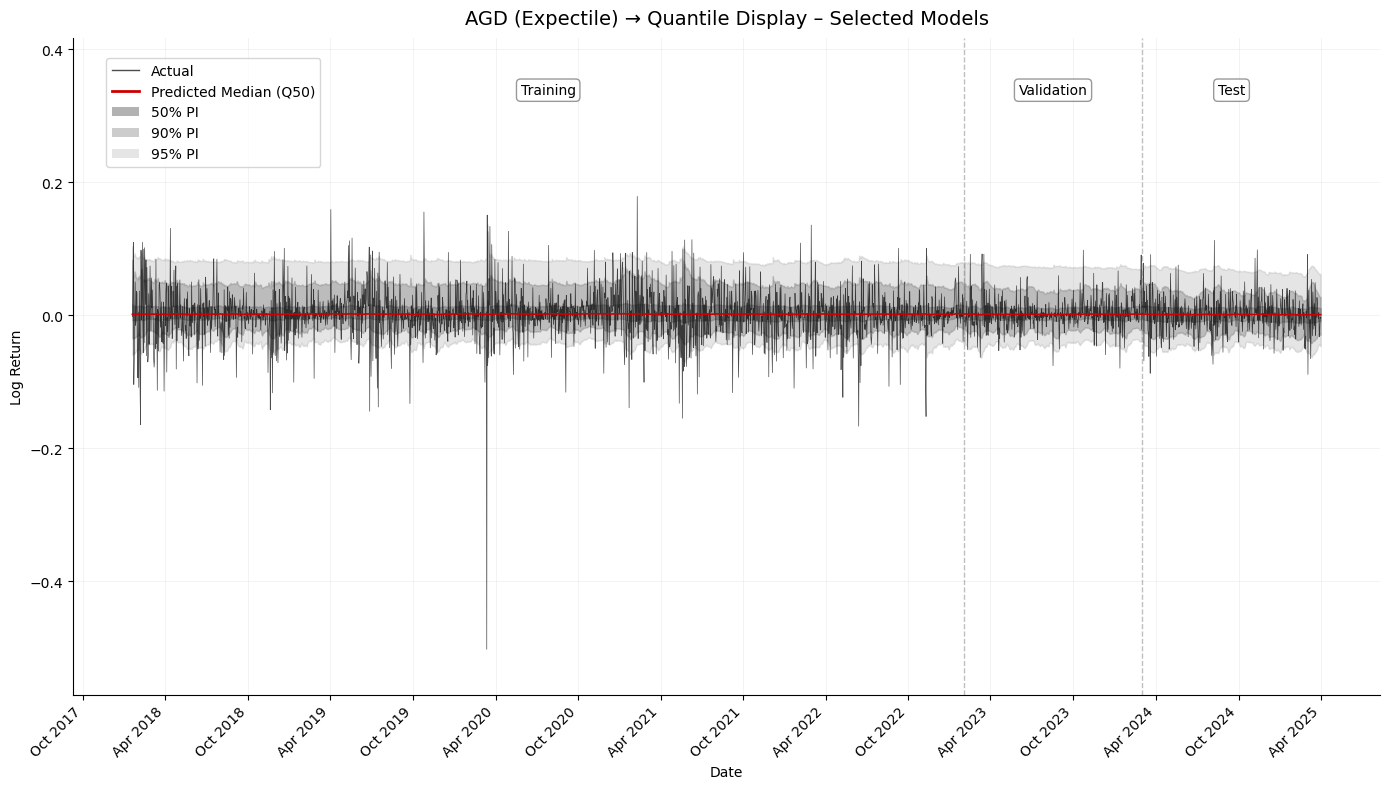

Full timeline plot saved as 'thesis_agd_timeline.png'


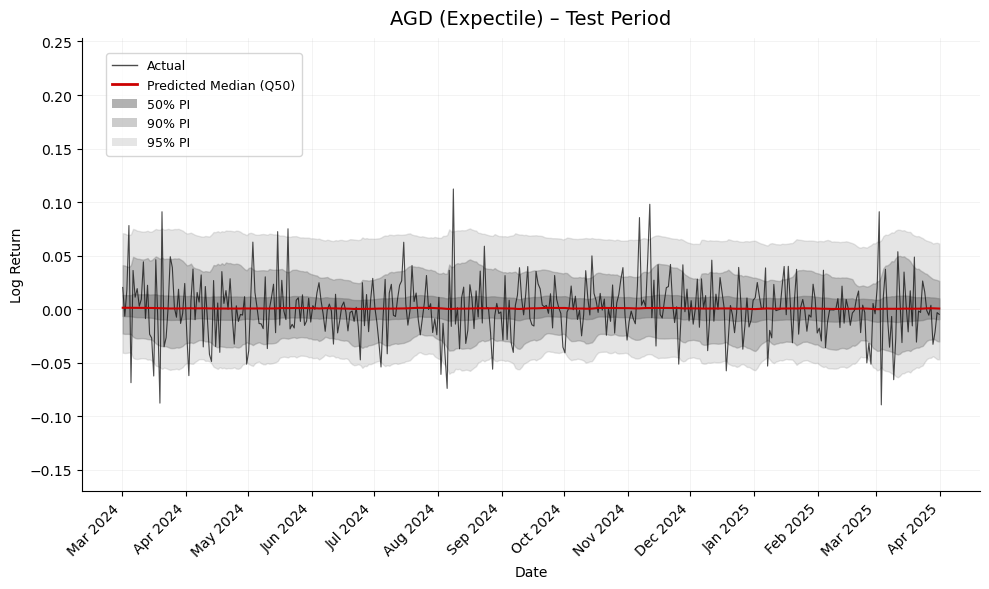

Test period plot saved as 'thesis_agd_testline.png'

Log-return plots saved to 'thesis_agd_timeline.png' and 'thesis_agd_testline.png'
Initial price: $10,988.79


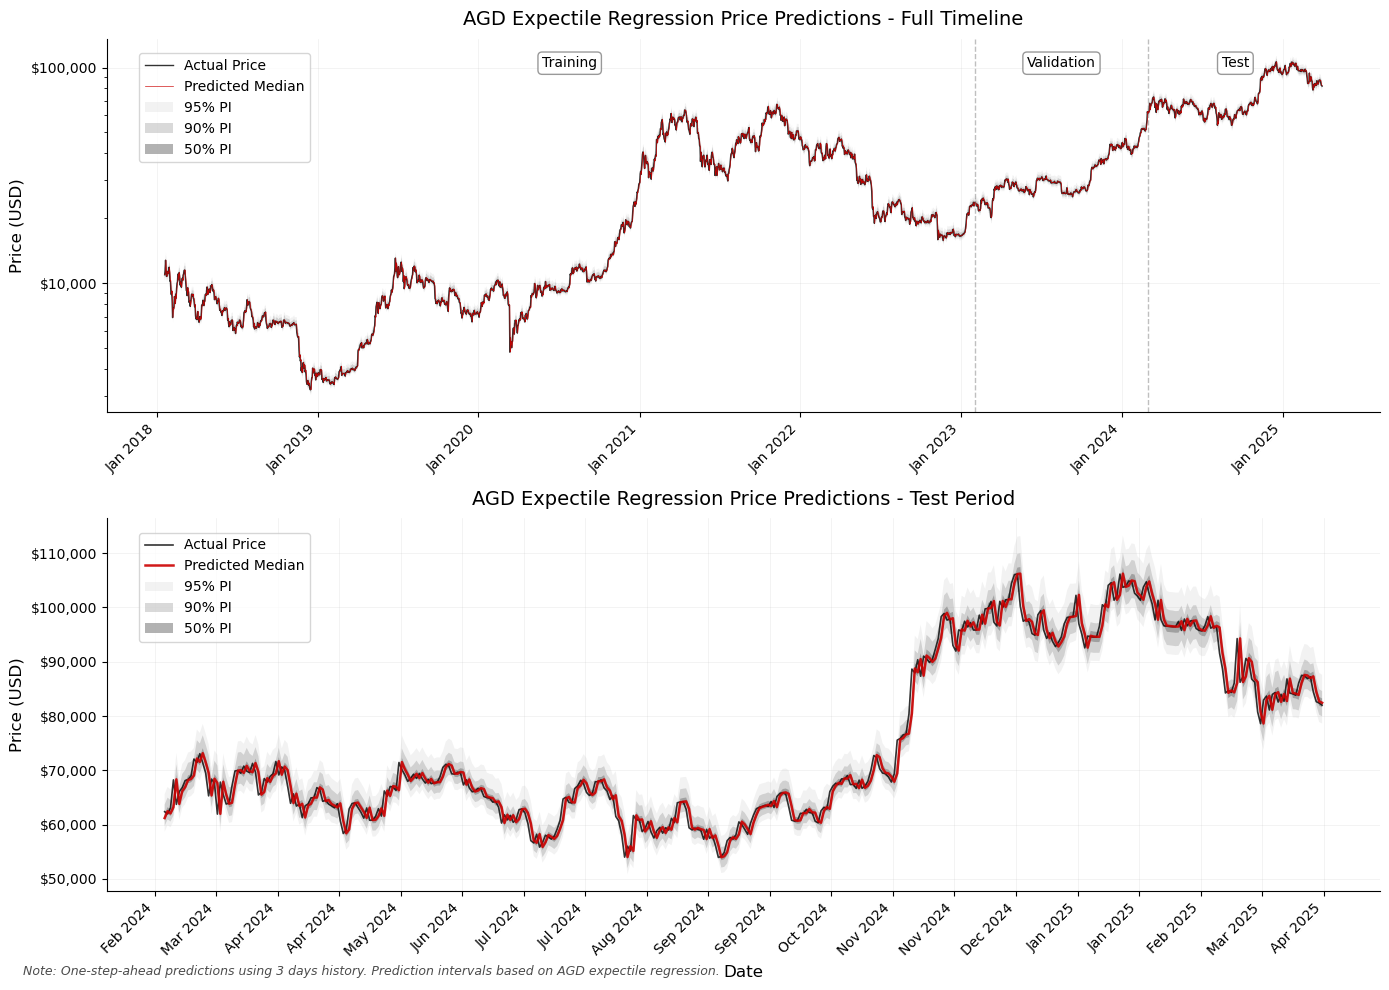

Plot saved as 'thesis_agd_price_predictions.png'
Separate plots saved as 'thesis_agd_price_timeline.png' and 'thesis_agd_price_testline.png'

Price Statistics:
Final actual price: $82,002.02
Final predicted median price: $82,444.07
Final 95% PI: $78,622.53 - $87,603.98

Note: Predictions are based on expectile regression with the following mapping:
  Q0.025 → τ0.053895
  Q0.050 → τ0.102900
  Q0.250 → τ0.334786
  Q0.500 → τ0.519536
  Q0.750 → τ0.706661
  Q0.950 → τ0.952956
  Q0.975 → τ0.990000

Test Period Metrics (Log Returns):
RMSE: 0.027411
MAE: 0.020021

Price prediction plots saved successfully!


In [341]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Quantile to Expectile Mapping
# -------------------------
def get_quantile_to_expectile_mapping():
    """Returns the mapping from quantiles to expectiles"""
    mapping = {
        0.025: 0.053895,
        0.050: 0.102900,
        0.250: 0.334786,
        0.500: 0.519536,
        0.750: 0.706661,
        0.950: 0.952956,
        0.975: 0.990000
    }
    return mapping

def quantile_to_expectile(quantile):
    """Convert a quantile to its corresponding expectile"""
    mapping = get_quantile_to_expectile_mapping()
    if quantile in mapping:
        return mapping[quantile]
    else:
        # For quantiles not in the mapping, you might want to interpolate
        # or raise an error. Here we'll raise an error.
        raise ValueError(f"No expectile mapping found for quantile {quantile}")

# -------------------------
# 3. Model Definition with LayerNorm
# -------------------------
class AsymmetricGaussianExpectile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            if dropout > 0:  # Only add dropout if > 0
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 4. Loss Function for AGD
# -------------------------
def agd_nll_loss(y_true, y_pred, config):
    """
    AGD negative log-likelihood for training
    """
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    device = y_true.device
    dtype = y_true.dtype
    
    residual = y_true - y_pred
    indicator = (residual < 0).float()
    weight = torch.abs(tau - indicator)
    
    # Create all constants on the same device
    tau_tensor = torch.tensor(tau, device=device, dtype=dtype)
    sigma_tensor = torch.tensor(sigma, device=device, dtype=dtype)
    pi_tensor = torch.tensor(torch.pi, device=device, dtype=dtype)
    
    sqrt_1_minus_tau = torch.sqrt(1/(1-tau_tensor))
    sqrt_tau = torch.sqrt(1/tau_tensor)
    norm = sqrt_1_minus_tau + sqrt_tau
    
    nll = torch.log(sigma_tensor) + 0.5*torch.log(pi_tensor)
    nll = nll + torch.log(norm) + weight * (residual**2) / (sigma_tensor**2)
    
    return nll.mean()

# -------------------------
# 5. Get Best Hyperparameters with LayerNorm (Updated with Expectiles)
# -------------------------
def get_best_hyperparameters_from_agd_tuning():
    """
    Returns the best hyperparameters from AGD tuning results with LayerNorm & LR Scheduling
    Now using expectile values instead of quantiles
    """
    # Get the quantile to expectile mapping
    q2e_mapping = get_quantile_to_expectile_mapping()
    
    # Original hyperparameters keyed by quantiles
    quantile_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Convert to expectile-based dictionary
    expectile_hyperparams = {}
    for quantile, expectile in q2e_mapping.items():
        if quantile in quantile_hyperparams:
            expectile_hyperparams[expectile] = quantile_hyperparams[quantile].copy()
            expectile_hyperparams[expectile]['tau'] = expectile
            expectile_hyperparams[expectile]['corresponding_quantile'] = quantile
    
    return expectile_hyperparams

# -------------------------
# 6. Train Single Model with LR Scheduler
# -------------------------
def train_single_agd_model(X_train, y_train, X_val, y_val, config):
    """Train a single AGD model with given configuration and LR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricGaussianExpectile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = agd_nll_loss(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = agd_nll_loss(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 7. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 8. Scoring Functions
# -------------------------
def nll_based_score(train_loss, val_loss, test_loss):
    """
    Simple NLL-based scoring:
    Score = 0.30×Train_NLL + 0.40×Val_NLL + 0.30×Test_NLL
    Lower is better
    """
    score = 0.30 * train_loss + 0.40 * val_loss + 0.30 * test_loss
    return score

def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)
    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)
    # normalize losses w.r.t. data scale (like your earlier approach)
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)
    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0
    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)
    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 9. 5-repeat selection per expectile (uses same criteria) - UPDATED
# -------------------------
def train_agd_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=10):
    best_hps = get_best_hyperparameters_from_agd_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for expectile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for expectile {tau:.6f} with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_agd_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            # In train_agd_with_repeats function, replace these lines:
            train_loss = agd_nll_loss(yt, pt, config).item()
            val_loss   = agd_nll_loss(yv, pv, config).item()
            test_loss  = agd_nll_loss(ys, ps, config).item()

        # to numpy for coverage calc
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        score, metrics = composite_score_coverage_loss(
        y_train, pt_np, y_val, pv_np, y_test, ps_np, tau,
        train_loss, val_loss, test_loss
    )

        results.append({
            'seed': seed,
            'score': score,
            'metrics': metrics,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'train_coverage': metrics['train']['actual_coverage'],
            'val_coverage': metrics['val']['actual_coverage'],
            'test_coverage': metrics['test']['actual_coverage'],
            'expected_coverage': metrics['train']['target_coverage'],
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Val_CRP={metrics['val']['coverage_ratio_penalty']:.3f} "
              f"Test_CRP={metrics['test']['coverage_ratio_penalty']:.3f}")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (tie-break on val CRP)
    results.sort(key=lambda d: d['score'])
    best_score = results[0]['score']
    tied = [d for d in results if abs(d['score'] - best_score) < 1e-6]
    if len(tied) > 1:
        tied.sort(key=lambda d: d['metrics']['val']['coverage_ratio_penalty'])
        best = tied[0]
    else:
        best = results[0]

    print(f"Best seed {best['seed']} with score {best['score']:.4f}")
    return best, results  # Now returns all results, not just the best

# -------------------------
# 10. Run model selection with n repeats - UPDATED
# -------------------------
def run_agd_model_selection_nrepeats_with_price(X_all, y_all, df_copy,
                                                quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                                n_repeats=15):
    """
    Run AGD model selection using quantile-to-expectile mapping with price predictions.
    Predictions are stored by original quantile keys for plotting.
    """
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    q2e_mapping = get_quantile_to_expectile_mapping()
    expectiles = []
    for q in quantiles:
        if q not in q2e_mapping:
            raise ValueError(f"No expectile mapping found for quantile {q}")
        expectiles.append(q2e_mapping[q])

    print("="*60)
    print(f"AGD EXPECTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("COMPOSITE SCORING: 60% Coverage + 40% NLL")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("\nQuantile to Expectile Mapping:")
    for q, tau in zip(quantiles, expectiles):
        print(f"  Quantile {q:.3f} → Expectile {tau:.6f}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}
    all_train_results = {}  # NEW: Store all training results

    for q, tau in zip(quantiles, expectiles):
        print(f"\n===== Quantile {q*100:.1f}% (Expectile {tau:.6f}) =====")
        best, all_repeats = train_agd_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        # Store all training results for this quantile
        all_train_results[q] = all_repeats  # NEW

        cfg = get_best_hyperparameters_from_agd_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricGaussianExpectile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        # keep original quantile keys for plotting
        best_predictions_full[q] = y_pred_all

        selection_summary[q] = {
            'expectile': tau,
            'seed': best['seed'],
            'score': best['score'],
            'metrics': best['metrics'],  # Include full metrics
            'train_loss': best['train_loss'],
            'val_loss': best['val_loss'],
            'test_loss': best['test_loss'],
            'train_coverage': best['train_coverage'],
            'val_coverage': best['val_coverage'],
            'test_coverage': best['test_coverage'],
            'expected_coverage': best['expected_coverage']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # Generate log-return plots (thesis-style)
    plot_quantiles_formatted(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        train_ratio=0.70, val_ratio=0.15, seq_length=3,
        out_timeline_png='thesis_agd_timeline.png',
        out_test_png='thesis_agd_testline.png'
    )
    print("\nLog-return plots saved to 'thesis_agd_timeline.png' and 'thesis_agd_testline.png'")
    
    # Generate price prediction plots
    fig, actual_prices, median_prices, price_expectiles = plot_agd_price_predictions(
        best_predictions_full,
        y_all,
        y_test,
        df_copy,
        quantiles=quantiles,
        train_ratio=0.70,
        val_ratio=0.15,
        seq_length=3,
        save_path='thesis_agd_price_predictions.png'
    )
    print("\nPrice prediction plots saved successfully!")

    return best_predictions_full, selection_summary, all_train_results, actual_prices, median_prices, price_expectiles  # NEW: Return all_train_results

# -------------------------
# 11. Thesis-style plotting (central = Q50; 50/90/95% bands)
# -------------------------
def plot_quantiles_formatted(
    all_predictions,               # dict: {quantile -> np.array over full timeline}
    y_all,                         # full actual y
    y_test,                        # test actual y (length defines split)
    df_copy,                       # 'Date' column or DatetimeIndex
    quantiles,                     # list of quantiles present in all_predictions
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='agd_timeline_thesis.png',
    out_test_png='agd_testline_thesis.png'
):
    # --- Dates aligned to end of each seq ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np  = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all  = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(train_ratio * n_all))
    val_size   = n_all - train_size - n_test
    test_size  = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if possible; else mid(Q25,Q75); else mean of available curves
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]
    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors
    actual_color = '#000000'
    pred_color   = '#CC0000'
    pi_color     = '#808080'

    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    ax.set_title('AGD (Expectile) → Quantile Display – Selected Models', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4*y_rng_t, y_max_t + 0.7*y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('AGD (Expectile) – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date'); ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    print(f"Test period plot saved as '{out_test_png}'")


if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with quantiles (will be converted to expectiles internally)
    # This now includes price prediction plots and all training results
    best_predictions, selection_summary, all_train_results, actual_prices, median_prices, price_expectiles = \
        run_agd_model_selection_nrepeats_with_price(
            X_all, y_all, df_copy,
            quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
            n_repeats=25
        )
    

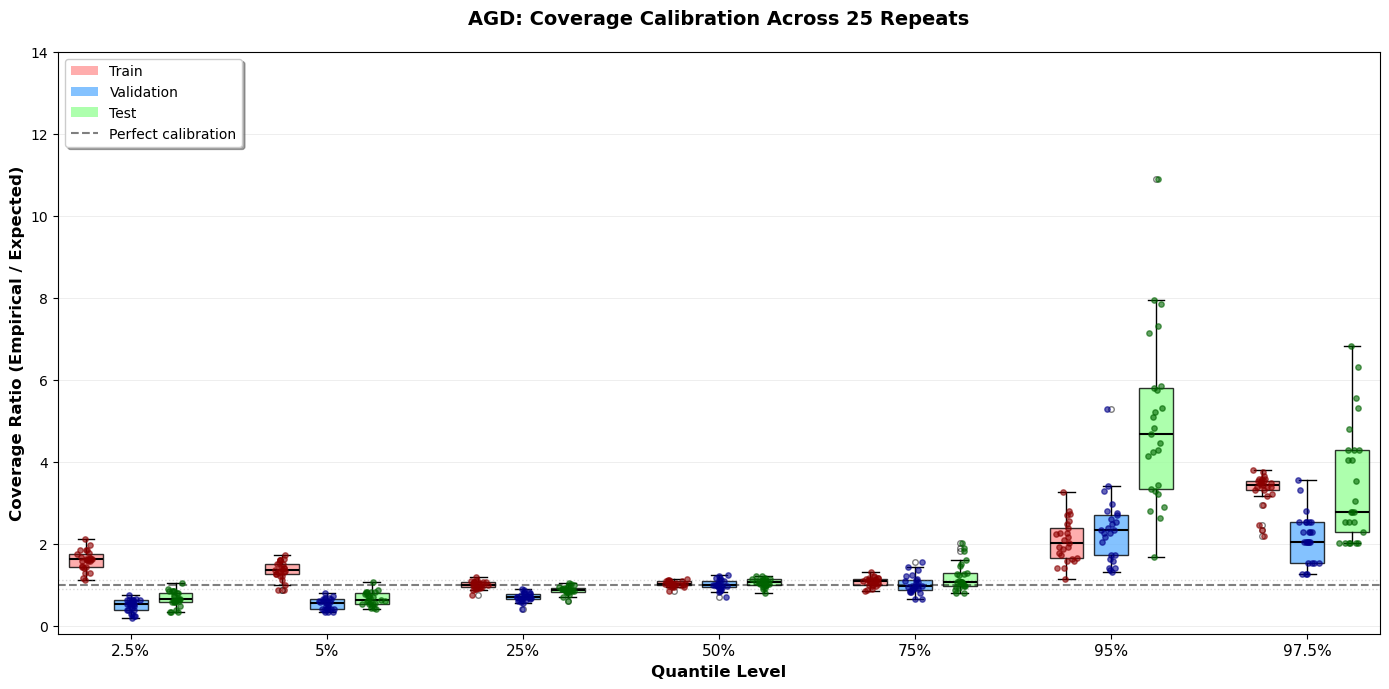

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_coverage_ratio_boxplot_agd(all_train_results, levels, model_name="AGD", save_path=None):
    """
    Plot coverage ratio boxplot for AGD model
    Note: levels are quantile values, but AGD uses expectiles internally
    """
    rng = np.random.default_rng(42)
    levels = sorted(levels)
    
    # Get quantile to expectile mapping
    q2e_mapping = get_quantile_to_expectile_mapping()

    train_ratios_by_lvl, val_ratios_by_lvl, test_ratios_by_lvl = [], [], []
    labels = []

    for lvl in levels:
        reps = all_train_results.get(lvl, [])
        tr_list, va_list, te_list = [], [], []

        # For AGD, we use the expectile value for coverage calculation
        # but the data is keyed by quantile level
        expectile = q2e_mapping.get(lvl, lvl)
        
        # Expected tail coverage based on expectile
        expected = expectile if expectile <= 0.5 else (1 - expectile)

        for rep in reps:
            # Direct access to metrics
            metrics = rep.get('metrics', {})

            # Get coverage ratios directly
            r_tr = metrics.get('train', {}).get('coverage_ratio', np.nan)
            r_va = metrics.get('val', {}).get('coverage_ratio', np.nan)
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)

            # If coverage_ratio not available, calculate from actual_coverage
            if np.isnan(r_tr):
                cov_tr = metrics.get('train', {}).get('actual_coverage', np.nan)
                r_tr = cov_tr / expected if np.isfinite(cov_tr) and expected > 0 else np.nan
            if np.isnan(r_va):
                cov_va = metrics.get('val', {}).get('actual_coverage', np.nan)
                r_va = cov_va / expected if np.isfinite(cov_va) and expected > 0 else np.nan
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan

            tr_list.append(r_tr)
            va_list.append(r_va)
            te_list.append(r_te)

        train_ratios_by_lvl.append([r for r in tr_list if np.isfinite(r)])
        val_ratios_by_lvl.append([r for r in va_list if np.isfinite(r)])
        test_ratios_by_lvl.append([r for r in te_list if np.isfinite(r)])
        
        # Format labels based on quantile value
        if lvl == 0.025:
            labels.append("2.5%")
        elif lvl == 0.05:
            labels.append("5%")
        elif lvl == 0.975:
            labels.append("97.5%")
        else:
            labels.append(f"{int(lvl*100)}%")

    # x positions with more spacing
    K = len(levels)
    spacing = 3.5
    pos_tr = [i*spacing + 0.8 for i in range(K)]
    pos_va = [i*spacing + 1.6 for i in range(K)]
    pos_te = [i*spacing + 2.4 for i in range(K)]

    plt.figure(figsize=(14, 7))
    
    # boxplots
    bp1 = plt.boxplot(train_ratios_by_lvl, positions=pos_tr, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#ff9999", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp2 = plt.boxplot(val_ratios_by_lvl, positions=pos_va, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#66b3ff", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp3 = plt.boxplot(test_ratios_by_lvl, positions=pos_te, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#99ff99", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))

    # overlay individual points with jitter
    for i in range(K):
        # train
        T = train_ratios_by_lvl[i]
        if T:
            x = rng.normal(pos_tr[i], 0.08, len(T))
            plt.scatter(x, T, s=15, color='darkred', alpha=0.6, zorder=3)
        # val
        V = val_ratios_by_lvl[i]
        if V:
            x = rng.normal(pos_va[i], 0.08, len(V))
            plt.scatter(x, V, s=15, color='darkblue', alpha=0.6, zorder=3)
        # test
        E = test_ratios_by_lvl[i]
        if E:
            x = rng.normal(pos_te[i], 0.08, len(E))
            plt.scatter(x, E, s=15, color='darkgreen', alpha=0.6, zorder=3)

    # perfect ratio line
    plt.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=1.5, label='Perfect calibration (ratio = 1.0)')
    
    # Add light horizontal lines at 0.9 and 1.1 for reference
    plt.axhline(0.9, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    plt.axhline(1.1, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    
    # y-limits
    all_vals = [v for grp in (train_ratios_by_lvl + val_ratios_by_lvl + test_ratios_by_lvl) for v in grp]
    if all_vals:
        y_min = -0.2
        y_max = 14.0
    else:
        y_min, y_max = 0.5, 1.5
    plt.ylim(y_min, y_max)

    # x-axis
    tick_pos = [(pos_tr[i] + pos_te[i]) / 2 for i in range(K)]
    plt.xticks(tick_pos, labels, fontsize=11)
    plt.xlabel('Quantile Level', fontsize=12, fontweight='bold')
    plt.ylabel('Coverage Ratio (Empirical / Expected)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Coverage Calibration Across 25 Repeats', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        Patch(facecolor="#ff9999", alpha=0.8, label="Train"),
        Patch(facecolor="#66b3ff", alpha=0.8, label="Validation"),
        Patch(facecolor="#99ff99", alpha=0.8, label="Test"),
        plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect calibration')
    ]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10, 
               fancybox=True, shadow=True)
    
    plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage for AGD
levels = sorted(all_train_results.keys())
plot_coverage_ratio_boxplot_agd(
    all_train_results=all_train_results,
    levels=levels,
    model_name="AGD",
    save_path="thesis_agd_coverage_ratio_boxplot.png"
)

Data splits: Total=2630, Train=1840, Val=394, Test=396
Predictions length: 2630
Extracting test period from full predictions...
Final test data shape: 396
Quantiles available: [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]

AGD MODEL COMPREHENSIVE SUMMARY (via Expectile Mapping)

1. MODEL SELECTION RESULTS WITH FULL METRICS
-------------------------------------------------------------------------------------------------------------------------------------------------
Quantile   Expectile    ET Target  Seed     Score      Train NLL    Val NLL      Test NLL     Train Cov    Val Cov      Test Cov     Test QL     
-------------------------------------------------------------------------------------------------------------------------------------------------
    2.5%     0.053895      0.025     4225     0.5289      1.0474      1.0446      1.0448       0.086       0.028       0.043      0.0018
    5.0%     0.102900      0.050     3625     0.4988      0.8031      0.7989      0.7995       0.177  

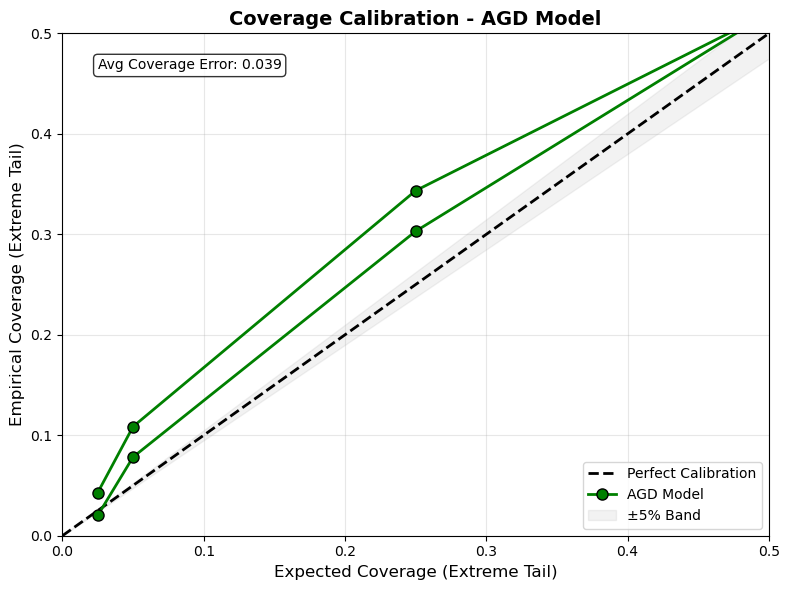

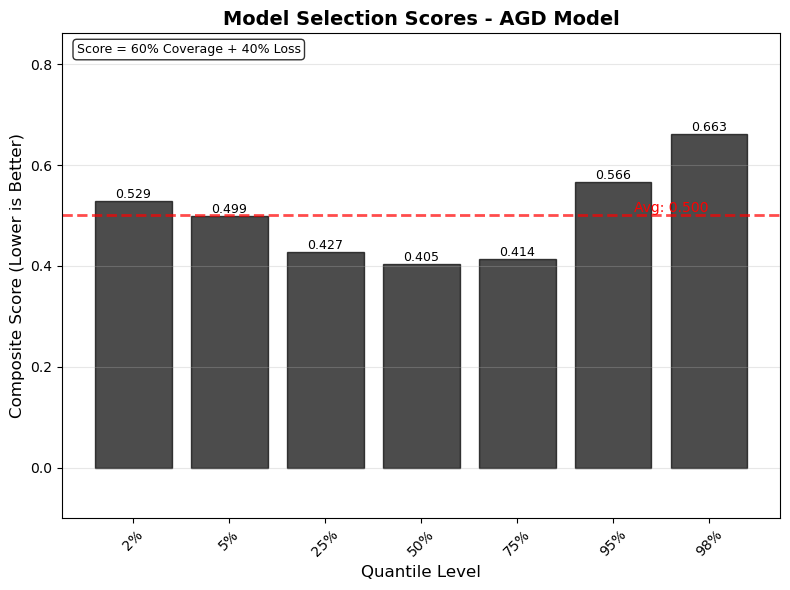


2. QUANTILE CROSSING CHECK
-------------------------------------------------------------------------------------------------------------------------------------------------
No quantile crossing detected


In [317]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_agd_results_consolidated(best_predictions, selection_summary, X_all, y_all):
    """Consolidated analysis of AGD model results with key visualizations"""
    
    # Get test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    n_test = n_all - test_start_idx
    
    # Convert y_all to numpy
    if isinstance(y_all, torch.Tensor):
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Debug information
    print(f"Data splits: Total={n_all}, Train={train_size}, Val={val_size}, Test={n_test}")
    
    # Check what we have in best_predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    print(f"Predictions length: {pred_length}")
    
    # Determine if predictions are for full dataset or test only
    agd_test_predictions = {}
    
    if pred_length == n_all:
        print("Extracting test period from full predictions...")
        for quantile in best_predictions.keys():
            agd_test_predictions[quantile] = np.array(best_predictions[quantile])[test_start_idx:]
    elif abs(pred_length - n_test) < 5:
        print("Using test-only predictions...")
        min_len = min(pred_length, n_test)
        y_test = y_test[:min_len]
        for quantile in best_predictions.keys():
            agd_test_predictions[quantile] = np.array(best_predictions[quantile])[:min_len]
    else:
        raise ValueError(f"Cannot match prediction length {pred_length}")
    
    print(f"Final test data shape: {len(y_test)}")
    print(f"Quantiles available: {sorted(agd_test_predictions.keys())}")
    
    print("\n" + "="*145)
    print("AGD MODEL COMPREHENSIVE SUMMARY (via Expectile Mapping)")
    print("="*145)
    
    # Model Selection Results
    print("\n1. MODEL SELECTION RESULTS WITH FULL METRICS")
    print("-"*145)
    print(f"{'Quantile':<10} {'Expectile':<12} {'ET Target':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12} {'Test QL':<12}")
    print("-"*145)
    
    coverage_errors = []
    expected_coverages = []
    quantile_losses = []
    
    for q in sorted(selection_summary.keys()):
        s = selection_summary[q]
        
        # Calculate test coverage - extreme tail
        y_pred = agd_test_predictions[q].flatten()
        y_test_flat = y_test.flatten()
        
        if q <= 0.5:
            actual_test_coverage = np.mean(y_test_flat <= y_pred)
            expected_coverage = q
        else:
            actual_test_coverage = np.mean(y_test_flat > y_pred)
            expected_coverage = 1 - q
            
        coverage_errors.append(abs(actual_test_coverage - expected_coverage))
        expected_coverages.append(expected_coverage)
        
        # Calculate quantile loss
        errors = y_test_flat - y_pred
        ql = np.mean(np.where(errors > 0, q * errors, (q - 1) * errors))
        quantile_losses.append(ql)
        
        # Get expectile value
        expectile = s['expectile']
        
        # Get coverages from selection summary
        train_cov = s.get('train_coverage', 'N/A')
        val_cov = s.get('val_coverage', 'N/A')
        
        print(f"{q*100:>7.1f}% {expectile:>12.6f} {expected_coverage:>10.3f} {s['seed']:>8} {s['score']:>10.4f} "
              f"{s['train_loss']:>11.4f} {s['val_loss']:>11.4f} {s['test_loss']:>11.4f} "
              f"{train_cov:>11.3f} {val_cov:>11.3f} {actual_test_coverage:>11.3f} {ql:>11.4f}")
    
    # Summary statistics
    print("\n" + "-"*145)
    print(f"{'AVERAGES':<10} {'':<12} {'':<10} {'':<8} "
          f"{np.mean([s['score'] for s in selection_summary.values()]):>10.4f} "
          f"{np.mean([s['train_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['val_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['test_loss'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['train_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['val_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['test_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean(quantile_losses):>11.4f}")
    print("="*145)
    
    # Create and save plots separately
    # Plot 1: Coverage Calibration Plot
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    
    quantiles = sorted(agd_test_predictions.keys())
    actual_coverages = []
    expected_coverages_plot = []
    
    for q in quantiles:
        y_pred = agd_test_predictions[q].flatten()
        
        if q <= 0.5:
            actual_coverage = np.mean(y_test.flatten() <= y_pred)
            expected = q
        else:
            actual_coverage = np.mean(y_test.flatten() > y_pred)
            expected = 1 - q
            
        actual_coverages.append(actual_coverage)
        expected_coverages_plot.append(expected)
    
    # Perfect calibration line
    ax1.plot([0, 0.5], [0, 0.5], 'k--', linewidth=2, label='Perfect Calibration')
    
    # Model calibration
    ax1.plot(expected_coverages_plot, actual_coverages, 'go-', linewidth=2, markersize=8, 
             label='AGD Model', markeredgecolor='black', markeredgewidth=1)
    
    # Shaded acceptable region
    x_range = np.linspace(0, 0.5, 100)
    ax1.fill_between(x_range, x_range * 0.95, x_range * 1.05, alpha=0.1, color='gray', label='±5% Band')
    
    ax1.set_xlabel('Expected Coverage (Extreme Tail)', fontsize=12)
    ax1.set_ylabel('Empirical Coverage (Extreme Tail)', fontsize=12)
    ax1.set_title('Coverage Calibration - AGD Model', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)
    ax1.legend(loc='lower right')
    
    # Add coverage error text
    avg_coverage_error = np.mean(np.abs(np.array(actual_coverages) - np.array(expected_coverages_plot)))
    ax1.text(0.05, 0.95, f'Avg Coverage Error: {avg_coverage_error:.3f}', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig1.savefig('agd_coverage_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Composite Score Plot
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    
    # Get composite scores for each level
    score_values = [selection_summary[q]['score'] for q in quantiles]
    
    # Bar plot with black color
    x_pos = np.arange(len(quantiles))
    bars = ax2.bar(x_pos, score_values, color='black', alpha=0.7, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, score_values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Quantile Level', fontsize=12)
    ax2.set_ylabel('Composite Score (Lower is Better)', fontsize=12)
    ax2.set_title('Model Selection Scores - AGD Model', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{q*100:.0f}%' for q in quantiles], rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Set y-axis limits to be taller
    max_score = max(score_values)
    ax2.set_ylim(-0.1, max_score * 1.3)
    
    # Add average score line in red
    avg_score = np.mean(score_values)
    ax2.axhline(y=avg_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(len(quantiles)-1, avg_score, f'Avg: {avg_score:.3f}', 
             verticalalignment='bottom', horizontalalignment='right', color='red')
    
    # Add text explaining the score
    ax2.text(0.02, 0.98, 'Score = 60% Coverage + 40% Loss', 
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig2.savefig('agd_composite_scores.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Quantile Crossing Check
    print("\n2. QUANTILE CROSSING CHECK")
    print("-"*145)
    
    crossing_found = False
    quantiles_sorted = sorted(agd_test_predictions.keys())
    for i in range(len(quantiles_sorted)-1):
        q1, q2 = quantiles_sorted[i], quantiles_sorted[i+1]
        pred1 = agd_test_predictions[q1].flatten()
        pred2 = agd_test_predictions[q2].flatten()
        violations = np.sum(pred1 > pred2)
        if violations > 0:
            crossing_found = True
            pct = violations / len(pred1) * 100
            print(f"Crossing: {q1:.3f} > {q2:.3f} at {violations} points ({pct:.1f}%)")
    
    if not crossing_found:
        print("No quantile crossing detected")
    
    print("="*145)
    
    return {
        'coverage_errors': coverage_errors,
        'test_predictions': agd_test_predictions,
        'quantile_losses': quantile_losses
    }

# Run the analysis
agd_results = analyze_agd_results_consolidated(best_predictions, selection_summary, X_all, y_all)

In [319]:
from scipy import stats
import numpy as np

def kupiec_test(y_true, y_pred, alpha, tail='lower'):
    """
    Kupiec test for quantile prediction accuracy
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    # Count violations
    if tail == 'lower':
        violations = np.sum(y_true <= y_pred)
    else:
        violations = np.sum(y_true > y_pred)
    
    n = violations
    T = len(y_true)
    p_hat = n / T
    
    # Expected violations
    if tail == 'lower':
        expected_rate = alpha
    else:
        expected_rate = 1 - alpha
    
    # Avoid log(0) issues
    if n == 0 or n == T:
        return {
            'statistic': np.inf,
            'p_value': 0.0,
            'violations': n,
            'expected': T * expected_rate,
            'reject': True,
            'message': 'Extreme case: no violations or all violations'
        }
    
    # Likelihood ratio statistic
    LR = -2 * np.log(
        (expected_rate**n * (1-expected_rate)**(T-n)) / 
        (p_hat**n * (1-p_hat)**(T-n))
    )
    
    # P-value from chi-squared distribution with 1 df
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    
    # Reject null hypothesis if p-value < 0.05
    reject = p_value < 0.05
    
    return {
        'statistic': LR,
        'p_value': p_value,
        'violations': n,
        'expected': T * expected_rate,
        'empirical_rate': p_hat,
        'expected_rate': expected_rate,
        'reject': reject,
        'message': 'Reject: Model is miscalibrated' if reject else 'Fail to reject: Model is well-calibrated'
    }

# Run Kupiec tests for mixture model
def run_kupiec_tests_mixture(best_predictions, X_all, y_all):
    """Run Kupiec tests using your available data"""
    
    # Extract test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    
    # Convert y_all to numpy
    if hasattr(y_all, 'cpu'):  # Check if it's a tensor
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Get test predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    
    print(f"Debug: y_test length = {len(y_test)}, prediction length = {pred_length}")
    
    test_predictions = {}
    if pred_length == n_all:
        # Full predictions
        for q in best_predictions.keys():
            test_predictions[q] = np.array(best_predictions[q])[test_start_idx:]
    else:
        # Already test only - ensure same length
        min_len = min(len(y_test), pred_length)
        y_test = y_test[:min_len]
        for q in best_predictions.keys():
            test_predictions[q] = np.array(best_predictions[q])[:min_len]
    
    print(f"Using {len(y_test)} test samples for Kupiec tests")
    
    # Run Kupiec tests
    print("\n" + "="*100)
    print("KUPIEC TEST RESULTS - MIXTURE MODEL")
    print("="*100)
    print("H0: Model is correctly calibrated (actual coverage = nominal coverage)")
    print("Reject if p-value < 0.05")
    print("-"*100)
    print(f"{'Quantile':<10} {'Violations':<12} {'Expected':<12} {'LR Stat':<12} {'P-value':<12} {'Result':<20}")
    print("-"*100)
    
    results = {}
    for q in sorted(test_predictions.keys()):
        tail = 'lower' if q <= 0.5 else 'upper'
        result = kupiec_test(y_test, test_predictions[q], q, tail)
        results[q] = result
        
        print(f"{q*100:>7.1f}% {result['violations']:>11} "
              f"{result['expected']:>11.1f} {result['statistic']:>11.3f} "
              f"{result['p_value']:>11.3f} {'REJECT' if result['reject'] else 'PASS':>20}")
    
    n_reject = sum(1 for r in results.values() if r['reject'])
    print("-"*100)
    print(f"Summary: {n_reject}/{len(results)} quantiles rejected (miscalibrated)")
    print("="*100)
    
    return results

# Run it
kupiec_results = run_kupiec_tests_mixture(best_predictions, X_all, y_all)

Debug: y_test length = 396, prediction length = 2630
Using 396 test samples for Kupiec tests

KUPIEC TEST RESULTS - MIXTURE MODEL
H0: Model is correctly calibrated (actual coverage = nominal coverage)
Reject if p-value < 0.05
----------------------------------------------------------------------------------------------------
Quantile   Violations   Expected     LR Stat      P-value      Result              
----------------------------------------------------------------------------------------------------
    2.5%          17         9.9       4.314       0.038               REJECT
    5.0%          43        19.8      21.756       0.000               REJECT
   25.0%         136        99.0      17.183       0.000               REJECT
   50.0%         206       198.0       0.647       0.421                 PASS
   75.0%         120        99.0       5.690       0.017               REJECT
   95.0%          31        19.8       5.732       0.017               REJECT
   97.5%           8